In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Path

In [22]:
## Load Path
get_path = 'drive/MyDrive/Skip-GNN/'
data_path = get_path + 'data/IAV/'
edges_path = data_path + 'edges/'

# Import Libaries

In [23]:
## __init__
from __future__ import print_function
from __future__ import division

import os
import pandas as pd
import numpy as np

import math
import time
import copy ## train
# import argparse ## train

import scipy.sparse as sp
from scipy import sparse

import matplotlib.pyplot as plt ## train

## torch: layers, models, train
import torch
import torch.optim as optim ## train
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils import data

## sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
# from sklearn.preprocessing import normalize

# Utils

In [24]:
# Data Loader 
class Data_IAV(data.Dataset):
    # df : a list of data, which includes an index for the pair, an index for entity1 and entity2, from a list that combines all the entities. we want the 
    def __init__(self, idx_map, labels, df):
        'Initialization'
        self.labels = labels
        self.idx_map = idx_map
        self.df = df
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        idx1 = self.idx_map[self.df.iloc[index].Protein1_ID]
        idx2 = self.idx_map[self.df.iloc[index].Protein2_ID]
        y = self.labels[index]
        return y, (idx1, idx2)  

In [25]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

## load_data_link_prediction_IAV

In [26]:
def load_data_link_prediction_IAV(train_dataframe, inp_t, inp):
    
    print('Loading PPI dataset...')

    '''
        Load protein_list
    '''
    protein_list_df = pd.read_csv(data_path + 'protein_list.csv')
    # protein_list_len = len(protein_list_df)

    idx = protein_list_df['Protein1_ID'].tolist()
    idx = np.array(idx)
    idx_map = {j: i for i, j in enumerate(idx)} ## protein_list as a dictionary {uniprot_id: idx} = {3416: 0, 3428: 1, 3442: ...}

    # print(idx_map) 

    df_data_t = train_dataframe[train_dataframe.label == 1] 
    edges_unordered = df_data_t[['Protein1_ID', 'Protein2_ID']].values

    ## CALL READ_EMBEDDINGS METHOD HERE
    features = read_embeddings(inp_t, inp)
    # np.eye(protein_list_len) ## One-hot encoding

    edges = np.array(list(map(idx_map.get, edges_unordered.flatten()))).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(len(idx), len(idx)),
                    dtype=np.float32)
    
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    
    features = normalize(features) ## Row-normalize sparse matrix, def normalize(mx)
    # print(' ==================== Normalized Feature Embeddings ==================== ')
    # print(features)
    # print(features.shape)

    #create skip graph
    adj2 = adj.dot(adj)
    adj2 = adj2.sign()
    
    # Normalize skip graph
    adj2 = normalize_adj(adj2)
    adj2 = sparse_mx_to_torch_sparse_tensor(adj2)

    adj = adj + sp.eye(adj.shape[0])

    # Normalize original graph
    adj = normalize_adj(adj)

    features = torch.FloatTensor(features) ## Convert to FloatTensor
    
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    return adj, adj2, features, idx_map

## normalization

In [27]:
def normalize(mx): ## Sum of each row = 1
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1)) 
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def normalize_adj(adj):
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

In [28]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

### Read Graph Embeddings

In [29]:
############### INSERT EMBEDDING CODE HERE ###############
def read_embeddings(emb_type, emb_mtd):
  
    protein_list_df = pd.read_csv(data_path + 'protein_list.csv') ## data_path = 'drive/MyDrive/Skip-GNN/data/IAV/'
    protein_list_len = len(protein_list_df)
    print(protein_list_len)

    print('Embedding type: ' + emb_type) ## one-hot, protein, graph or concat
    print('Input method: ' + emb_mtd)

    ## "Weighted" adjacency matrix
    if (emb_type == 'hvppi') and (emb_mtd == 'hvppi'):
      read_emb = sparse.load_npz(data_path + 'hvppi_pred_adj_matrix_eye.npz') ## read.npz file
      features=read_emb.toarray() ## convert to array

    ### emb_mtd = inp
    if (emb_type == 'one-hot') and (emb_mtd == 'one-hot'):
        features = np.eye(protein_list_len) ## Returns a 2-D array with ones on the diagonal and zeros elsewhere

    ### Protein Embeddings
    elif emb_type == 'protein':
      edit_data_path = data_path + 'protein_embeddings/'
      read_emb = sparse.load_npz(edit_data_path + emb_mtd + '.npz')
      features=read_emb.toarray()

    ### GRAPH + PROTEIN EMBEDDINGS ### 
    elif emb_type == 'graph_protein_combi':
      edit_data_path = data_path + 'concat_embeddings/'
      read_emb = sparse.load_npz(edit_data_path + emb_mtd + '.npz')
      features=read_emb.toarray()
    
    else:
        ############### GRAPH EMBEDDINGS (read from sparse matrix) ###############
        ############### Read from data/IAV/graph_embeddings/ ###############
        ## node2vec, deepwalk, struc2vec, LINE (node attributes)

        ### Specify file path
        # edit_data_path = data_path + 'optim_graph_emb/'
        
        if emb_type == 'graph_combi':
          read_emb = sparse.load_npz(edit_data_path + emb_mtd + '.npz')
          features=read_emb.toarray()

        else:
          if emb_type == 'graph':
            
            edit_data_path = data_path + 'graph_embeddings/deepwalk/'

            emb = pd.read_csv(edit_data_path + emb_mtd + '.csv', skiprows=1, header = None).sort_values(by = [0]).set_index([0]) 

          elif emb_type == 'graph-sdne-grarep':
            emb = pd.read_csv(edit_data_path + emb_mtd + '.txt', sep=' ', skiprows=1, header = None).sort_values(by = [0]).set_index([0]) ## SDNE, GraRep

          ## Convert csv to array
          for i in np.setdiff1d(np.arange(protein_list_len), emb.index.values): ## setdiff1d: 1D array of values in ar1 that are not in ar2
            emb.loc[i] = (np.sum(emb.values, axis = 0)/emb.values.shape[0]) ## manually insert emb for protein indexes with no graph embedding
          
          features = emb.sort_index().values

    print(' ==================== Feature Embeddings ==================== ')       
    print(features)
    print(features.shape)

    return features

### Read input datasets

In [30]:
def create_fold():

  '''
    Balanced Dataset
  '''
  ## hold-out test set
  test_df = pd.read_csv(data_path + 'edges/Sept2022/raw_b_holdout_test.csv')

  ## Experimentally verified testset
  # test_df = pd.read_csv(data_path + 'edges/Experimentally_Verified/test_V1.csv')
  
  pos_org = pd.read_csv(data_path + 'edges/Sept2022/raw_b_pos_train_val.csv')
  neg_org = pd.read_csv(data_path + 'edges/Sept2022/raw_b_neg_train_val.csv')

  '''
    Unbalanced Dataset
  '''
  # test_df = pd.read_csv(edges_path + 'unbalanced_dataset/Sampled/test50.csv')
  # test_df = pd.read_csv(edges_path + 'unbalanced_dataset/new_test/test_1_10.csv')
  
  # pos_org = pd.read_csv(edges_path + 'unbalanced_dataset/positive_edges_train_val.csv') ## Standard
  # neg_org = pd.read_csv(edges_path + 'unbalanced_dataset/Sampled/neg_train_val50.csv')
  
  # neg_org = pd.read_csv(edges_path + 'unbalanced_dataset/new_test/neg_train_val_1_10.csv')

  '''
    Shuffle Data
  '''
  pos = shuffle(pos_org)
  neg = shuffle(neg_org)

  ## Train : Val = 9 : 1
  pos_val = pos.sample(frac = 0.1, replace = False) ## 10% of positive dataset
  pos_train = pos[~pos.index.isin(pos_val.index)]

  neg_val = neg.sample(frac = 0.1, replace = False) ## 10% of negative dataset
  neg_train = neg[~neg.index.isin(neg_val.index)]

  train_df = pd.concat([pos_train, neg_train], ignore_index=True)
  val_df = pd.concat([pos_val, neg_val], ignore_index=True)

  print('--Sampled new data--')

  return train_df, val_df, test_df

# Metrics

In [31]:
def calculate_metrics(y_label, y_pred, y_pred_f):

    # print(y_pred)

    # For binary classification
    TP, FP, TN, FN = 0, 0, 0, 0
    
    for i in range(len(y_label)):
        if y_label[i] == y_pred[i]:
            if y_label[i] == 1:
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if y_pred[i] == 1:
                FP = FP + 1
            else:
                FN = FN + 1
    
    accuracy = (TP + TN) / float(TP + TN + FP + FN)
    sensitivity = TP / float(TP + FN)
    specificity = TN / float(TN + FP)

    try:
      precision = TP / float(TP + FP)
      F1 = (2 * precision * sensitivity) / (precision + sensitivity)
    
    except ZeroDivisionError as e:
      print(e)
      precision = 0.0
      F1 = 0.0

    ROC_AUC = roc_auc_score(y_label, y_pred_f)
    PR_AUC = average_precision_score(y_label, y_pred_f)

    return [accuracy, sensitivity, specificity, precision, F1, ROC_AUC, PR_AUC]

# Layers

In [32]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

# Models

from layers import GraphConvolution

In [33]:
def reset_parameters(w):
    stdv = 1. / math.sqrt(w.size(0))
    w.data.uniform_(-stdv, stdv)

In [34]:
class SkipGNN(nn.Module):
    def __init__(self, nfeat, nhid1, nhid2, nhid_decode1, dropout):
        super(SkipGNN, self).__init__()
        
        '''
          nfeat = num input features
          nhid1 = num neurons in hidden layer 1
          nhid1 = num neurons in hidden layer 2
        '''
        
        # original graph
        self.o_gc1 = GraphConvolution(nfeat, nhid1)
        self.o_gc2 = GraphConvolution(nhid1, nhid2)
        
        # original graph for skip update
        self.o_gc1_s = GraphConvolution(nhid1, nhid1)
        
        #skip graph
        self.s_gc1 = GraphConvolution(nfeat, nhid1)
        
        #skip graph for original update
        self.s_gc1_o = GraphConvolution(nfeat, nhid1)
        self.s_gc2_o = GraphConvolution(nhid1, nhid2)
       
        self.dropout = dropout
        
        self.decoder1 = nn.Linear(nhid2 * 2, nhid_decode1)
        self.decoder2 = nn.Linear(nhid_decode1, 1)

    def forward(self, x, o_adj, s_adj, idx):
        
        o_x = F.relu(self.o_gc1(x, o_adj) + self.s_gc1_o(x, s_adj))       
        s_x = F.relu(self.s_gc1(x, s_adj) + self.o_gc1_s(o_x, o_adj))
        
        o_x = F.dropout(o_x, self.dropout, training = self.training)
        s_x = F.dropout(s_x, self.dropout, training = self.training)
        
        x = self.o_gc2(o_x, o_adj) + self.s_gc2_o(s_x, s_adj)
        # print(x)
        # print(x.size()) ## (len(protein_list) or features.shape[0], hidden2)
        
        feat_p1 = x[idx[0]] # the first biomedical entity embedding retrieved
        feat_p2 = x[idx[1]] # the second biomedical entity embedding retrieved
        
        # print('feat_p1: ' + str(feat_p1.size())) ## (batch size, hidden2) = (256, 32)
        # print('feat_p2: ' + str(feat_p2.size())) ## (batch size, hidden2) = (256, 32)

        feat = torch.cat((feat_p1, feat_p2), dim = 1) ## torch.cat: Concatenates the given sequence of seq tensors in the given dimension
        
        # print(feat)
        # print(feat.size()) ## (batch size, 2*hidden2) = (256, 64) 
        
        o = self.decoder1(feat)
        o = self.decoder2(o)
        return o, x

# Train

from utils import load_data_link_prediction_IAV, Data_IAV, create_fold

from models import SkipGNN

from metrics import calculate_metrics

In [35]:
def test(loader, model, features, adj, adj2, inp, m, loss_fct):
    
    model.eval() ## pytorch
    
    y_pred = []
    y_label = []

    for i, (label, inp) in enumerate(loader):
      
        output, _ = model(features, adj, adj2, inp)

        n = torch.squeeze(m(output)) ## m = torch.nn.Sigmoid()
            
        loss = loss_fct(n, label.float())  ## loss_fct = torch.nn.BCELoss()
    
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + output.flatten().tolist() ## y_pred in FLOAT
        outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)]) ## y_pred in BINARY, threshold = 0.5

        # print("y_label") ## True values
        # print(y_label)
        # print(len(y_label))

        # print("y_pred")
        # print(y_pred)
        # print(len(y_pred))

        # print("outputs")
        # print(outputs)
        # print(len(outputs))
        
    return roc_auc_score(y_label, y_pred), average_precision_score(y_label, y_pred), f1_score(y_label, outputs), loss, y_label, y_pred, outputs

In [36]:
def train(epochs = 15,
          batch_size = 256, ## 256
          lr = 1e-3,
          weight_decay = 5e-4, 
          hidden1 = 64, ## 64 
          hidden2 = 32, ## 32
          hidden_decode1 = 512, ## 512
          dropout = 0.5,
          emb_type='one-hot', ## one-hot, protein, graph or concat
          input_type = 'one-hot'): ## e.g. one-hot, node2vec, deepwalk, struc2vec

    ## Print hyper-parameters
    print(['epochs', 'bs', 'lr', 'hidden1', 'hidden2', 'hidden_decode1', 'dropout', 'emb type', 'input_type']) ## emb_t
    print([epochs, batch_size, lr, hidden1, hidden2, hidden_decode1, dropout, emb_type, input_type])
    print ('\n')

    '''
        Load data
        Test = 20% of 100% (whole dataset - pos+neg), Val = 12.5% of remaining 80%, Train = 87.5% of remaining 80%
    '''
    train_df, val_df, test_df = create_fold()
    
    print(train_df) 
  	
    ## from utils
    adj, adj2, features, idx_map = load_data_link_prediction_IAV(train_df, emb_type, input_type)  
   
    Data_class = Data_IAV
        
    params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 6,
                'drop_last' : True}

    training_set = Data_class(idx_map, train_df.label.values, train_df)
    train_loader = data.DataLoader(training_set, **params)

    validation_set = Data_class(idx_map, val_df.label.values, val_df)
    val_loader = data.DataLoader(validation_set, **params)

    test_set = Data_class(idx_map, test_df.label.values, test_df)
    test_loader = data.DataLoader(test_set, **params)

    '''
        Model   
    '''
    # Model and optimizer
    model = SkipGNN(nfeat=features.shape[1],
                nhid1 = hidden1,
                nhid2 = hidden2,
                nhid_decode1 = hidden_decode1,
                dropout= dropout)

    optimizer = optim.Adam(model.parameters(),
                           lr = lr,
                           weight_decay = weight_decay)
    
    loss_fct = torch.nn.BCELoss()
    m = torch.nn.Sigmoid()
        
    max_auc = 0
    model_max = copy.deepcopy(model)

    loss_history = []
    f1_valid_arr = []
    total_f1 = 0

    '''
        Train model
    '''
    t_total = time.time()
    print('Start Training...')
    
    for epoch in range(epochs):
        t = time.time()
        print ('-------- Epoch '+ str(epoch + 1)+' --------')
        y_pred_train = []
        y_label_train = []
        
        for i, (label, inp) in enumerate(train_loader): ## train_loader: torch.utils.data.dataloader.DataLoader object

            # print(label) ## tensor with size = batch_size, binary values 1 or 0
            # print(inp) ## tensor with size = batch_size
            
            #print(inp[0].shape)
            model.train()

            optimizer.zero_grad()
            output, _ = model(features, adj, adj2, inp)

            n = torch.squeeze(m(output))            
            loss_train = loss_fct(n, label.float()) ## loss_fct = torch.nn.BCELoss() ## Criterion that measures the Binary Cross Entropy between the target and the input probabilities
            loss_history.append(loss_train)
            loss_train.backward()
            optimizer.step()
            
            label_ids = label.to('cpu').numpy()
            y_label_train = y_label_train + label_ids.flatten().tolist()
            y_pred_train = y_pred_train + output.flatten().tolist()    
            
            if i % 100 == 0:
                print('epoch: ' + str(epoch+1) +'/ iteration: ' + str(i+1) + '/ loss_train: ' + str(loss_train.cpu().detach().numpy()))
            
        roc_train = roc_auc_score(y_label_train, y_pred_train)

        # validation after each epoch
        roc_val, prc_val, f1_val, loss_val, y_label_placeholder, y_pred_placeholder, y_pred_b_placeholder = test(val_loader, model, features, adj, adj2, inp, m, loss_fct)
        if roc_val > max_auc:
                model_max = copy.deepcopy(model)
                max_auc = roc_val
                #torch.save(model, path)    
        
        print('epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'auroc_train: {:.4f}'.format(roc_train),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'auroc_val: {:.4f}'.format(roc_val),
            'auprc_val: {:.4f}'.format(prc_val),
            'f1_val: {:.4f}'.format(f1_val),
            'time: {:.4f}s'.format(time.time() - t))   
        
        f1_valid_arr.append(f1_val)
        total_f1 = total_f1 + f1_val

    # print(loss_history) ## [tensor(0.6843, grad_fn=<BinaryCrossEntropyBackward0>), ...]
    ### Get value of loss_history tensor 
    loss_history_arr = []

    for i in range(0, len(loss_history)):
        get_tensor_val = loss_history[i].item()
        loss_history_arr.append(get_tensor_val)

    # print(loss_history_arr)
    plt.plot(loss_history_arr)        
            
    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

    # Testing
    print('--------- Testing ---------')
    auroc_test, prc_test, f1_test, loss_test, y_label_test, y_pred_test, y_pred_binary = test(test_loader, model_max, features, adj, adj2, inp, m, loss_fct)
    
    ## To-Do: Print Accuracy, Precision, Recall, Specificity, F-1 scores, ROC-AUC and PR-AUC here
    acc = calculate_metrics(y_label_test, y_pred_binary, y_pred_test)
    
    print('Accuracy, Sensitivity, Specificity, Precision, F1-Score, ROC-AUC, PR-AUC:\n', acc)
    
    print('loss_test: {:.4f}'.format(loss_test.item()),'auroc_test: {:.4f}'.format(auroc_test), 'auprc_test: {:.4f}'.format(prc_test), 'f1_test: {:.4f}'.format(f1_test))  
    print('\n')

    return acc

## Run program here

### To-Dos

In [37]:
'''
1. Check input file (hvppi testset or experimentally verified)
2. Check path to embeddings
3. File to save embedding results
'''

'\n1. Check input file (hvppi testset or experimentally verified)\n2. Check path to embeddings\n3. File to save embedding results\n'

In [38]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [39]:
def run_prog(input_emb_type, input_graph_emb):
  
  eval_metrics = []

  ## 5-fold cross validation
  for i in range(0, 5):
    
    print('Iteration(train): ', (i+1))
    # acc = train(emb_type='hvppi', input_type='hvppi') ## Samples new data, overwrite hyperparams here
    acc = train(emb_type=input_emb_type, input_type=input_graph_emb) 
    
    eval_metrics.append(acc)
  
  print(eval_metrics)
  
  print("===================== " + input_graph_emb + " =====================")
  mean = np.array(eval_metrics).mean(axis=0) # Take the mean of each column
  mean = np.round(mean, 4)
  print('Mean: ' + str(mean)[1:-1])

  max = np.array(eval_metrics).max(axis=0)
  max = np.round(max, 4)
  print('Max: ' + str(max)[1:-1])

  min = np.array(eval_metrics).min(axis=0)
  min = np.round(min, 4)
  print('Min: ' + str(min)[1:-1])
  print("=======================================================")

  # with open(get_path + '/Evaluation Results/SkipGNN_Oct2022_HPIDB_Negatome.txt', "a") as f:
  #   f.write(input_graph_emb + ': ' + str(mean) + '\n')

  with open(get_path + '/Evaluation Results/Nov_2022/deepwalk_hvppi_testset.txt', "a") as f:
    f.write(input_graph_emb + ': ' + str(mean) + '\n')

nw8_wl8
Iteration(train):  1
['epochs', 'bs', 'lr', 'hidden1', 'hidden2', 'hidden_decode1', 'dropout', 'emb type', 'input_type']
[15, 256, 0.001, 64, 32, 512, 0.5, 'graph', 'nw8_wl8']


--Sampled new data--
     Protein1_ID Protein2_ID  label
0         P51114      P03428      1
1         P07355      C3W5X6      1
2         P46060      P03508      1
3         Q12906      P03508      1
4         Q13547      P06821      1
...          ...         ...    ...
7221      P08637      P03428      0
7222      Q6UW88      P06821      0
7223      P47872      P03428      0
7224      P48067      P0C0U1      0
7225      Q9HCU8      P03485      0

[7226 rows x 3 columns]
Loading PPI dataset...
15685
Embedding type: graph
Input method: nw8_wl8
 ==================== Feature Embeddings ==================== 
[[ 0.09846029  0.39702177 -0.15281838 ...  0.16802472  0.23088032
   0.47172436]
 [ 0.09070648  0.38929453 -0.15309228 ...  0.15717173  0.22714964
   0.45159799]
 [ 0.08915391  0.37911835 -0.14376228 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.63473445
epoch: 0001 loss_train: 0.1242 auroc_train: 0.9518 loss_val: 0.1853 auroc_val: 0.9882 auprc_val: 0.9873 f1_val: 0.9366 time: 9.4220s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15444975
epoch: 0002 loss_train: 0.0957 auroc_train: 0.9872 loss_val: 0.1415 auroc_val: 0.9917 auprc_val: 0.9915 f1_val: 0.9444 time: 9.2869s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.17341317
epoch: 0003 loss_train: 0.1265 auroc_train: 0.9922 loss_val: 0.1451 auroc_val: 0.9925 auprc_val: 0.9922 f1_val: 0.9485 time: 9.2560s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.07393998
epoch: 0004 loss_train: 0.0676 auroc_train: 0.9921 loss_val: 0.1496 auroc_val: 0.9927 auprc_val: 0.9925 f1_val: 0.9526 time: 9.3278s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08720143
epoch: 0005 loss_train: 0.0678 auroc_train: 0.9943 loss_val: 0.1007 auroc_val: 0.9932 auprc_val: 0.9931 f1_val: 0.9610 time: 9.19

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6770918
epoch: 0001 loss_train: 0.1836 auroc_train: 0.9436 loss_val: 0.2472 auroc_val: 0.9843 auprc_val: 0.9841 f1_val: 0.9186 time: 9.0249s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.100523576
epoch: 0002 loss_train: 0.1429 auroc_train: 0.9897 loss_val: 0.2032 auroc_val: 0.9866 auprc_val: 0.9865 f1_val: 0.9339 time: 9.3864s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.105162844
epoch: 0003 loss_train: 0.0966 auroc_train: 0.9914 loss_val: 0.1566 auroc_val: 0.9901 auprc_val: 0.9899 f1_val: 0.9114 time: 9.1523s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.116231695
epoch: 0004 loss_train: 0.0599 auroc_train: 0.9936 loss_val: 0.1635 auroc_val: 0.9908 auprc_val: 0.9905 f1_val: 0.9333 time: 9.0310s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.092883244
epoch: 0005 loss_train: 0.1036 auroc_train: 0.9937 loss_val: 0.1591 auroc_val: 0.9922 auprc_val: 0.9920 f1_val: 0.9297 time: 9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6930062
epoch: 0001 loss_train: 0.2161 auroc_train: 0.9210 loss_val: 0.1750 auroc_val: 0.9772 auprc_val: 0.9745 f1_val: 0.8904 time: 9.2693s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16104978
epoch: 0002 loss_train: 0.1247 auroc_train: 0.9881 loss_val: 0.1467 auroc_val: 0.9835 auprc_val: 0.9836 f1_val: 0.9136 time: 9.1433s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11600416
epoch: 0003 loss_train: 0.0805 auroc_train: 0.9895 loss_val: 0.1999 auroc_val: 0.9859 auprc_val: 0.9852 f1_val: 0.9388 time: 9.1094s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1450449
epoch: 0004 loss_train: 0.1207 auroc_train: 0.9912 loss_val: 0.1163 auroc_val: 0.9874 auprc_val: 0.9872 f1_val: 0.9406 time: 9.2382s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11597287
epoch: 0005 loss_train: 0.0936 auroc_train: 0.9925 loss_val: 0.2340 auroc_val: 0.9873 auprc_val: 0.9876 f1_val: 0.9220 time: 9.1457

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.70792556
epoch: 0001 loss_train: 0.1823 auroc_train: 0.9318 loss_val: 0.1857 auroc_val: 0.9758 auprc_val: 0.9754 f1_val: 0.9395 time: 9.1187s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20302242
epoch: 0002 loss_train: 0.0624 auroc_train: 0.9879 loss_val: 0.2137 auroc_val: 0.9777 auprc_val: 0.9777 f1_val: 0.9279 time: 9.0881s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.05705976
epoch: 0003 loss_train: 0.1252 auroc_train: 0.9911 loss_val: 0.1887 auroc_val: 0.9847 auprc_val: 0.9836 f1_val: 0.9290 time: 9.2535s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.06755768
epoch: 0004 loss_train: 0.1333 auroc_train: 0.9925 loss_val: 0.2039 auroc_val: 0.9864 auprc_val: 0.9854 f1_val: 0.9222 time: 9.1506s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08169668
epoch: 0005 loss_train: 0.0801 auroc_train: 0.9935 loss_val: 0.1400 auroc_val: 0.9883 auprc_val: 0.9872 f1_val: 0.9382 time: 9.08

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.69449615
epoch: 0001 loss_train: 0.1530 auroc_train: 0.9330 loss_val: 0.1857 auroc_val: 0.9835 auprc_val: 0.9812 f1_val: 0.9503 time: 9.1762s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16524822
epoch: 0002 loss_train: 0.0577 auroc_train: 0.9904 loss_val: 0.2500 auroc_val: 0.9828 auprc_val: 0.9804 f1_val: 0.9235 time: 9.1556s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08853299
epoch: 0003 loss_train: 0.1409 auroc_train: 0.9928 loss_val: 0.2056 auroc_val: 0.9843 auprc_val: 0.9820 f1_val: 0.9270 time: 9.4786s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.089624345
epoch: 0004 loss_train: 0.0382 auroc_train: 0.9935 loss_val: 0.1642 auroc_val: 0.9852 auprc_val: 0.9830 f1_val: 0.9212 time: 8.9820s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.0914482
epoch: 0005 loss_train: 0.0498 auroc_train: 0.9950 loss_val: 0.2166 auroc_val: 0.9833 auprc_val: 0.9808 f1_val: 0.9101 time: 9.04

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.66751516
epoch: 0001 loss_train: 0.1289 auroc_train: 0.9415 loss_val: 0.1905 auroc_val: 0.9739 auprc_val: 0.9762 f1_val: 0.9190 time: 9.7046s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13354614
epoch: 0002 loss_train: 0.1433 auroc_train: 0.9866 loss_val: 0.6514 auroc_val: 0.9742 auprc_val: 0.9767 f1_val: 0.8592 time: 9.4795s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.108215146
epoch: 0003 loss_train: 0.0991 auroc_train: 0.9887 loss_val: 0.2141 auroc_val: 0.9823 auprc_val: 0.9828 f1_val: 0.8707 time: 9.4659s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12767495
epoch: 0004 loss_train: 0.1127 auroc_train: 0.9908 loss_val: 0.2697 auroc_val: 0.9796 auprc_val: 0.9818 f1_val: 0.9214 time: 9.4457s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.108726874
epoch: 0005 loss_train: 0.1243 auroc_train: 0.9930 loss_val: 0.6811 auroc_val: 0.9777 auprc_val: 0.9809 f1_val: 0.9369 time: 9.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6488562
epoch: 0001 loss_train: 0.1484 auroc_train: 0.9453 loss_val: 0.2163 auroc_val: 0.9812 auprc_val: 0.9790 f1_val: 0.9288 time: 9.3110s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1479517
epoch: 0002 loss_train: 0.1485 auroc_train: 0.9860 loss_val: 0.1925 auroc_val: 0.9815 auprc_val: 0.9801 f1_val: 0.9219 time: 9.3368s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.15227234
epoch: 0003 loss_train: 0.0924 auroc_train: 0.9874 loss_val: 0.2212 auroc_val: 0.9854 auprc_val: 0.9834 f1_val: 0.8736 time: 9.3556s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.17994095
epoch: 0004 loss_train: 0.1193 auroc_train: 0.9906 loss_val: 0.1229 auroc_val: 0.9865 auprc_val: 0.9854 f1_val: 0.9191 time: 9.3592s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12554829
epoch: 0005 loss_train: 0.1011 auroc_train: 0.9931 loss_val: 0.1853 auroc_val: 0.9865 auprc_val: 0.9858 f1_val: 0.9402 time: 9.4035

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.72392416
epoch: 0001 loss_train: 0.1872 auroc_train: 0.9220 loss_val: 0.1733 auroc_val: 0.9829 auprc_val: 0.9817 f1_val: 0.9111 time: 9.4094s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19354707
epoch: 0002 loss_train: 0.1427 auroc_train: 0.9857 loss_val: 0.2275 auroc_val: 0.9831 auprc_val: 0.9841 f1_val: 0.9402 time: 9.3894s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1719642
epoch: 0003 loss_train: 0.1653 auroc_train: 0.9886 loss_val: 0.1354 auroc_val: 0.9821 auprc_val: 0.9828 f1_val: 0.9337 time: 9.3594s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15865287
epoch: 0004 loss_train: 0.1224 auroc_train: 0.9886 loss_val: 0.1406 auroc_val: 0.9838 auprc_val: 0.9857 f1_val: 0.9401 time: 9.2343s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.16951697
epoch: 0005 loss_train: 0.1514 auroc_train: 0.9901 loss_val: 0.1774 auroc_val: 0.9863 auprc_val: 0.9869 f1_val: 0.9444 time: 9.196

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.69485223
epoch: 0001 loss_train: 0.1262 auroc_train: 0.9345 loss_val: 0.1327 auroc_val: 0.9861 auprc_val: 0.9855 f1_val: 0.9283 time: 9.2994s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.23184505
epoch: 0002 loss_train: 0.0523 auroc_train: 0.9862 loss_val: 0.1716 auroc_val: 0.9868 auprc_val: 0.9862 f1_val: 0.8943 time: 9.2793s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12106283
epoch: 0003 loss_train: 0.1456 auroc_train: 0.9888 loss_val: 0.1749 auroc_val: 0.9872 auprc_val: 0.9867 f1_val: 0.9124 time: 9.2341s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12792942
epoch: 0004 loss_train: 0.0826 auroc_train: 0.9900 loss_val: 0.2192 auroc_val: 0.9860 auprc_val: 0.9865 f1_val: 0.9309 time: 9.2749s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08775704
epoch: 0005 loss_train: 0.0827 auroc_train: 0.9904 loss_val: 0.2030 auroc_val: 0.9857 auprc_val: 0.9858 f1_val: 0.9096 time: 9.29

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.76279175
epoch: 0001 loss_train: 0.1985 auroc_train: 0.9291 loss_val: 0.1306 auroc_val: 0.9855 auprc_val: 0.9835 f1_val: 0.9061 time: 9.3379s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1515464
epoch: 0002 loss_train: 0.1183 auroc_train: 0.9865 loss_val: 0.1960 auroc_val: 0.9868 auprc_val: 0.9859 f1_val: 0.8911 time: 9.2418s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12585355
epoch: 0003 loss_train: 0.1253 auroc_train: 0.9881 loss_val: 0.1423 auroc_val: 0.9848 auprc_val: 0.9845 f1_val: 0.9051 time: 9.3438s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11841038
epoch: 0004 loss_train: 0.1100 auroc_train: 0.9895 loss_val: 0.1449 auroc_val: 0.9877 auprc_val: 0.9874 f1_val: 0.9088 time: 9.3202s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.0965718
epoch: 0005 loss_train: 0.1155 auroc_train: 0.9917 loss_val: 0.1644 auroc_val: 0.9893 auprc_val: 0.9888 f1_val: 0.9231 time: 9.3512

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.8104341
epoch: 0001 loss_train: 0.1338 auroc_train: 0.9592 loss_val: 0.2328 auroc_val: 0.9770 auprc_val: 0.9675 f1_val: 0.9167 time: 9.2802s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.09710881
epoch: 0002 loss_train: 0.1328 auroc_train: 0.9899 loss_val: 0.1895 auroc_val: 0.9856 auprc_val: 0.9822 f1_val: 0.9380 time: 9.2330s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08359166
epoch: 0003 loss_train: 0.1621 auroc_train: 0.9912 loss_val: 0.2614 auroc_val: 0.9882 auprc_val: 0.9851 f1_val: 0.8567 time: 9.1806s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13617219
epoch: 0004 loss_train: 0.0517 auroc_train: 0.9940 loss_val: 0.1316 auroc_val: 0.9893 auprc_val: 0.9858 f1_val: 0.9293 time: 9.3353s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.05956679
epoch: 0005 loss_train: 0.0741 auroc_train: 0.9966 loss_val: 0.1486 auroc_val: 0.9882 auprc_val: 0.9845 f1_val: 0.9339 time: 9.353

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6651341
epoch: 0001 loss_train: 0.1154 auroc_train: 0.9697 loss_val: 0.2109 auroc_val: 0.9842 auprc_val: 0.9862 f1_val: 0.9197 time: 9.1226s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.11030627
epoch: 0002 loss_train: 0.1360 auroc_train: 0.9918 loss_val: 0.1490 auroc_val: 0.9864 auprc_val: 0.9878 f1_val: 0.9373 time: 9.1951s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09177475
epoch: 0003 loss_train: 0.0347 auroc_train: 0.9938 loss_val: 0.1928 auroc_val: 0.9875 auprc_val: 0.9894 f1_val: 0.9359 time: 9.2544s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.068582065
epoch: 0004 loss_train: 0.0354 auroc_train: 0.9960 loss_val: 0.1413 auroc_val: 0.9904 auprc_val: 0.9910 f1_val: 0.9350 time: 9.2688s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10150151
epoch: 0005 loss_train: 0.0630 auroc_train: 0.9950 loss_val: 0.1257 auroc_val: 0.9903 auprc_val: 0.9909 f1_val: 0.9324 time: 9.20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.80704653
epoch: 0001 loss_train: 0.1262 auroc_train: 0.9384 loss_val: 0.1262 auroc_val: 0.9872 auprc_val: 0.9804 f1_val: 0.9453 time: 9.4044s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1103454
epoch: 0002 loss_train: 0.0850 auroc_train: 0.9888 loss_val: 0.1842 auroc_val: 0.9902 auprc_val: 0.9903 f1_val: 0.9505 time: 9.3144s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.048608042
epoch: 0003 loss_train: 0.0951 auroc_train: 0.9941 loss_val: 0.1504 auroc_val: 0.9908 auprc_val: 0.9910 f1_val: 0.9491 time: 9.2117s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.083923124
epoch: 0004 loss_train: 0.0522 auroc_train: 0.9946 loss_val: 0.1764 auroc_val: 0.9908 auprc_val: 0.9911 f1_val: 0.9319 time: 9.3931s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13680083
epoch: 0005 loss_train: 0.0768 auroc_train: 0.9951 loss_val: 0.1644 auroc_val: 0.9923 auprc_val: 0.9924 f1_val: 0.9256 time: 9.2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6918138
epoch: 0001 loss_train: 0.1161 auroc_train: 0.9600 loss_val: 0.1467 auroc_val: 0.9872 auprc_val: 0.9885 f1_val: 0.9436 time: 9.2256s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.075477205
epoch: 0002 loss_train: 0.0830 auroc_train: 0.9907 loss_val: 0.1384 auroc_val: 0.9860 auprc_val: 0.9856 f1_val: 0.9463 time: 9.2045s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.45728496
epoch: 0003 loss_train: 0.1771 auroc_train: 0.9914 loss_val: 0.1342 auroc_val: 0.9882 auprc_val: 0.9884 f1_val: 0.9406 time: 9.2891s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09521981
epoch: 0004 loss_train: 0.1353 auroc_train: 0.9914 loss_val: 0.1154 auroc_val: 0.9915 auprc_val: 0.9921 f1_val: 0.9471 time: 9.1986s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.040155485
epoch: 0005 loss_train: 0.0492 auroc_train: 0.9964 loss_val: 0.1838 auroc_val: 0.9925 auprc_val: 0.9923 f1_val: 0.9065 time: 9.2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6843377
epoch: 0001 loss_train: 0.1774 auroc_train: 0.9586 loss_val: 0.5971 auroc_val: 0.9815 auprc_val: 0.9701 f1_val: 0.9111 time: 9.3262s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.080842696
epoch: 0002 loss_train: 0.0721 auroc_train: 0.9880 loss_val: 0.5395 auroc_val: 0.9838 auprc_val: 0.9724 f1_val: 0.9441 time: 9.4360s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.051363274
epoch: 0003 loss_train: 0.0732 auroc_train: 0.9931 loss_val: 0.1058 auroc_val: 0.9891 auprc_val: 0.9890 f1_val: 0.9465 time: 9.4118s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.031656396
epoch: 0004 loss_train: 0.1959 auroc_train: 0.9926 loss_val: 0.2198 auroc_val: 0.9901 auprc_val: 0.9902 f1_val: 0.9078 time: 9.3366s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10472166
epoch: 0005 loss_train: 0.0512 auroc_train: 0.9943 loss_val: 0.1538 auroc_val: 0.9897 auprc_val: 0.9898 f1_val: 0.9289 time: 9.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6966908
epoch: 0001 loss_train: 0.1204 auroc_train: 0.9483 loss_val: 0.1360 auroc_val: 0.9864 auprc_val: 0.9875 f1_val: 0.9456 time: 9.4544s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1352879
epoch: 0002 loss_train: 0.1218 auroc_train: 0.9927 loss_val: 0.2238 auroc_val: 0.9871 auprc_val: 0.9883 f1_val: 0.9250 time: 9.4135s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.06629411
epoch: 0003 loss_train: 0.5391 auroc_train: 0.9930 loss_val: 0.2235 auroc_val: 0.9895 auprc_val: 0.9900 f1_val: 0.9319 time: 9.4683s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11120464
epoch: 0004 loss_train: 0.1304 auroc_train: 0.9946 loss_val: 0.3253 auroc_val: 0.9913 auprc_val: 0.9913 f1_val: 0.9003 time: 9.5580s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13083138
epoch: 0005 loss_train: 0.0921 auroc_train: 0.9936 loss_val: 0.1280 auroc_val: 0.9910 auprc_val: 0.9909 f1_val: 0.9284 time: 9.3566

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.77040416
epoch: 0001 loss_train: 0.1989 auroc_train: 0.9225 loss_val: 0.1958 auroc_val: 0.9833 auprc_val: 0.9837 f1_val: 0.9282 time: 9.3223s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19250223
epoch: 0002 loss_train: 0.1290 auroc_train: 0.9909 loss_val: 0.0743 auroc_val: 0.9861 auprc_val: 0.9869 f1_val: 0.9478 time: 9.3945s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.062442172
epoch: 0003 loss_train: 0.0631 auroc_train: 0.9939 loss_val: 0.2021 auroc_val: 0.9861 auprc_val: 0.9873 f1_val: 0.9398 time: 9.2468s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.05805378
epoch: 0004 loss_train: 0.1141 auroc_train: 0.9926 loss_val: 0.1075 auroc_val: 0.9901 auprc_val: 0.9905 f1_val: 0.9451 time: 9.2920s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11338788
epoch: 0005 loss_train: 0.0646 auroc_train: 0.9944 loss_val: 0.1311 auroc_val: 0.9892 auprc_val: 0.9896 f1_val: 0.9387 time: 9.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.821934
epoch: 0001 loss_train: 0.1383 auroc_train: 0.9351 loss_val: 0.2115 auroc_val: 0.9844 auprc_val: 0.9839 f1_val: 0.9032 time: 9.2747s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14790174
epoch: 0002 loss_train: 0.0977 auroc_train: 0.9916 loss_val: 0.1965 auroc_val: 0.9884 auprc_val: 0.9878 f1_val: 0.9058 time: 9.3840s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.039831765
epoch: 0003 loss_train: 0.1227 auroc_train: 0.9915 loss_val: 0.1252 auroc_val: 0.9863 auprc_val: 0.9858 f1_val: 0.9188 time: 9.3823s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.06916204
epoch: 0004 loss_train: 0.1346 auroc_train: 0.9934 loss_val: 0.1471 auroc_val: 0.9851 auprc_val: 0.9848 f1_val: 0.9235 time: 9.3962s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.074303575
epoch: 0005 loss_train: 0.0694 auroc_train: 0.9934 loss_val: 0.2109 auroc_val: 0.9896 auprc_val: 0.9892 f1_val: 0.9161 time: 9.33

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.656905
epoch: 0001 loss_train: 0.1669 auroc_train: 0.9465 loss_val: 0.2002 auroc_val: 0.9774 auprc_val: 0.9807 f1_val: 0.9241 time: 9.3130s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16723941
epoch: 0002 loss_train: 0.1263 auroc_train: 0.9896 loss_val: 0.2142 auroc_val: 0.9839 auprc_val: 0.9853 f1_val: 0.9088 time: 9.3166s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.093341865
epoch: 0003 loss_train: 0.2876 auroc_train: 0.9935 loss_val: 0.1480 auroc_val: 0.9847 auprc_val: 0.9859 f1_val: 0.9370 time: 9.2942s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.063005954
epoch: 0004 loss_train: 0.1161 auroc_train: 0.9939 loss_val: 0.2603 auroc_val: 0.9867 auprc_val: 0.9870 f1_val: 0.8966 time: 9.2564s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08065594
epoch: 0005 loss_train: 0.1189 auroc_train: 0.9938 loss_val: 0.2031 auroc_val: 0.9862 auprc_val: 0.9874 f1_val: 0.9292 time: 9.42

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.69205654
epoch: 0001 loss_train: 0.1290 auroc_train: 0.9357 loss_val: 0.1969 auroc_val: 0.9804 auprc_val: 0.9829 f1_val: 0.9316 time: 9.3383s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12055063
epoch: 0002 loss_train: 0.0682 auroc_train: 0.9897 loss_val: 0.1929 auroc_val: 0.9837 auprc_val: 0.9845 f1_val: 0.9202 time: 9.3353s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.064074576
epoch: 0003 loss_train: 0.0944 auroc_train: 0.9931 loss_val: 0.1323 auroc_val: 0.9846 auprc_val: 0.9854 f1_val: 0.9144 time: 9.4198s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.060154248
epoch: 0004 loss_train: 0.0648 auroc_train: 0.9940 loss_val: 0.2799 auroc_val: 0.9865 auprc_val: 0.9873 f1_val: 0.8815 time: 9.2802s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09958112
epoch: 0005 loss_train: 0.0828 auroc_train: 0.9935 loss_val: 0.2545 auroc_val: 0.9859 auprc_val: 0.9864 f1_val: 0.8813 time: 9.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6890037
epoch: 0001 loss_train: 0.1583 auroc_train: 0.9311 loss_val: 0.5849 auroc_val: 0.9792 auprc_val: 0.9798 f1_val: 0.9008 time: 9.2540s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1981307
epoch: 0002 loss_train: 0.1031 auroc_train: 0.9878 loss_val: 0.2242 auroc_val: 0.9735 auprc_val: 0.9760 f1_val: 0.9088 time: 9.2093s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10152814
epoch: 0003 loss_train: 0.1077 auroc_train: 0.9916 loss_val: 0.6559 auroc_val: 0.9726 auprc_val: 0.9742 f1_val: 0.9018 time: 9.2567s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10588537
epoch: 0004 loss_train: 0.0998 auroc_train: 0.9933 loss_val: 0.1993 auroc_val: 0.9764 auprc_val: 0.9808 f1_val: 0.9225 time: 9.1583s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07637748
epoch: 0005 loss_train: 0.1385 auroc_train: 0.9944 loss_val: 0.2144 auroc_val: 0.9755 auprc_val: 0.9795 f1_val: 0.9034 time: 9.0468

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6755919
epoch: 0001 loss_train: 0.1854 auroc_train: 0.9385 loss_val: 0.1672 auroc_val: 0.9814 auprc_val: 0.9816 f1_val: 0.9377 time: 9.2862s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14490624
epoch: 0002 loss_train: 0.0994 auroc_train: 0.9888 loss_val: 0.1972 auroc_val: 0.9838 auprc_val: 0.9845 f1_val: 0.9349 time: 9.3437s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10828295
epoch: 0003 loss_train: 0.0890 auroc_train: 0.9917 loss_val: 0.1391 auroc_val: 0.9843 auprc_val: 0.9851 f1_val: 0.9304 time: 9.2866s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.112379365
epoch: 0004 loss_train: 0.4500 auroc_train: 0.9931 loss_val: 0.1247 auroc_val: 0.9829 auprc_val: 0.9850 f1_val: 0.9306 time: 9.3361s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07220262
epoch: 0005 loss_train: 0.0811 auroc_train: 0.9956 loss_val: 0.2038 auroc_val: 0.9836 auprc_val: 0.9858 f1_val: 0.9332 time: 9.29

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6830486
epoch: 0001 loss_train: 0.2418 auroc_train: 0.9153 loss_val: 0.2656 auroc_val: 0.9680 auprc_val: 0.9681 f1_val: 0.8828 time: 9.2544s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20823562
epoch: 0002 loss_train: 0.1136 auroc_train: 0.9856 loss_val: 0.6678 auroc_val: 0.9703 auprc_val: 0.9736 f1_val: 0.9245 time: 9.2736s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11999849
epoch: 0003 loss_train: 0.1193 auroc_train: 0.9902 loss_val: 0.4229 auroc_val: 0.9748 auprc_val: 0.9788 f1_val: 0.9271 time: 9.4065s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.101937205
epoch: 0004 loss_train: 0.1643 auroc_train: 0.9932 loss_val: 0.1289 auroc_val: 0.9785 auprc_val: 0.9798 f1_val: 0.9339 time: 9.3501s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1178584
epoch: 0005 loss_train: 0.0775 auroc_train: 0.9929 loss_val: 0.1311 auroc_val: 0.9772 auprc_val: 0.9785 f1_val: 0.9377 time: 9.338

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.73403573
epoch: 0001 loss_train: 0.2080 auroc_train: 0.9113 loss_val: 0.2267 auroc_val: 0.9768 auprc_val: 0.9736 f1_val: 0.8883 time: 9.3948s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.18909255
epoch: 0002 loss_train: 0.5208 auroc_train: 0.9860 loss_val: 0.1646 auroc_val: 0.9846 auprc_val: 0.9834 f1_val: 0.9059 time: 9.3244s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10981165
epoch: 0003 loss_train: 0.1109 auroc_train: 0.9895 loss_val: 0.0748 auroc_val: 0.9847 auprc_val: 0.9844 f1_val: 0.9279 time: 9.3897s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.088615455
epoch: 0004 loss_train: 0.0779 auroc_train: 0.9923 loss_val: 0.1850 auroc_val: 0.9855 auprc_val: 0.9851 f1_val: 0.9439 time: 9.4061s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08822719
epoch: 0005 loss_train: 0.1263 auroc_train: 0.9945 loss_val: 0.1699 auroc_val: 0.9899 auprc_val: 0.9896 f1_val: 0.9214 time: 9.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.76480937
epoch: 0001 loss_train: 0.2210 auroc_train: 0.9248 loss_val: 0.1872 auroc_val: 0.9779 auprc_val: 0.9741 f1_val: 0.8986 time: 9.4283s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16039024
epoch: 0002 loss_train: 0.1055 auroc_train: 0.9876 loss_val: 0.1600 auroc_val: 0.9813 auprc_val: 0.9788 f1_val: 0.9068 time: 9.5347s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11576015
epoch: 0003 loss_train: 0.1214 auroc_train: 0.9900 loss_val: 0.2160 auroc_val: 0.9804 auprc_val: 0.9788 f1_val: 0.9108 time: 9.3131s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10110529
epoch: 0004 loss_train: 0.1457 auroc_train: 0.9912 loss_val: 0.2337 auroc_val: 0.9821 auprc_val: 0.9814 f1_val: 0.8785 time: 9.3551s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1415278
epoch: 0005 loss_train: 0.1412 auroc_train: 0.9941 loss_val: 0.1500 auroc_val: 0.9837 auprc_val: 0.9828 f1_val: 0.9288 time: 9.435

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.71417916
epoch: 0001 loss_train: 0.1255 auroc_train: 0.9485 loss_val: 0.1911 auroc_val: 0.9826 auprc_val: 0.9831 f1_val: 0.9264 time: 9.1467s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14747971
epoch: 0002 loss_train: 0.0576 auroc_train: 0.9924 loss_val: 0.2032 auroc_val: 0.9824 auprc_val: 0.9752 f1_val: 0.9319 time: 9.3953s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11793201
epoch: 0003 loss_train: 0.0876 auroc_train: 0.9952 loss_val: 0.2288 auroc_val: 0.9848 auprc_val: 0.9694 f1_val: 0.9348 time: 9.3028s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.05467844
epoch: 0004 loss_train: 0.1301 auroc_train: 0.9947 loss_val: 0.1406 auroc_val: 0.9854 auprc_val: 0.9690 f1_val: 0.9182 time: 9.2798s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.047697686
epoch: 0005 loss_train: 0.2734 auroc_train: 0.9945 loss_val: 0.2594 auroc_val: 0.9854 auprc_val: 0.9709 f1_val: 0.8960 time: 9.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6798994
epoch: 0001 loss_train: 0.0871 auroc_train: 0.9644 loss_val: 0.1437 auroc_val: 0.9833 auprc_val: 0.9832 f1_val: 0.9296 time: 9.4507s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.09869933
epoch: 0002 loss_train: 0.0717 auroc_train: 0.9933 loss_val: 0.1892 auroc_val: 0.9853 auprc_val: 0.9842 f1_val: 0.9287 time: 9.7950s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.48018333
epoch: 0003 loss_train: 0.0618 auroc_train: 0.9939 loss_val: 0.0850 auroc_val: 0.9880 auprc_val: 0.9879 f1_val: 0.9397 time: 9.5097s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1800165
epoch: 0004 loss_train: 0.0635 auroc_train: 0.9931 loss_val: 0.1715 auroc_val: 0.9883 auprc_val: 0.9885 f1_val: 0.9363 time: 9.5221s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08928907
epoch: 0005 loss_train: 0.0697 auroc_train: 0.9925 loss_val: 0.1870 auroc_val: 0.9843 auprc_val: 0.9827 f1_val: 0.9076 time: 9.5027

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6247691
epoch: 0001 loss_train: 0.1831 auroc_train: 0.9516 loss_val: 0.2870 auroc_val: 0.9851 auprc_val: 0.9795 f1_val: 0.9248 time: 9.4376s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13572566
epoch: 0002 loss_train: 0.1053 auroc_train: 0.9903 loss_val: 0.3220 auroc_val: 0.9870 auprc_val: 0.9898 f1_val: 0.8899 time: 9.5094s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.05434338
epoch: 0003 loss_train: 0.1225 auroc_train: 0.9937 loss_val: 0.1015 auroc_val: 0.9902 auprc_val: 0.9835 f1_val: 0.9373 time: 9.4179s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08928466
epoch: 0004 loss_train: 0.0938 auroc_train: 0.9924 loss_val: 0.4942 auroc_val: 0.9914 auprc_val: 0.9853 f1_val: 0.9429 time: 9.4497s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.15073459
epoch: 0005 loss_train: 0.0594 auroc_train: 0.9942 loss_val: 0.4978 auroc_val: 0.9894 auprc_val: 0.9832 f1_val: 0.9404 time: 9.585

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7582823
epoch: 0001 loss_train: 0.0599 auroc_train: 0.9519 loss_val: 0.1937 auroc_val: 0.9824 auprc_val: 0.9839 f1_val: 0.9017 time: 9.4903s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1065629
epoch: 0002 loss_train: 0.4755 auroc_train: 0.9933 loss_val: 0.1550 auroc_val: 0.9894 auprc_val: 0.9895 f1_val: 0.9237 time: 9.4942s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14702338
epoch: 0003 loss_train: 0.0348 auroc_train: 0.9948 loss_val: 0.0729 auroc_val: 0.9901 auprc_val: 0.9900 f1_val: 0.9121 time: 9.6091s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.06580502
epoch: 0004 loss_train: 0.1090 auroc_train: 0.9961 loss_val: 0.1471 auroc_val: 0.9868 auprc_val: 0.9875 f1_val: 0.9151 time: 9.5077s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.049399905
epoch: 0005 loss_train: 0.0666 auroc_train: 0.9949 loss_val: 0.2327 auroc_val: 0.9851 auprc_val: 0.9858 f1_val: 0.9011 time: 9.519

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6784384
epoch: 0001 loss_train: 0.1322 auroc_train: 0.9535 loss_val: 0.1520 auroc_val: 0.9908 auprc_val: 0.9918 f1_val: 0.9248 time: 9.7343s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15879326
epoch: 0002 loss_train: 0.1300 auroc_train: 0.9917 loss_val: 0.0816 auroc_val: 0.9914 auprc_val: 0.9917 f1_val: 0.9661 time: 9.7300s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13737366
epoch: 0003 loss_train: 0.0907 auroc_train: 0.9934 loss_val: 0.1186 auroc_val: 0.9970 auprc_val: 0.9970 f1_val: 0.9392 time: 9.4858s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.05287207
epoch: 0004 loss_train: 0.1097 auroc_train: 0.9939 loss_val: 0.1059 auroc_val: 0.9975 auprc_val: 0.9975 f1_val: 0.9124 time: 9.6625s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07467717
epoch: 0005 loss_train: 0.0645 auroc_train: 0.9947 loss_val: 0.1296 auroc_val: 0.9975 auprc_val: 0.9975 f1_val: 0.9137 time: 9.682

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7537411
epoch: 0001 loss_train: 0.1391 auroc_train: 0.9441 loss_val: 0.2302 auroc_val: 0.9806 auprc_val: 0.9807 f1_val: 0.9274 time: 9.7851s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.22669816
epoch: 0002 loss_train: 0.0834 auroc_train: 0.9900 loss_val: 0.2226 auroc_val: 0.9781 auprc_val: 0.9789 f1_val: 0.9298 time: 9.8437s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.18516992
epoch: 0003 loss_train: 0.0841 auroc_train: 0.9912 loss_val: 0.1879 auroc_val: 0.9873 auprc_val: 0.9861 f1_val: 0.9170 time: 9.9225s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11977915
epoch: 0004 loss_train: 0.1233 auroc_train: 0.9912 loss_val: 0.1718 auroc_val: 0.9883 auprc_val: 0.9865 f1_val: 0.9220 time: 9.7384s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11450007
epoch: 0005 loss_train: 0.0690 auroc_train: 0.9915 loss_val: 0.1417 auroc_val: 0.9880 auprc_val: 0.9868 f1_val: 0.9505 time: 9.604

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6109909
epoch: 0001 loss_train: 0.1319 auroc_train: 0.9673 loss_val: 0.0988 auroc_val: 0.9927 auprc_val: 0.9931 f1_val: 0.9366 time: 9.9472s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16304977
epoch: 0002 loss_train: 0.1603 auroc_train: 0.9904 loss_val: 0.1043 auroc_val: 0.9926 auprc_val: 0.9930 f1_val: 0.9503 time: 9.9219s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09905409
epoch: 0003 loss_train: 0.1620 auroc_train: 0.9904 loss_val: 0.0963 auroc_val: 0.9919 auprc_val: 0.9922 f1_val: 0.9486 time: 9.9212s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.21192345
epoch: 0004 loss_train: 0.1018 auroc_train: 0.9895 loss_val: 0.1293 auroc_val: 0.9938 auprc_val: 0.9938 f1_val: 0.9368 time: 9.9013s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.108503416
epoch: 0005 loss_train: 0.0660 auroc_train: 0.9923 loss_val: 0.0621 auroc_val: 0.9947 auprc_val: 0.9950 f1_val: 0.9549 time: 9.90

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.70519173
epoch: 0001 loss_train: 0.2184 auroc_train: 0.9521 loss_val: 0.2474 auroc_val: 0.9795 auprc_val: 0.9775 f1_val: 0.8958 time: 10.0521s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12567243
epoch: 0002 loss_train: 0.1193 auroc_train: 0.9878 loss_val: 0.2343 auroc_val: 0.9833 auprc_val: 0.9818 f1_val: 0.9179 time: 9.9044s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11815823
epoch: 0003 loss_train: 0.0774 auroc_train: 0.9888 loss_val: 0.1477 auroc_val: 0.9845 auprc_val: 0.9831 f1_val: 0.9218 time: 9.7391s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10101944
epoch: 0004 loss_train: 0.1254 auroc_train: 0.9902 loss_val: 0.1193 auroc_val: 0.9867 auprc_val: 0.9850 f1_val: 0.9297 time: 9.9983s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1721872
epoch: 0005 loss_train: 0.1046 auroc_train: 0.9894 loss_val: 0.1441 auroc_val: 0.9892 auprc_val: 0.9880 f1_val: 0.9325 time: 9.90

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.67953205
epoch: 0001 loss_train: 0.1649 auroc_train: 0.9568 loss_val: 0.2599 auroc_val: 0.9817 auprc_val: 0.9822 f1_val: 0.8814 time: 9.6871s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.10684493
epoch: 0002 loss_train: 0.1733 auroc_train: 0.9892 loss_val: 0.1374 auroc_val: 0.9879 auprc_val: 0.9878 f1_val: 0.9349 time: 9.7342s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.17367896
epoch: 0003 loss_train: 0.1194 auroc_train: 0.9910 loss_val: 0.1037 auroc_val: 0.9883 auprc_val: 0.9882 f1_val: 0.9310 time: 9.6845s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10193776
epoch: 0004 loss_train: 0.1226 auroc_train: 0.9926 loss_val: 0.1244 auroc_val: 0.9884 auprc_val: 0.9883 f1_val: 0.9362 time: 9.6391s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.15230687
epoch: 0005 loss_train: 0.1495 auroc_train: 0.9917 loss_val: 0.1568 auroc_val: 0.9894 auprc_val: 0.9893 f1_val: 0.8999 time: 9.61

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.693783
epoch: 0001 loss_train: 0.1708 auroc_train: 0.9579 loss_val: 0.2695 auroc_val: 0.9798 auprc_val: 0.9806 f1_val: 0.8717 time: 9.5061s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20478645
epoch: 0002 loss_train: 0.2196 auroc_train: 0.9848 loss_val: 0.2317 auroc_val: 0.9840 auprc_val: 0.9841 f1_val: 0.9161 time: 9.5236s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12311013
epoch: 0003 loss_train: 0.1379 auroc_train: 0.9903 loss_val: 0.2236 auroc_val: 0.9819 auprc_val: 0.9827 f1_val: 0.8972 time: 9.5225s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.091472775
epoch: 0004 loss_train: 0.0897 auroc_train: 0.9914 loss_val: 0.1394 auroc_val: 0.9845 auprc_val: 0.9854 f1_val: 0.9061 time: 9.4533s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.0956434
epoch: 0005 loss_train: 0.1227 auroc_train: 0.9910 loss_val: 0.1541 auroc_val: 0.9837 auprc_val: 0.9846 f1_val: 0.9247 time: 9.5468

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6267171
epoch: 0001 loss_train: 0.1431 auroc_train: 0.9466 loss_val: 0.2094 auroc_val: 0.9834 auprc_val: 0.9833 f1_val: 0.9328 time: 9.5806s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1933056
epoch: 0002 loss_train: 0.1163 auroc_train: 0.9861 loss_val: 0.1714 auroc_val: 0.9880 auprc_val: 0.9878 f1_val: 0.9208 time: 9.7777s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1637213
epoch: 0003 loss_train: 0.0861 auroc_train: 0.9891 loss_val: 0.1411 auroc_val: 0.9923 auprc_val: 0.9920 f1_val: 0.9218 time: 9.6593s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11091676
epoch: 0004 loss_train: 0.1089 auroc_train: 0.9924 loss_val: 0.1730 auroc_val: 0.9893 auprc_val: 0.9893 f1_val: 0.9205 time: 9.6691s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10679245
epoch: 0005 loss_train: 0.0745 auroc_train: 0.9929 loss_val: 0.1391 auroc_val: 0.9912 auprc_val: 0.9907 f1_val: 0.9506 time: 9.7326s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6864436
epoch: 0001 loss_train: 0.1280 auroc_train: 0.9281 loss_val: 0.2221 auroc_val: 0.9814 auprc_val: 0.9792 f1_val: 0.9461 time: 9.8462s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16622713
epoch: 0002 loss_train: 0.1649 auroc_train: 0.9852 loss_val: 0.2086 auroc_val: 0.9837 auprc_val: 0.9825 f1_val: 0.9166 time: 9.9391s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09413888
epoch: 0003 loss_train: 0.0938 auroc_train: 0.9916 loss_val: 0.2015 auroc_val: 0.9857 auprc_val: 0.9844 f1_val: 0.9172 time: 9.8176s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12046162
epoch: 0004 loss_train: 0.1109 auroc_train: 0.9924 loss_val: 0.2176 auroc_val: 0.9879 auprc_val: 0.9878 f1_val: 0.9270 time: 9.7911s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.05992949
epoch: 0005 loss_train: 0.0939 auroc_train: 0.9928 loss_val: 0.1512 auroc_val: 0.9885 auprc_val: 0.9884 f1_val: 0.9191 time: 9.728

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.78856933
epoch: 0001 loss_train: 0.1751 auroc_train: 0.9111 loss_val: 0.1996 auroc_val: 0.9797 auprc_val: 0.9785 f1_val: 0.8889 time: 9.8879s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.24011913
epoch: 0002 loss_train: 0.1390 auroc_train: 0.9850 loss_val: 0.1846 auroc_val: 0.9846 auprc_val: 0.9831 f1_val: 0.9364 time: 9.8495s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.15600675
epoch: 0003 loss_train: 0.1716 auroc_train: 0.9883 loss_val: 0.2088 auroc_val: 0.9834 auprc_val: 0.9825 f1_val: 0.9294 time: 9.8562s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15650693
epoch: 0004 loss_train: 0.1152 auroc_train: 0.9901 loss_val: 0.1481 auroc_val: 0.9839 auprc_val: 0.9829 f1_val: 0.9183 time: 9.8116s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.108577445
epoch: 0005 loss_train: 0.1607 auroc_train: 0.9909 loss_val: 0.1106 auroc_val: 0.9850 auprc_val: 0.9844 f1_val: 0.9066 time: 9.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.68999827
epoch: 0001 loss_train: 0.1405 auroc_train: 0.9368 loss_val: 0.2325 auroc_val: 0.9768 auprc_val: 0.9801 f1_val: 0.9123 time: 9.6683s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.27626204
epoch: 0002 loss_train: 0.8818 auroc_train: 0.9862 loss_val: 0.2380 auroc_val: 0.9662 auprc_val: 0.9496 f1_val: 0.8743 time: 9.8526s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1300302
epoch: 0003 loss_train: 0.0829 auroc_train: 0.9896 loss_val: 0.2186 auroc_val: 0.9751 auprc_val: 0.9644 f1_val: 0.9131 time: 10.1274s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1331652
epoch: 0004 loss_train: 0.1087 auroc_train: 0.9895 loss_val: 0.2538 auroc_val: 0.9772 auprc_val: 0.9673 f1_val: 0.8526 time: 9.7476s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1293349
epoch: 0005 loss_train: 0.0766 auroc_train: 0.9920 loss_val: 0.3579 auroc_val: 0.9792 auprc_val: 0.9700 f1_val: 0.9257 time: 9.8737

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6486206
epoch: 0001 loss_train: 0.1788 auroc_train: 0.9313 loss_val: 0.2649 auroc_val: 0.9815 auprc_val: 0.9793 f1_val: 0.9340 time: 9.7448s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.18465775
epoch: 0002 loss_train: 0.1114 auroc_train: 0.9876 loss_val: 0.1612 auroc_val: 0.9807 auprc_val: 0.9797 f1_val: 0.8971 time: 9.8898s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13416412
epoch: 0003 loss_train: 0.1423 auroc_train: 0.9890 loss_val: 0.1550 auroc_val: 0.9832 auprc_val: 0.9828 f1_val: 0.9462 time: 9.7905s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10842316
epoch: 0004 loss_train: 0.0956 auroc_train: 0.9909 loss_val: 0.1645 auroc_val: 0.9840 auprc_val: 0.9834 f1_val: 0.9051 time: 9.7245s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10130731
epoch: 0005 loss_train: 0.0809 auroc_train: 0.9927 loss_val: 0.1244 auroc_val: 0.9854 auprc_val: 0.9850 f1_val: 0.9433 time: 9.880

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7201941
epoch: 0001 loss_train: 0.1640 auroc_train: 0.9307 loss_val: 0.1828 auroc_val: 0.9859 auprc_val: 0.9850 f1_val: 0.9451 time: 9.7133s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.18240288
epoch: 0002 loss_train: 0.1095 auroc_train: 0.9884 loss_val: 0.2061 auroc_val: 0.9849 auprc_val: 0.9843 f1_val: 0.9273 time: 9.8545s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11712524
epoch: 0003 loss_train: 0.1797 auroc_train: 0.9907 loss_val: 0.1898 auroc_val: 0.9870 auprc_val: 0.9869 f1_val: 0.9216 time: 9.8247s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12599963
epoch: 0004 loss_train: 0.0527 auroc_train: 0.9920 loss_val: 0.1493 auroc_val: 0.9885 auprc_val: 0.9881 f1_val: 0.9415 time: 9.7023s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08892072
epoch: 0005 loss_train: 0.0546 auroc_train: 0.9923 loss_val: 0.1634 auroc_val: 0.9903 auprc_val: 0.9897 f1_val: 0.9373 time: 9.857

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.73945475
epoch: 0001 loss_train: 0.1748 auroc_train: 0.9301 loss_val: 0.2125 auroc_val: 0.9730 auprc_val: 0.9758 f1_val: 0.9284 time: 9.7201s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16695508
epoch: 0002 loss_train: 0.1861 auroc_train: 0.9884 loss_val: 0.1926 auroc_val: 0.9762 auprc_val: 0.9776 f1_val: 0.9197 time: 9.7989s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1378484
epoch: 0003 loss_train: 0.0846 auroc_train: 0.9920 loss_val: 0.2138 auroc_val: 0.9814 auprc_val: 0.9814 f1_val: 0.9254 time: 10.0441s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.089058
epoch: 0004 loss_train: 0.1416 auroc_train: 0.9933 loss_val: 0.2328 auroc_val: 0.9831 auprc_val: 0.9836 f1_val: 0.9460 time: 9.9015s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09312541
epoch: 0005 loss_train: 0.0674 auroc_train: 0.9933 loss_val: 0.2208 auroc_val: 0.9844 auprc_val: 0.9851 f1_val: 0.9398 time: 9.7451

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.76752734
epoch: 0001 loss_train: 0.1419 auroc_train: 0.9246 loss_val: 0.1983 auroc_val: 0.9838 auprc_val: 0.9838 f1_val: 0.9242 time: 9.8338s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14906575
epoch: 0002 loss_train: 0.1153 auroc_train: 0.9875 loss_val: 0.1450 auroc_val: 0.9824 auprc_val: 0.9825 f1_val: 0.9159 time: 9.7435s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10055191
epoch: 0003 loss_train: 0.0778 auroc_train: 0.9908 loss_val: 0.2249 auroc_val: 0.9825 auprc_val: 0.9836 f1_val: 0.9133 time: 9.7709s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13219781
epoch: 0004 loss_train: 0.1614 auroc_train: 0.9920 loss_val: 0.1915 auroc_val: 0.9849 auprc_val: 0.9854 f1_val: 0.9365 time: 9.7302s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12292613
epoch: 0005 loss_train: 0.0802 auroc_train: 0.9931 loss_val: 0.1464 auroc_val: 0.9842 auprc_val: 0.9850 f1_val: 0.9362 time: 9.66

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6409501
epoch: 0001 loss_train: 0.1664 auroc_train: 0.9375 loss_val: 0.2279 auroc_val: 0.9796 auprc_val: 0.9803 f1_val: 0.9316 time: 9.7835s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20653298
epoch: 0002 loss_train: 0.1201 auroc_train: 0.9901 loss_val: 0.1669 auroc_val: 0.9812 auprc_val: 0.9826 f1_val: 0.9278 time: 9.7526s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11290838
epoch: 0003 loss_train: 0.1538 auroc_train: 0.9897 loss_val: 0.1971 auroc_val: 0.9829 auprc_val: 0.9836 f1_val: 0.9295 time: 9.7941s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.088425525
epoch: 0004 loss_train: 0.0684 auroc_train: 0.9923 loss_val: 0.1847 auroc_val: 0.9838 auprc_val: 0.9844 f1_val: 0.9323 time: 10.0299s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06892918
epoch: 0005 loss_train: 0.0532 auroc_train: 0.9937 loss_val: 0.1785 auroc_val: 0.9883 auprc_val: 0.9887 f1_val: 0.8945 time: 9.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.755818
epoch: 0001 loss_train: 0.1738 auroc_train: 0.9225 loss_val: 0.1765 auroc_val: 0.9847 auprc_val: 0.9848 f1_val: 0.9410 time: 9.7905s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17759795
epoch: 0002 loss_train: 0.1112 auroc_train: 0.9880 loss_val: 0.1817 auroc_val: 0.9799 auprc_val: 0.9802 f1_val: 0.9326 time: 9.6335s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09069084
epoch: 0003 loss_train: 0.0816 auroc_train: 0.9890 loss_val: 0.1841 auroc_val: 0.9834 auprc_val: 0.9833 f1_val: 0.9314 time: 9.6467s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.14319558
epoch: 0004 loss_train: 0.0798 auroc_train: 0.9914 loss_val: 0.1943 auroc_val: 0.9834 auprc_val: 0.9834 f1_val: 0.9396 time: 9.8256s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07170716
epoch: 0005 loss_train: 0.0531 auroc_train: 0.9947 loss_val: 0.1409 auroc_val: 0.9878 auprc_val: 0.9876 f1_val: 0.9231 time: 9.7299

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.62091386
epoch: 0001 loss_train: 0.2062 auroc_train: 0.9400 loss_val: 0.2373 auroc_val: 0.9790 auprc_val: 0.9790 f1_val: 0.9223 time: 9.5211s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.151757
epoch: 0002 loss_train: 0.1299 auroc_train: 0.9881 loss_val: 0.2051 auroc_val: 0.9791 auprc_val: 0.9803 f1_val: 0.8677 time: 9.5965s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1827219
epoch: 0003 loss_train: 0.5593 auroc_train: 0.9877 loss_val: 0.1750 auroc_val: 0.9840 auprc_val: 0.9842 f1_val: 0.9418 time: 9.4964s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11455918
epoch: 0004 loss_train: 0.1143 auroc_train: 0.9923 loss_val: 0.1595 auroc_val: 0.9824 auprc_val: 0.9831 f1_val: 0.9315 time: 9.6094s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10544669
epoch: 0005 loss_train: 0.0650 auroc_train: 0.9931 loss_val: 0.1417 auroc_val: 0.9846 auprc_val: 0.9850 f1_val: 0.9463 time: 9.7049s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.70754635
epoch: 0001 loss_train: 0.1451 auroc_train: 0.9363 loss_val: 0.2101 auroc_val: 0.9780 auprc_val: 0.9756 f1_val: 0.9390 time: 9.6901s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14880215
epoch: 0002 loss_train: 0.0959 auroc_train: 0.9861 loss_val: 0.2292 auroc_val: 0.9744 auprc_val: 0.9736 f1_val: 0.9147 time: 9.7808s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10281065
epoch: 0003 loss_train: 0.2035 auroc_train: 0.9887 loss_val: 0.2344 auroc_val: 0.9740 auprc_val: 0.9734 f1_val: 0.9264 time: 9.5506s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10611909
epoch: 0004 loss_train: 0.0951 auroc_train: 0.9906 loss_val: 0.1240 auroc_val: 0.9796 auprc_val: 0.9784 f1_val: 0.9365 time: 9.5889s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1566855
epoch: 0005 loss_train: 0.0890 auroc_train: 0.9906 loss_val: 0.1743 auroc_val: 0.9796 auprc_val: 0.9791 f1_val: 0.9326 time: 9.647

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.68186086
epoch: 0001 loss_train: 0.1585 auroc_train: 0.9383 loss_val: 0.1866 auroc_val: 0.9727 auprc_val: 0.9767 f1_val: 0.9231 time: 9.7165s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14130333
epoch: 0002 loss_train: 0.1507 auroc_train: 0.9861 loss_val: 0.2573 auroc_val: 0.9780 auprc_val: 0.9806 f1_val: 0.9004 time: 9.7483s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13470858
epoch: 0003 loss_train: 0.1299 auroc_train: 0.9880 loss_val: 0.1383 auroc_val: 0.9851 auprc_val: 0.9851 f1_val: 0.9141 time: 9.7951s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.100912236
epoch: 0004 loss_train: 0.0995 auroc_train: 0.9906 loss_val: 0.2527 auroc_val: 0.9810 auprc_val: 0.9838 f1_val: 0.9251 time: 9.6494s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.16357805
epoch: 0005 loss_train: 0.1167 auroc_train: 0.9905 loss_val: 0.1337 auroc_val: 0.9796 auprc_val: 0.9834 f1_val: 0.9306 time: 9.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7691687
epoch: 0001 loss_train: 0.1507 auroc_train: 0.9264 loss_val: 0.2031 auroc_val: 0.9804 auprc_val: 0.9816 f1_val: 0.9032 time: 9.5908s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16686672
epoch: 0002 loss_train: 0.1599 auroc_train: 0.9861 loss_val: 0.1666 auroc_val: 0.9833 auprc_val: 0.9846 f1_val: 0.9289 time: 9.7055s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.17494343
epoch: 0003 loss_train: 0.1926 auroc_train: 0.9867 loss_val: 0.1382 auroc_val: 0.9843 auprc_val: 0.9859 f1_val: 0.9045 time: 9.7177s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11156744
epoch: 0004 loss_train: 0.0935 auroc_train: 0.9895 loss_val: 0.1375 auroc_val: 0.9844 auprc_val: 0.9861 f1_val: 0.8883 time: 9.6324s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13732044
epoch: 0005 loss_train: 0.0949 auroc_train: 0.9889 loss_val: 0.2843 auroc_val: 0.9798 auprc_val: 0.9824 f1_val: 0.9282 time: 9.610

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.65427285
epoch: 0001 loss_train: 0.1975 auroc_train: 0.9399 loss_val: 0.2820 auroc_val: 0.9671 auprc_val: 0.9692 f1_val: 0.8944 time: 9.6298s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15472178
epoch: 0002 loss_train: 0.1224 auroc_train: 0.9869 loss_val: 0.4413 auroc_val: 0.9714 auprc_val: 0.9725 f1_val: 0.8318 time: 9.6935s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13792412
epoch: 0003 loss_train: 0.1371 auroc_train: 0.9884 loss_val: 0.2876 auroc_val: 0.9742 auprc_val: 0.9757 f1_val: 0.9126 time: 9.6640s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.084041506
epoch: 0004 loss_train: 0.0948 auroc_train: 0.9902 loss_val: 0.2330 auroc_val: 0.9730 auprc_val: 0.9756 f1_val: 0.9022 time: 9.7669s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10953663
epoch: 0005 loss_train: 0.1772 auroc_train: 0.9898 loss_val: 0.2950 auroc_val: 0.9791 auprc_val: 0.9803 f1_val: 0.9337 time: 9.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6240638
epoch: 0001 loss_train: 0.1374 auroc_train: 0.9511 loss_val: 0.1461 auroc_val: 0.9763 auprc_val: 0.9741 f1_val: 0.9063 time: 9.8035s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1704795
epoch: 0002 loss_train: 0.1574 auroc_train: 0.9840 loss_val: 0.1184 auroc_val: 0.9843 auprc_val: 0.9843 f1_val: 0.9284 time: 9.8627s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.084513664
epoch: 0003 loss_train: 0.0871 auroc_train: 0.9877 loss_val: 0.1765 auroc_val: 0.9832 auprc_val: 0.9831 f1_val: 0.9312 time: 9.8203s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12482548
epoch: 0004 loss_train: 0.1282 auroc_train: 0.9906 loss_val: 0.1549 auroc_val: 0.9852 auprc_val: 0.9850 f1_val: 0.9251 time: 9.8506s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09448671
epoch: 0005 loss_train: 0.1184 auroc_train: 0.9912 loss_val: 0.1560 auroc_val: 0.9864 auprc_val: 0.9865 f1_val: 0.9386 time: 9.893

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.64797693
epoch: 0001 loss_train: 0.1648 auroc_train: 0.9433 loss_val: 0.1777 auroc_val: 0.9791 auprc_val: 0.9762 f1_val: 0.9316 time: 9.7337s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15681729
epoch: 0002 loss_train: 0.0936 auroc_train: 0.9893 loss_val: 0.1723 auroc_val: 0.9801 auprc_val: 0.9784 f1_val: 0.9345 time: 9.8100s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.20175134
epoch: 0003 loss_train: 0.1917 auroc_train: 0.9890 loss_val: 0.1767 auroc_val: 0.9826 auprc_val: 0.9800 f1_val: 0.9387 time: 9.8191s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11563061
epoch: 0004 loss_train: 0.0905 auroc_train: 0.9916 loss_val: 0.1596 auroc_val: 0.9833 auprc_val: 0.9810 f1_val: 0.9452 time: 9.7878s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.19012298
epoch: 0005 loss_train: 0.1568 auroc_train: 0.9915 loss_val: 0.1014 auroc_val: 0.9846 auprc_val: 0.9823 f1_val: 0.9410 time: 9.98

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.8291851
epoch: 0001 loss_train: 0.1598 auroc_train: 0.9328 loss_val: 0.1340 auroc_val: 0.9858 auprc_val: 0.9858 f1_val: 0.9251 time: 9.8175s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16626564
epoch: 0002 loss_train: 0.1466 auroc_train: 0.9858 loss_val: 0.1182 auroc_val: 0.9874 auprc_val: 0.9878 f1_val: 0.9295 time: 9.9322s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12336381
epoch: 0003 loss_train: 0.1312 auroc_train: 0.9865 loss_val: 0.1626 auroc_val: 0.9897 auprc_val: 0.9897 f1_val: 0.9401 time: 9.7921s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11572763
epoch: 0004 loss_train: 0.1384 auroc_train: 0.9884 loss_val: 0.1777 auroc_val: 0.9897 auprc_val: 0.9897 f1_val: 0.9014 time: 9.7869s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12271642
epoch: 0005 loss_train: 0.1546 auroc_train: 0.9895 loss_val: 0.1242 auroc_val: 0.9899 auprc_val: 0.9900 f1_val: 0.9444 time: 9.819

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7744502
epoch: 0001 loss_train: 0.1748 auroc_train: 0.9291 loss_val: 0.1867 auroc_val: 0.9781 auprc_val: 0.9764 f1_val: 0.9304 time: 9.9027s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13269359
epoch: 0002 loss_train: 0.3486 auroc_train: 0.9874 loss_val: 0.2198 auroc_val: 0.9798 auprc_val: 0.9799 f1_val: 0.9288 time: 9.8737s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1466498
epoch: 0003 loss_train: 0.1170 auroc_train: 0.9904 loss_val: 0.2079 auroc_val: 0.9809 auprc_val: 0.9805 f1_val: 0.9130 time: 9.9376s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10235588
epoch: 0004 loss_train: 0.1047 auroc_train: 0.9881 loss_val: 0.2476 auroc_val: 0.9842 auprc_val: 0.9829 f1_val: 0.8584 time: 9.8292s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.107502386
epoch: 0005 loss_train: 0.0922 auroc_train: 0.9904 loss_val: 0.1827 auroc_val: 0.9852 auprc_val: 0.9847 f1_val: 0.9413 time: 9.839

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7866468
epoch: 0001 loss_train: 0.1690 auroc_train: 0.9448 loss_val: 0.1936 auroc_val: 0.9822 auprc_val: 0.9827 f1_val: 0.9152 time: 9.7178s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14118278
epoch: 0002 loss_train: 0.1760 auroc_train: 0.9856 loss_val: 0.2483 auroc_val: 0.9794 auprc_val: 0.9799 f1_val: 0.9101 time: 9.7616s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.28520036
epoch: 0003 loss_train: 0.0948 auroc_train: 0.9860 loss_val: 0.1197 auroc_val: 0.9872 auprc_val: 0.9869 f1_val: 0.9253 time: 9.8040s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.17460717
epoch: 0004 loss_train: 0.0797 auroc_train: 0.9886 loss_val: 0.1499 auroc_val: 0.9841 auprc_val: 0.9837 f1_val: 0.9178 time: 9.6711s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14204147
epoch: 0005 loss_train: 0.1038 auroc_train: 0.9911 loss_val: 0.2375 auroc_val: 0.9832 auprc_val: 0.9833 f1_val: 0.9156 time: 9.632

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.813465
epoch: 0001 loss_train: 0.1226 auroc_train: 0.9355 loss_val: 0.1974 auroc_val: 0.9821 auprc_val: 0.9825 f1_val: 0.9393 time: 9.6700s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13789916
epoch: 0002 loss_train: 0.0835 auroc_train: 0.9921 loss_val: 0.1511 auroc_val: 0.9890 auprc_val: 0.9888 f1_val: 0.9322 time: 9.6859s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11083386
epoch: 0003 loss_train: 0.1594 auroc_train: 0.9931 loss_val: 0.1271 auroc_val: 0.9895 auprc_val: 0.9891 f1_val: 0.9376 time: 9.7172s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.06351913
epoch: 0004 loss_train: 0.1021 auroc_train: 0.9925 loss_val: 0.1641 auroc_val: 0.9876 auprc_val: 0.9873 f1_val: 0.9348 time: 9.7773s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.081515476
epoch: 0005 loss_train: 0.0256 auroc_train: 0.9947 loss_val: 0.1518 auroc_val: 0.9909 auprc_val: 0.9904 f1_val: 0.9319 time: 9.597

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7623319
epoch: 0001 loss_train: 0.1946 auroc_train: 0.9148 loss_val: 0.1920 auroc_val: 0.9801 auprc_val: 0.9816 f1_val: 0.9134 time: 9.8266s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20613435
epoch: 0002 loss_train: 0.0768 auroc_train: 0.9904 loss_val: 0.1897 auroc_val: 0.9887 auprc_val: 0.9895 f1_val: 0.9227 time: 9.7003s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.087913156
epoch: 0003 loss_train: 0.1039 auroc_train: 0.9941 loss_val: 0.1219 auroc_val: 0.9865 auprc_val: 0.9888 f1_val: 0.9369 time: 9.7319s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.07496545
epoch: 0004 loss_train: 0.0591 auroc_train: 0.9944 loss_val: 0.1748 auroc_val: 0.9904 auprc_val: 0.9908 f1_val: 0.9224 time: 9.9126s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.4298055
epoch: 0005 loss_train: 0.5790 auroc_train: 0.9946 loss_val: 0.1808 auroc_val: 0.9911 auprc_val: 0.9916 f1_val: 0.9266 time: 9.761

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.83472186
epoch: 0001 loss_train: 0.2153 auroc_train: 0.9165 loss_val: 0.2186 auroc_val: 0.9658 auprc_val: 0.9629 f1_val: 0.8774 time: 9.7337s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19915286
epoch: 0002 loss_train: 0.1125 auroc_train: 0.9905 loss_val: 0.2008 auroc_val: 0.9806 auprc_val: 0.9798 f1_val: 0.9025 time: 9.9226s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10977295
epoch: 0003 loss_train: 0.0958 auroc_train: 0.9935 loss_val: 0.2457 auroc_val: 0.9830 auprc_val: 0.9814 f1_val: 0.9106 time: 9.9103s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.03480002
epoch: 0004 loss_train: 0.0924 auroc_train: 0.9924 loss_val: 0.3206 auroc_val: 0.9799 auprc_val: 0.9792 f1_val: 0.8867 time: 9.9387s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08518383
epoch: 0005 loss_train: 0.0520 auroc_train: 0.9939 loss_val: 0.2170 auroc_val: 0.9813 auprc_val: 0.9808 f1_val: 0.9442 time: 9.95

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7345417
epoch: 0001 loss_train: 0.1880 auroc_train: 0.9372 loss_val: 0.1900 auroc_val: 0.9866 auprc_val: 0.9840 f1_val: 0.9332 time: 9.7319s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.22544508
epoch: 0002 loss_train: 0.0774 auroc_train: 0.9905 loss_val: 0.1371 auroc_val: 0.9848 auprc_val: 0.9832 f1_val: 0.9314 time: 9.9014s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08835849
epoch: 0003 loss_train: 0.0400 auroc_train: 0.9944 loss_val: 0.1031 auroc_val: 0.9879 auprc_val: 0.9856 f1_val: 0.9349 time: 9.8595s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.055523623
epoch: 0004 loss_train: 0.1274 auroc_train: 0.9952 loss_val: 0.3126 auroc_val: 0.9855 auprc_val: 0.9830 f1_val: 0.8886 time: 9.8885s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.049830943
epoch: 0005 loss_train: 0.0644 auroc_train: 0.9951 loss_val: 0.1517 auroc_val: 0.9866 auprc_val: 0.9840 f1_val: 0.9231 time: 9.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7346978
epoch: 0001 loss_train: 0.1830 auroc_train: 0.9284 loss_val: 0.2015 auroc_val: 0.9845 auprc_val: 0.9850 f1_val: 0.9479 time: 9.9536s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16230588
epoch: 0002 loss_train: 0.1405 auroc_train: 0.9915 loss_val: 0.2178 auroc_val: 0.9812 auprc_val: 0.9787 f1_val: 0.8978 time: 9.9513s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08424324
epoch: 0003 loss_train: 0.0650 auroc_train: 0.9935 loss_val: 0.1877 auroc_val: 0.9840 auprc_val: 0.9824 f1_val: 0.9297 time: 9.7424s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.091573715
epoch: 0004 loss_train: 0.5384 auroc_train: 0.9935 loss_val: 0.1953 auroc_val: 0.9860 auprc_val: 0.9853 f1_val: 0.9413 time: 9.8235s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.091022015
epoch: 0005 loss_train: 0.1082 auroc_train: 0.9946 loss_val: 0.1976 auroc_val: 0.9845 auprc_val: 0.9814 f1_val: 0.9330 time: 9.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7412548
epoch: 0001 loss_train: 0.1927 auroc_train: 0.9220 loss_val: 0.3376 auroc_val: 0.9773 auprc_val: 0.9790 f1_val: 0.9356 time: 9.6499s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15730985
epoch: 0002 loss_train: 0.1764 auroc_train: 0.9859 loss_val: 0.6196 auroc_val: 0.9764 auprc_val: 0.9565 f1_val: 0.8826 time: 9.6684s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12711266
epoch: 0003 loss_train: 0.0829 auroc_train: 0.9883 loss_val: 0.2308 auroc_val: 0.9794 auprc_val: 0.9800 f1_val: 0.8867 time: 9.5392s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11909782
epoch: 0004 loss_train: 0.1045 auroc_train: 0.9887 loss_val: 0.3070 auroc_val: 0.9806 auprc_val: 0.9815 f1_val: 0.9221 time: 9.5101s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1334881
epoch: 0005 loss_train: 0.1252 auroc_train: 0.9903 loss_val: 0.3238 auroc_val: 0.9764 auprc_val: 0.9779 f1_val: 0.9078 time: 9.6506

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7253744
epoch: 0001 loss_train: 0.1653 auroc_train: 0.9412 loss_val: 0.1753 auroc_val: 0.9827 auprc_val: 0.9832 f1_val: 0.9154 time: 9.6442s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1429309
epoch: 0002 loss_train: 0.1306 auroc_train: 0.9864 loss_val: 0.1883 auroc_val: 0.9802 auprc_val: 0.9687 f1_val: 0.9309 time: 9.7118s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13740869
epoch: 0003 loss_train: 0.1236 auroc_train: 0.9870 loss_val: 0.5289 auroc_val: 0.9832 auprc_val: 0.9719 f1_val: 0.9093 time: 9.6787s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13626598
epoch: 0004 loss_train: 0.2148 auroc_train: 0.9885 loss_val: 0.1469 auroc_val: 0.9873 auprc_val: 0.9872 f1_val: 0.9377 time: 9.5949s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08824205
epoch: 0005 loss_train: 0.1535 auroc_train: 0.9902 loss_val: 0.1887 auroc_val: 0.9838 auprc_val: 0.9720 f1_val: 0.9421 time: 9.5917

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.65617573
epoch: 0001 loss_train: 0.1775 auroc_train: 0.9475 loss_val: 0.2932 auroc_val: 0.9783 auprc_val: 0.9809 f1_val: 0.9382 time: 9.7929s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15749487
epoch: 0002 loss_train: 0.1246 auroc_train: 0.9870 loss_val: 0.1661 auroc_val: 0.9816 auprc_val: 0.9828 f1_val: 0.9220 time: 9.7626s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14566468
epoch: 0003 loss_train: 0.1302 auroc_train: 0.9874 loss_val: 0.1391 auroc_val: 0.9844 auprc_val: 0.9850 f1_val: 0.9176 time: 9.8068s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.125468
epoch: 0004 loss_train: 0.1389 auroc_train: 0.9891 loss_val: 0.1558 auroc_val: 0.9833 auprc_val: 0.9845 f1_val: 0.9237 time: 9.8861s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.094966486
epoch: 0005 loss_train: 0.1113 auroc_train: 0.9903 loss_val: 0.2737 auroc_val: 0.9847 auprc_val: 0.9858 f1_val: 0.9243 time: 9.745

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.67330754
epoch: 0001 loss_train: 0.1945 auroc_train: 0.9470 loss_val: 0.2215 auroc_val: 0.9833 auprc_val: 0.9843 f1_val: 0.9295 time: 9.9113s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15663671
epoch: 0002 loss_train: 0.3569 auroc_train: 0.9840 loss_val: 0.1596 auroc_val: 0.9873 auprc_val: 0.9876 f1_val: 0.9141 time: 9.6889s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10905223
epoch: 0003 loss_train: 0.1288 auroc_train: 0.9848 loss_val: 0.1327 auroc_val: 0.9892 auprc_val: 0.9893 f1_val: 0.9260 time: 9.6703s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.117620915
epoch: 0004 loss_train: 0.1104 auroc_train: 0.9896 loss_val: 0.1472 auroc_val: 0.9882 auprc_val: 0.9884 f1_val: 0.9159 time: 9.7892s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.5179997
epoch: 0005 loss_train: 0.1238 auroc_train: 0.9906 loss_val: 0.1511 auroc_val: 0.9876 auprc_val: 0.9882 f1_val: 0.9307 time: 9.73

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7393718
epoch: 0001 loss_train: 0.1600 auroc_train: 0.9239 loss_val: 0.1669 auroc_val: 0.9862 auprc_val: 0.9861 f1_val: 0.9147 time: 9.7534s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15273042
epoch: 0002 loss_train: 0.1614 auroc_train: 0.9861 loss_val: 0.2123 auroc_val: 0.9840 auprc_val: 0.9846 f1_val: 0.9377 time: 9.8112s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.19463344
epoch: 0003 loss_train: 0.1015 auroc_train: 0.9880 loss_val: 0.1858 auroc_val: 0.9852 auprc_val: 0.9855 f1_val: 0.9126 time: 9.8055s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1381298
epoch: 0004 loss_train: 0.1180 auroc_train: 0.9897 loss_val: 0.2144 auroc_val: 0.9861 auprc_val: 0.9866 f1_val: 0.9126 time: 9.7520s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.15737607
epoch: 0005 loss_train: 0.1336 auroc_train: 0.9877 loss_val: 0.1710 auroc_val: 0.9877 auprc_val: 0.9881 f1_val: 0.9495 time: 9.8189

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.67977947
epoch: 0001 loss_train: 0.2535 auroc_train: 0.9177 loss_val: 0.1941 auroc_val: 0.9747 auprc_val: 0.9712 f1_val: 0.8859 time: 9.9236s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.2878976
epoch: 0002 loss_train: 0.1726 auroc_train: 0.9862 loss_val: 0.1815 auroc_val: 0.9816 auprc_val: 0.9820 f1_val: 0.9286 time: 9.7160s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.096970305
epoch: 0003 loss_train: 0.1278 auroc_train: 0.9898 loss_val: 0.1585 auroc_val: 0.9837 auprc_val: 0.9831 f1_val: 0.9036 time: 9.6632s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10064145
epoch: 0004 loss_train: 0.0950 auroc_train: 0.9917 loss_val: 0.2395 auroc_val: 0.9800 auprc_val: 0.9809 f1_val: 0.8954 time: 9.7757s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14239421
epoch: 0005 loss_train: 0.0857 auroc_train: 0.9927 loss_val: 0.2179 auroc_val: 0.9846 auprc_val: 0.9843 f1_val: 0.9154 time: 9.82

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6928189
epoch: 0001 loss_train: 0.1582 auroc_train: 0.9393 loss_val: 0.1795 auroc_val: 0.9764 auprc_val: 0.9751 f1_val: 0.8955 time: 9.6873s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.18539664
epoch: 0002 loss_train: 0.1226 auroc_train: 0.9865 loss_val: 0.1838 auroc_val: 0.9748 auprc_val: 0.9739 f1_val: 0.8940 time: 9.8121s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.115571424
epoch: 0003 loss_train: 0.1121 auroc_train: 0.9889 loss_val: 0.1948 auroc_val: 0.9818 auprc_val: 0.9798 f1_val: 0.8836 time: 9.7816s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.17764847
epoch: 0004 loss_train: 0.1386 auroc_train: 0.9914 loss_val: 0.2006 auroc_val: 0.9808 auprc_val: 0.9797 f1_val: 0.9076 time: 9.9878s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10245075
epoch: 0005 loss_train: 0.1065 auroc_train: 0.9916 loss_val: 0.1667 auroc_val: 0.9831 auprc_val: 0.9819 f1_val: 0.9188 time: 9.89

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.69575024
epoch: 0001 loss_train: 0.2463 auroc_train: 0.9212 loss_val: 0.1791 auroc_val: 0.9821 auprc_val: 0.9818 f1_val: 0.9054 time: 9.8746s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.26082975
epoch: 0002 loss_train: 0.1208 auroc_train: 0.9848 loss_val: 0.1367 auroc_val: 0.9870 auprc_val: 0.9859 f1_val: 0.8961 time: 9.8232s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.15263452
epoch: 0003 loss_train: 0.1228 auroc_train: 0.9867 loss_val: 0.1967 auroc_val: 0.9873 auprc_val: 0.9861 f1_val: 0.9418 time: 9.8537s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.16058998
epoch: 0004 loss_train: 0.1243 auroc_train: 0.9873 loss_val: 0.1664 auroc_val: 0.9902 auprc_val: 0.9895 f1_val: 0.9243 time: 9.7831s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11284898
epoch: 0005 loss_train: 0.1106 auroc_train: 0.9913 loss_val: 0.2030 auroc_val: 0.9870 auprc_val: 0.9861 f1_val: 0.9293 time: 9.73

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7312711
epoch: 0001 loss_train: 0.1939 auroc_train: 0.9231 loss_val: 0.1609 auroc_val: 0.9804 auprc_val: 0.9801 f1_val: 0.8969 time: 9.6600s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.18134373
epoch: 0002 loss_train: 0.1332 auroc_train: 0.9861 loss_val: 0.1980 auroc_val: 0.9813 auprc_val: 0.9817 f1_val: 0.8892 time: 9.7109s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16309138
epoch: 0003 loss_train: 0.1620 auroc_train: 0.9876 loss_val: 0.2851 auroc_val: 0.9833 auprc_val: 0.9835 f1_val: 0.8779 time: 9.8787s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.169056
epoch: 0004 loss_train: 0.1085 auroc_train: 0.9901 loss_val: 0.1862 auroc_val: 0.9814 auprc_val: 0.9822 f1_val: 0.9185 time: 9.8067s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08877869
epoch: 0005 loss_train: 0.0723 auroc_train: 0.9906 loss_val: 0.1653 auroc_val: 0.9823 auprc_val: 0.9837 f1_val: 0.9264 time: 9.9351s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6773496
epoch: 0001 loss_train: 0.1829 auroc_train: 0.9352 loss_val: 0.1832 auroc_val: 0.9731 auprc_val: 0.9714 f1_val: 0.8824 time: 9.8365s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15207937
epoch: 0002 loss_train: 0.1540 auroc_train: 0.9864 loss_val: 0.1627 auroc_val: 0.9767 auprc_val: 0.9755 f1_val: 0.9172 time: 9.7427s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08341679
epoch: 0003 loss_train: 0.1828 auroc_train: 0.9896 loss_val: 0.1334 auroc_val: 0.9782 auprc_val: 0.9774 f1_val: 0.9245 time: 9.6725s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11825042
epoch: 0004 loss_train: 0.0691 auroc_train: 0.9914 loss_val: 0.1660 auroc_val: 0.9793 auprc_val: 0.9786 f1_val: 0.9272 time: 9.8342s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.0955042
epoch: 0005 loss_train: 0.1032 auroc_train: 0.9921 loss_val: 0.2725 auroc_val: 0.9796 auprc_val: 0.9788 f1_val: 0.9267 time: 9.5824

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6818711
epoch: 0001 loss_train: 0.1806 auroc_train: 0.9310 loss_val: 0.1307 auroc_val: 0.9859 auprc_val: 0.9849 f1_val: 0.9158 time: 9.7764s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13540408
epoch: 0002 loss_train: 0.0621 auroc_train: 0.9907 loss_val: 0.1155 auroc_val: 0.9877 auprc_val: 0.9878 f1_val: 0.9416 time: 9.6154s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.19039643
epoch: 0003 loss_train: 0.1100 auroc_train: 0.9904 loss_val: 0.1159 auroc_val: 0.9902 auprc_val: 0.9899 f1_val: 0.9526 time: 9.6674s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12043501
epoch: 0004 loss_train: 0.1284 auroc_train: 0.9940 loss_val: 0.1559 auroc_val: 0.9896 auprc_val: 0.9900 f1_val: 0.9456 time: 9.7260s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08429695
epoch: 0005 loss_train: 0.0734 auroc_train: 0.9958 loss_val: 0.1527 auroc_val: 0.9913 auprc_val: 0.9913 f1_val: 0.9409 time: 9.714

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.74690336
epoch: 0001 loss_train: 0.1986 auroc_train: 0.9201 loss_val: 0.1741 auroc_val: 0.9836 auprc_val: 0.9844 f1_val: 0.9131 time: 9.9451s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15397994
epoch: 0002 loss_train: 0.1130 auroc_train: 0.9886 loss_val: 0.2606 auroc_val: 0.9841 auprc_val: 0.9854 f1_val: 0.9171 time: 9.6979s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.06453287
epoch: 0003 loss_train: 0.1555 auroc_train: 0.9937 loss_val: 0.1794 auroc_val: 0.9880 auprc_val: 0.9875 f1_val: 0.9355 time: 9.5898s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.06372842
epoch: 0004 loss_train: 0.0922 auroc_train: 0.9957 loss_val: 0.2302 auroc_val: 0.9886 auprc_val: 0.9884 f1_val: 0.9156 time: 9.6752s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.049131162
epoch: 0005 loss_train: 0.0775 auroc_train: 0.9953 loss_val: 0.2200 auroc_val: 0.9902 auprc_val: 0.9898 f1_val: 0.9231 time: 9.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7408497
epoch: 0001 loss_train: 0.1712 auroc_train: 0.9365 loss_val: 0.2203 auroc_val: 0.9811 auprc_val: 0.9783 f1_val: 0.9143 time: 9.7195s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14098176
epoch: 0002 loss_train: 0.1015 auroc_train: 0.9894 loss_val: 0.1544 auroc_val: 0.9839 auprc_val: 0.9838 f1_val: 0.9243 time: 9.8236s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09404917
epoch: 0003 loss_train: 0.0648 auroc_train: 0.9934 loss_val: 0.1708 auroc_val: 0.9881 auprc_val: 0.9876 f1_val: 0.9474 time: 9.7059s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.072289534
epoch: 0004 loss_train: 0.0585 auroc_train: 0.9953 loss_val: 0.1437 auroc_val: 0.9896 auprc_val: 0.9897 f1_val: 0.9516 time: 9.7292s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.04689052
epoch: 0005 loss_train: 0.0367 auroc_train: 0.9961 loss_val: 0.1752 auroc_val: 0.9903 auprc_val: 0.9901 f1_val: 0.9278 time: 9.75

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.71795523
epoch: 0001 loss_train: 0.1867 auroc_train: 0.9234 loss_val: 0.2019 auroc_val: 0.9784 auprc_val: 0.9781 f1_val: 0.9064 time: 9.7308s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15702185
epoch: 0002 loss_train: 0.1026 auroc_train: 0.9899 loss_val: 0.1705 auroc_val: 0.9828 auprc_val: 0.9824 f1_val: 0.9216 time: 9.6352s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.096132636
epoch: 0003 loss_train: 0.1250 auroc_train: 0.9939 loss_val: 0.2068 auroc_val: 0.9848 auprc_val: 0.9848 f1_val: 0.9440 time: 9.8483s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08947319
epoch: 0004 loss_train: 0.0744 auroc_train: 0.9953 loss_val: 0.1295 auroc_val: 0.9854 auprc_val: 0.9867 f1_val: 0.9482 time: 9.7851s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.085712425
epoch: 0005 loss_train: 0.0947 auroc_train: 0.9956 loss_val: 0.1621 auroc_val: 0.9863 auprc_val: 0.9874 f1_val: 0.9440 time: 9.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6784551
epoch: 0001 loss_train: 0.1740 auroc_train: 0.9269 loss_val: 0.2002 auroc_val: 0.9862 auprc_val: 0.9835 f1_val: 0.8791 time: 9.9537s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19966649
epoch: 0002 loss_train: 0.1081 auroc_train: 0.9883 loss_val: 0.1486 auroc_val: 0.9865 auprc_val: 0.9850 f1_val: 0.9171 time: 9.8752s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.05492198
epoch: 0003 loss_train: 0.0897 auroc_train: 0.9916 loss_val: 0.1213 auroc_val: 0.9885 auprc_val: 0.9872 f1_val: 0.9577 time: 9.9628s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.107983135
epoch: 0004 loss_train: 0.0788 auroc_train: 0.9939 loss_val: 0.1058 auroc_val: 0.9918 auprc_val: 0.9913 f1_val: 0.9364 time: 9.8642s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.089524835
epoch: 0005 loss_train: 0.0935 auroc_train: 0.9957 loss_val: 0.1450 auroc_val: 0.9891 auprc_val: 0.9873 f1_val: 0.9269 time: 9.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.66925126
epoch: 0001 loss_train: 0.1741 auroc_train: 0.9483 loss_val: 0.2476 auroc_val: 0.9741 auprc_val: 0.9631 f1_val: 0.8651 time: 9.7930s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.21484195
epoch: 0002 loss_train: 0.1362 auroc_train: 0.9835 loss_val: 0.1638 auroc_val: 0.9800 auprc_val: 0.9680 f1_val: 0.8927 time: 9.8836s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14585027
epoch: 0003 loss_train: 0.1142 auroc_train: 0.9873 loss_val: 0.2213 auroc_val: 0.9795 auprc_val: 0.9684 f1_val: 0.8803 time: 9.9299s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.123222314
epoch: 0004 loss_train: 0.1162 auroc_train: 0.9887 loss_val: 0.2160 auroc_val: 0.9811 auprc_val: 0.9699 f1_val: 0.9136 time: 9.9289s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12379783
epoch: 0005 loss_train: 0.1252 auroc_train: 0.9887 loss_val: 0.1859 auroc_val: 0.9806 auprc_val: 0.9696 f1_val: 0.9150 time: 9.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.61734736
epoch: 0001 loss_train: 0.1323 auroc_train: 0.9429 loss_val: 0.1952 auroc_val: 0.9815 auprc_val: 0.9826 f1_val: 0.9403 time: 9.7891s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20030442
epoch: 0002 loss_train: 0.1301 auroc_train: 0.9856 loss_val: 0.2432 auroc_val: 0.9782 auprc_val: 0.9788 f1_val: 0.9076 time: 9.7653s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12612744
epoch: 0003 loss_train: 0.1068 auroc_train: 0.9849 loss_val: 0.1396 auroc_val: 0.9835 auprc_val: 0.9833 f1_val: 0.9191 time: 9.8099s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1399596
epoch: 0004 loss_train: 0.1636 auroc_train: 0.9877 loss_val: 0.2096 auroc_val: 0.9827 auprc_val: 0.9824 f1_val: 0.9154 time: 9.8228s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08961927
epoch: 0005 loss_train: 0.1339 auroc_train: 0.9883 loss_val: 0.1745 auroc_val: 0.9834 auprc_val: 0.9830 f1_val: 0.9118 time: 9.756

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7197589
epoch: 0001 loss_train: 0.1403 auroc_train: 0.9392 loss_val: 0.2158 auroc_val: 0.9773 auprc_val: 0.9772 f1_val: 0.9072 time: 9.9667s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.54915667
epoch: 0002 loss_train: 0.1840 auroc_train: 0.9827 loss_val: 0.2308 auroc_val: 0.9840 auprc_val: 0.9835 f1_val: 0.8855 time: 9.8749s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12239518
epoch: 0003 loss_train: 0.1517 auroc_train: 0.9884 loss_val: 0.1436 auroc_val: 0.9850 auprc_val: 0.9843 f1_val: 0.9360 time: 9.8502s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.151639
epoch: 0004 loss_train: 0.2386 auroc_train: 0.9875 loss_val: 0.2042 auroc_val: 0.9819 auprc_val: 0.9796 f1_val: 0.9301 time: 9.9055s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13006736
epoch: 0005 loss_train: 0.0974 auroc_train: 0.9878 loss_val: 0.1944 auroc_val: 0.9821 auprc_val: 0.9797 f1_val: 0.9416 time: 9.8657s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.69938314
epoch: 0001 loss_train: 0.2137 auroc_train: 0.9260 loss_val: 0.9356 auroc_val: 0.9795 auprc_val: 0.9591 f1_val: 0.9288 time: 10.2430s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.22744894
epoch: 0002 loss_train: 0.2264 auroc_train: 0.9840 loss_val: 0.2132 auroc_val: 0.9807 auprc_val: 0.9815 f1_val: 0.9304 time: 10.2173s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09137682
epoch: 0003 loss_train: 0.1430 auroc_train: 0.9879 loss_val: 0.2370 auroc_val: 0.9835 auprc_val: 0.9837 f1_val: 0.9319 time: 10.1711s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13991667
epoch: 0004 loss_train: 0.1494 auroc_train: 0.9866 loss_val: 0.1975 auroc_val: 0.9849 auprc_val: 0.9848 f1_val: 0.9288 time: 10.3308s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.20500384
epoch: 0005 loss_train: 0.1097 auroc_train: 0.9873 loss_val: 0.1957 auroc_val: 0.9857 auprc_val: 0.9858 f1_val: 0.9390 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.62433887
epoch: 0001 loss_train: 0.1634 auroc_train: 0.9540 loss_val: 0.6809 auroc_val: 0.9726 auprc_val: 0.9749 f1_val: 0.8978 time: 10.0363s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1275704
epoch: 0002 loss_train: 0.1088 auroc_train: 0.9857 loss_val: 0.1947 auroc_val: 0.9781 auprc_val: 0.9790 f1_val: 0.9017 time: 9.9661s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14729546
epoch: 0003 loss_train: 0.1398 auroc_train: 0.9852 loss_val: 0.2984 auroc_val: 0.9796 auprc_val: 0.9806 f1_val: 0.9106 time: 9.8671s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13413848
epoch: 0004 loss_train: 0.1604 auroc_train: 0.9874 loss_val: 0.1678 auroc_val: 0.9812 auprc_val: 0.9818 f1_val: 0.9404 time: 9.9169s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.16635227
epoch: 0005 loss_train: 0.1013 auroc_train: 0.9894 loss_val: 0.3653 auroc_val: 0.9785 auprc_val: 0.9806 f1_val: 0.9344 time: 10.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.8550192
epoch: 0001 loss_train: 0.1529 auroc_train: 0.9292 loss_val: 0.6223 auroc_val: 0.9676 auprc_val: 0.9680 f1_val: 0.8964 time: 10.0044s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1207797
epoch: 0002 loss_train: 0.1534 auroc_train: 0.9826 loss_val: 0.6437 auroc_val: 0.9716 auprc_val: 0.9719 f1_val: 0.8956 time: 9.9302s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1408073
epoch: 0003 loss_train: 0.1571 auroc_train: 0.9853 loss_val: 0.1489 auroc_val: 0.9801 auprc_val: 0.9803 f1_val: 0.8975 time: 10.1389s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.16446583
epoch: 0004 loss_train: 0.1604 auroc_train: 0.9886 loss_val: 0.1651 auroc_val: 0.9832 auprc_val: 0.9838 f1_val: 0.9191 time: 10.0374s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12250939
epoch: 0005 loss_train: 0.0949 auroc_train: 0.9888 loss_val: 0.1720 auroc_val: 0.9801 auprc_val: 0.9806 f1_val: 0.9299 time: 9.96

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.77598065
epoch: 0001 loss_train: 0.1798 auroc_train: 0.9351 loss_val: 0.1999 auroc_val: 0.9746 auprc_val: 0.9744 f1_val: 0.8976 time: 9.9478s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17938042
epoch: 0002 loss_train: 0.1395 auroc_train: 0.9836 loss_val: 0.2026 auroc_val: 0.9782 auprc_val: 0.9786 f1_val: 0.9065 time: 9.9015s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.15735108
epoch: 0003 loss_train: 0.1414 auroc_train: 0.9845 loss_val: 0.1761 auroc_val: 0.9844 auprc_val: 0.9840 f1_val: 0.9170 time: 9.8590s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15960784
epoch: 0004 loss_train: 0.1399 auroc_train: 0.9868 loss_val: 0.2404 auroc_val: 0.9780 auprc_val: 0.9790 f1_val: 0.9126 time: 9.9229s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1321446
epoch: 0005 loss_train: 0.0911 auroc_train: 0.9860 loss_val: 0.1539 auroc_val: 0.9772 auprc_val: 0.9776 f1_val: 0.8979 time: 9.744

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.66114295
epoch: 0001 loss_train: 0.1478 auroc_train: 0.9457 loss_val: 0.2265 auroc_val: 0.9757 auprc_val: 0.9749 f1_val: 0.8955 time: 9.8331s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.5698101
epoch: 0002 loss_train: 0.2202 auroc_train: 0.9786 loss_val: 0.1554 auroc_val: 0.9830 auprc_val: 0.9823 f1_val: 0.9339 time: 9.9669s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12622084
epoch: 0003 loss_train: 0.1798 auroc_train: 0.9844 loss_val: 0.1918 auroc_val: 0.9853 auprc_val: 0.9847 f1_val: 0.9123 time: 9.9607s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1872647
epoch: 0004 loss_train: 0.1637 auroc_train: 0.9879 loss_val: 0.1175 auroc_val: 0.9866 auprc_val: 0.9859 f1_val: 0.9216 time: 9.9297s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12775023
epoch: 0005 loss_train: 0.0976 auroc_train: 0.9883 loss_val: 0.1650 auroc_val: 0.9867 auprc_val: 0.9867 f1_val: 0.9421 time: 10.049

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.8009536
epoch: 0001 loss_train: 0.2315 auroc_train: 0.9216 loss_val: 0.1962 auroc_val: 0.9791 auprc_val: 0.9791 f1_val: 0.9237 time: 9.9494s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17959699
epoch: 0002 loss_train: 0.1324 auroc_train: 0.9819 loss_val: 0.1947 auroc_val: 0.9728 auprc_val: 0.9710 f1_val: 0.9040 time: 9.9697s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.18112339
epoch: 0003 loss_train: 0.1575 auroc_train: 0.9839 loss_val: 0.2310 auroc_val: 0.9746 auprc_val: 0.9741 f1_val: 0.9051 time: 9.9037s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10737345
epoch: 0004 loss_train: 0.1336 auroc_train: 0.9860 loss_val: 0.1597 auroc_val: 0.9777 auprc_val: 0.9780 f1_val: 0.8877 time: 9.8807s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.15336865
epoch: 0005 loss_train: 0.1078 auroc_train: 0.9864 loss_val: 0.1764 auroc_val: 0.9780 auprc_val: 0.9799 f1_val: 0.9139 time: 9.882

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6269485
epoch: 0001 loss_train: 0.2052 auroc_train: 0.9406 loss_val: 0.1847 auroc_val: 0.9804 auprc_val: 0.9782 f1_val: 0.9096 time: 9.8862s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13784136
epoch: 0002 loss_train: 0.1717 auroc_train: 0.9837 loss_val: 0.1697 auroc_val: 0.9794 auprc_val: 0.9782 f1_val: 0.8992 time: 9.9479s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14813754
epoch: 0003 loss_train: 0.1628 auroc_train: 0.9851 loss_val: 0.1415 auroc_val: 0.9867 auprc_val: 0.9857 f1_val: 0.9141 time: 9.8284s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15482233
epoch: 0004 loss_train: 0.1818 auroc_train: 0.9858 loss_val: 0.1443 auroc_val: 0.9861 auprc_val: 0.9858 f1_val: 0.9280 time: 9.8734s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.15391253
epoch: 0005 loss_train: 0.1142 auroc_train: 0.9878 loss_val: 0.1331 auroc_val: 0.9862 auprc_val: 0.9863 f1_val: 0.9287 time: 10.05

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6910019
epoch: 0001 loss_train: 0.2169 auroc_train: 0.9314 loss_val: 0.2131 auroc_val: 0.9810 auprc_val: 0.9830 f1_val: 0.9133 time: 9.9715s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12504984
epoch: 0002 loss_train: 0.1080 auroc_train: 0.9881 loss_val: 0.1236 auroc_val: 0.9822 auprc_val: 0.9831 f1_val: 0.9260 time: 10.0158s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14261523
epoch: 0003 loss_train: 0.1210 auroc_train: 0.9890 loss_val: 0.1645 auroc_val: 0.9839 auprc_val: 0.9847 f1_val: 0.9295 time: 9.8530s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.097023346
epoch: 0004 loss_train: 0.0968 auroc_train: 0.9923 loss_val: 0.1675 auroc_val: 0.9863 auprc_val: 0.9872 f1_val: 0.9381 time: 9.8210s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12916838
epoch: 0005 loss_train: 0.0968 auroc_train: 0.9934 loss_val: 0.2197 auroc_val: 0.9838 auprc_val: 0.9849 f1_val: 0.9328 time: 9.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6915148
epoch: 0001 loss_train: 0.2167 auroc_train: 0.9251 loss_val: 0.1649 auroc_val: 0.9799 auprc_val: 0.9782 f1_val: 0.9016 time: 10.1038s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.21111917
epoch: 0002 loss_train: 0.1994 auroc_train: 0.9875 loss_val: 0.1483 auroc_val: 0.9862 auprc_val: 0.9841 f1_val: 0.9323 time: 10.0526s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12517458
epoch: 0003 loss_train: 0.1322 auroc_train: 0.9904 loss_val: 0.1550 auroc_val: 0.9872 auprc_val: 0.9858 f1_val: 0.9323 time: 9.8931s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08780572
epoch: 0004 loss_train: 0.1007 auroc_train: 0.9925 loss_val: 0.1583 auroc_val: 0.9861 auprc_val: 0.9848 f1_val: 0.9312 time: 9.8782s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.084419005
epoch: 0005 loss_train: 0.1084 auroc_train: 0.9945 loss_val: 0.1351 auroc_val: 0.9869 auprc_val: 0.9856 f1_val: 0.9388 time: 9.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6995673
epoch: 0001 loss_train: 0.1859 auroc_train: 0.9221 loss_val: 0.1832 auroc_val: 0.9847 auprc_val: 0.9835 f1_val: 0.9185 time: 9.9159s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19192944
epoch: 0002 loss_train: 0.1051 auroc_train: 0.9873 loss_val: 0.1556 auroc_val: 0.9850 auprc_val: 0.9846 f1_val: 0.9178 time: 10.0144s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12757769
epoch: 0003 loss_train: 0.0593 auroc_train: 0.9909 loss_val: 0.1819 auroc_val: 0.9836 auprc_val: 0.9836 f1_val: 0.9416 time: 9.9646s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09135115
epoch: 0004 loss_train: 0.1208 auroc_train: 0.9911 loss_val: 0.2090 auroc_val: 0.9844 auprc_val: 0.9845 f1_val: 0.9472 time: 9.8881s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11128061
epoch: 0005 loss_train: 0.1122 auroc_train: 0.9932 loss_val: 0.1949 auroc_val: 0.9852 auprc_val: 0.9857 f1_val: 0.9351 time: 9.85

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6596707
epoch: 0001 loss_train: 0.1676 auroc_train: 0.9252 loss_val: 0.1731 auroc_val: 0.9763 auprc_val: 0.9765 f1_val: 0.8864 time: 9.9751s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.2109281
epoch: 0002 loss_train: 0.1511 auroc_train: 0.9865 loss_val: 0.1999 auroc_val: 0.9839 auprc_val: 0.9832 f1_val: 0.9129 time: 9.9215s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08168985
epoch: 0003 loss_train: 0.0915 auroc_train: 0.9906 loss_val: 0.1590 auroc_val: 0.9856 auprc_val: 0.9852 f1_val: 0.8818 time: 10.0361s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.105097696
epoch: 0004 loss_train: 0.0991 auroc_train: 0.9929 loss_val: 0.1687 auroc_val: 0.9868 auprc_val: 0.9866 f1_val: 0.9339 time: 10.0222s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.087442376
epoch: 0005 loss_train: 0.1453 auroc_train: 0.9918 loss_val: 0.1316 auroc_val: 0.9867 auprc_val: 0.9868 f1_val: 0.9342 time: 9.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6960311
epoch: 0001 loss_train: 0.1703 auroc_train: 0.9344 loss_val: 0.1527 auroc_val: 0.9848 auprc_val: 0.9828 f1_val: 0.9088 time: 10.0232s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17225905
epoch: 0002 loss_train: 0.1445 auroc_train: 0.9866 loss_val: 0.1512 auroc_val: 0.9860 auprc_val: 0.9817 f1_val: 0.8994 time: 9.9956s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13651934
epoch: 0003 loss_train: 0.1039 auroc_train: 0.9905 loss_val: 0.1750 auroc_val: 0.9869 auprc_val: 0.9750 f1_val: 0.9433 time: 10.0227s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.091470435
epoch: 0004 loss_train: 0.1286 auroc_train: 0.9917 loss_val: 0.1658 auroc_val: 0.9854 auprc_val: 0.9807 f1_val: 0.9468 time: 10.0371s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09982363
epoch: 0005 loss_train: 0.0652 auroc_train: 0.9935 loss_val: 0.1426 auroc_val: 0.9886 auprc_val: 0.9845 f1_val: 0.9503 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7606975
epoch: 0001 loss_train: 0.1725 auroc_train: 0.9275 loss_val: 0.2040 auroc_val: 0.9731 auprc_val: 0.9674 f1_val: 0.8963 time: 9.9387s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15151891
epoch: 0002 loss_train: 0.1434 auroc_train: 0.9835 loss_val: 0.1317 auroc_val: 0.9769 auprc_val: 0.9763 f1_val: 0.8942 time: 9.9382s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.098999664
epoch: 0003 loss_train: 0.1711 auroc_train: 0.9866 loss_val: 0.2409 auroc_val: 0.9776 auprc_val: 0.9777 f1_val: 0.8709 time: 10.1005s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11401433
epoch: 0004 loss_train: 0.1201 auroc_train: 0.9873 loss_val: 0.1940 auroc_val: 0.9779 auprc_val: 0.9773 f1_val: 0.8750 time: 10.0317s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.20170431
epoch: 0005 loss_train: 0.1811 auroc_train: 0.9858 loss_val: 0.1494 auroc_val: 0.9787 auprc_val: 0.9786 f1_val: 0.9346 time: 9.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.66995466
epoch: 0001 loss_train: 0.1866 auroc_train: 0.9419 loss_val: 0.1556 auroc_val: 0.9811 auprc_val: 0.9795 f1_val: 0.9395 time: 10.1097s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.11944033
epoch: 0002 loss_train: 0.1347 auroc_train: 0.9869 loss_val: 0.1827 auroc_val: 0.9817 auprc_val: 0.9794 f1_val: 0.9273 time: 10.0478s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1298568
epoch: 0003 loss_train: 0.1013 auroc_train: 0.9891 loss_val: 0.1528 auroc_val: 0.9885 auprc_val: 0.9878 f1_val: 0.9344 time: 10.0969s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12392569
epoch: 0004 loss_train: 0.1092 auroc_train: 0.9898 loss_val: 0.1779 auroc_val: 0.9850 auprc_val: 0.9813 f1_val: 0.8967 time: 10.0320s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10780132
epoch: 0005 loss_train: 0.1191 auroc_train: 0.9909 loss_val: 0.2084 auroc_val: 0.9870 auprc_val: 0.9861 f1_val: 0.9158 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6541919
epoch: 0001 loss_train: 0.1560 auroc_train: 0.9403 loss_val: 0.2684 auroc_val: 0.9708 auprc_val: 0.9739 f1_val: 0.9096 time: 10.1905s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14714597
epoch: 0002 loss_train: 0.0804 auroc_train: 0.9854 loss_val: 0.2873 auroc_val: 0.9717 auprc_val: 0.9746 f1_val: 0.9018 time: 10.1278s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.21875842
epoch: 0003 loss_train: 0.1271 auroc_train: 0.9864 loss_val: 0.2487 auroc_val: 0.9739 auprc_val: 0.9766 f1_val: 0.9118 time: 10.2866s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13275601
epoch: 0004 loss_train: 0.1006 auroc_train: 0.9886 loss_val: 0.4447 auroc_val: 0.9773 auprc_val: 0.9790 f1_val: 0.8920 time: 10.1205s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.105096474
epoch: 0005 loss_train: 0.1052 auroc_train: 0.9903 loss_val: 0.2769 auroc_val: 0.9727 auprc_val: 0.9763 f1_val: 0.9130 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7118399
epoch: 0001 loss_train: 0.2675 auroc_train: 0.9061 loss_val: 0.2774 auroc_val: 0.9631 auprc_val: 0.9622 f1_val: 0.8672 time: 9.9573s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.26031852
epoch: 0002 loss_train: 0.1063 auroc_train: 0.9808 loss_val: 0.1783 auroc_val: 0.9817 auprc_val: 0.9818 f1_val: 0.9064 time: 9.9748s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16728479
epoch: 0003 loss_train: 0.1005 auroc_train: 0.9879 loss_val: 0.3216 auroc_val: 0.9770 auprc_val: 0.9787 f1_val: 0.8571 time: 10.0428s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12957075
epoch: 0004 loss_train: 0.4884 auroc_train: 0.9862 loss_val: 0.2483 auroc_val: 0.9821 auprc_val: 0.9838 f1_val: 0.8683 time: 9.8710s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.2003997
epoch: 0005 loss_train: 0.1094 auroc_train: 0.9875 loss_val: 0.1904 auroc_val: 0.9849 auprc_val: 0.9845 f1_val: 0.8889 time: 9.855

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7627258
epoch: 0001 loss_train: 0.1738 auroc_train: 0.9311 loss_val: 0.2085 auroc_val: 0.9811 auprc_val: 0.9803 f1_val: 0.9335 time: 9.9763s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17666587
epoch: 0002 loss_train: 0.1324 auroc_train: 0.9866 loss_val: 0.2099 auroc_val: 0.9775 auprc_val: 0.9771 f1_val: 0.9064 time: 9.9607s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11479614
epoch: 0003 loss_train: 0.1094 auroc_train: 0.9876 loss_val: 0.2218 auroc_val: 0.9793 auprc_val: 0.9792 f1_val: 0.8958 time: 10.0820s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12541676
epoch: 0004 loss_train: 0.1281 auroc_train: 0.9890 loss_val: 0.2382 auroc_val: 0.9797 auprc_val: 0.9798 f1_val: 0.9076 time: 9.8790s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13230413
epoch: 0005 loss_train: 0.1260 auroc_train: 0.9901 loss_val: 0.1307 auroc_val: 0.9831 auprc_val: 0.9823 f1_val: 0.9103 time: 9.89

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.70061576
epoch: 0001 loss_train: 0.1321 auroc_train: 0.9457 loss_val: 0.1441 auroc_val: 0.9831 auprc_val: 0.9836 f1_val: 0.8904 time: 9.9555s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.121730484
epoch: 0002 loss_train: 0.1509 auroc_train: 0.9866 loss_val: 0.1386 auroc_val: 0.9856 auprc_val: 0.9856 f1_val: 0.9219 time: 10.0945s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14520936
epoch: 0003 loss_train: 0.1142 auroc_train: 0.9880 loss_val: 0.1871 auroc_val: 0.9878 auprc_val: 0.9871 f1_val: 0.9051 time: 10.0950s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.0968212
epoch: 0004 loss_train: 0.0902 auroc_train: 0.9896 loss_val: 0.1182 auroc_val: 0.9887 auprc_val: 0.9879 f1_val: 0.9168 time: 9.8710s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.087331146
epoch: 0005 loss_train: 0.0942 auroc_train: 0.9903 loss_val: 0.1291 auroc_val: 0.9882 auprc_val: 0.9881 f1_val: 0.9424 time: 9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.71043634
epoch: 0001 loss_train: 0.1625 auroc_train: 0.9209 loss_val: 0.2080 auroc_val: 0.9803 auprc_val: 0.9796 f1_val: 0.9120 time: 9.9102s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20906712
epoch: 0002 loss_train: 0.1262 auroc_train: 0.9855 loss_val: 0.2792 auroc_val: 0.9800 auprc_val: 0.9789 f1_val: 0.8646 time: 9.8999s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.20126602
epoch: 0003 loss_train: 0.1599 auroc_train: 0.9862 loss_val: 0.1715 auroc_val: 0.9821 auprc_val: 0.9817 f1_val: 0.8876 time: 10.0827s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.20209795
epoch: 0004 loss_train: 0.1834 auroc_train: 0.9878 loss_val: 0.1730 auroc_val: 0.9784 auprc_val: 0.9803 f1_val: 0.8904 time: 9.8847s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14344147
epoch: 0005 loss_train: 0.1414 auroc_train: 0.9903 loss_val: 0.3049 auroc_val: 0.9764 auprc_val: 0.9783 f1_val: 0.9053 time: 10.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.64571846
epoch: 0001 loss_train: 0.2134 auroc_train: 0.9223 loss_val: 0.2276 auroc_val: 0.9838 auprc_val: 0.9824 f1_val: 0.8728 time: 9.9746s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20799845
epoch: 0002 loss_train: 0.1675 auroc_train: 0.9820 loss_val: 0.1554 auroc_val: 0.9857 auprc_val: 0.9854 f1_val: 0.9162 time: 10.1069s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13001344
epoch: 0003 loss_train: 0.1312 auroc_train: 0.9878 loss_val: 0.1524 auroc_val: 0.9815 auprc_val: 0.9819 f1_val: 0.9288 time: 10.0763s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.097904965
epoch: 0004 loss_train: 0.1243 auroc_train: 0.9877 loss_val: 0.1374 auroc_val: 0.9845 auprc_val: 0.9845 f1_val: 0.9137 time: 10.1560s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.15811697
epoch: 0005 loss_train: 0.1028 auroc_train: 0.9877 loss_val: 0.1530 auroc_val: 0.9847 auprc_val: 0.9848 f1_val: 0.9286 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.71241456
epoch: 0001 loss_train: 0.1682 auroc_train: 0.9374 loss_val: 0.2210 auroc_val: 0.9767 auprc_val: 0.9772 f1_val: 0.9152 time: 10.0452s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1693975
epoch: 0002 loss_train: 0.1109 auroc_train: 0.9864 loss_val: 0.1594 auroc_val: 0.9759 auprc_val: 0.9765 f1_val: 0.9098 time: 10.3699s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13616273
epoch: 0003 loss_train: 0.1061 auroc_train: 0.9878 loss_val: 0.1843 auroc_val: 0.9748 auprc_val: 0.9762 f1_val: 0.9208 time: 10.4741s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13947514
epoch: 0004 loss_train: 0.1164 auroc_train: 0.9894 loss_val: 0.2454 auroc_val: 0.9819 auprc_val: 0.9824 f1_val: 0.9056 time: 10.3133s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.062881336
epoch: 0005 loss_train: 0.0906 auroc_train: 0.9909 loss_val: 0.1889 auroc_val: 0.9812 auprc_val: 0.9824 f1_val: 0.9053 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.703863
epoch: 0001 loss_train: 0.1142 auroc_train: 0.9387 loss_val: 0.1746 auroc_val: 0.9778 auprc_val: 0.9763 f1_val: 0.9251 time: 10.2119s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14160793
epoch: 0002 loss_train: 0.1140 auroc_train: 0.9869 loss_val: 0.1998 auroc_val: 0.9771 auprc_val: 0.9748 f1_val: 0.9179 time: 10.3151s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.17095123
epoch: 0003 loss_train: 0.1393 auroc_train: 0.9875 loss_val: 0.1817 auroc_val: 0.9766 auprc_val: 0.9756 f1_val: 0.9218 time: 10.2577s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.14009447
epoch: 0004 loss_train: 0.1064 auroc_train: 0.9901 loss_val: 0.3142 auroc_val: 0.9779 auprc_val: 0.9770 f1_val: 0.9337 time: 10.2468s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14809437
epoch: 0005 loss_train: 0.1157 auroc_train: 0.9910 loss_val: 0.3859 auroc_val: 0.9773 auprc_val: 0.9768 f1_val: 0.9335 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.64993656
epoch: 0001 loss_train: 0.1910 auroc_train: 0.9436 loss_val: 0.1733 auroc_val: 0.9773 auprc_val: 0.9641 f1_val: 0.9115 time: 9.8125s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16924033
epoch: 0002 loss_train: 0.1496 auroc_train: 0.9846 loss_val: 0.1944 auroc_val: 0.9853 auprc_val: 0.9838 f1_val: 0.8905 time: 9.7942s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16172883
epoch: 0003 loss_train: 0.5520 auroc_train: 0.9878 loss_val: 0.1991 auroc_val: 0.9831 auprc_val: 0.9819 f1_val: 0.8976 time: 9.8702s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.054417364
epoch: 0004 loss_train: 0.0799 auroc_train: 0.9886 loss_val: 0.1854 auroc_val: 0.9839 auprc_val: 0.9836 f1_val: 0.8997 time: 9.8068s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11234547
epoch: 0005 loss_train: 0.1132 auroc_train: 0.9916 loss_val: 0.1481 auroc_val: 0.9868 auprc_val: 0.9862 f1_val: 0.9088 time: 9.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7308372
epoch: 0001 loss_train: 0.1393 auroc_train: 0.9404 loss_val: 0.7370 auroc_val: 0.9564 auprc_val: 0.9631 f1_val: 0.8830 time: 9.9269s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.18480219
epoch: 0002 loss_train: 0.1443 auroc_train: 0.9859 loss_val: 0.5748 auroc_val: 0.9678 auprc_val: 0.9712 f1_val: 0.8774 time: 9.9588s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.59216845
epoch: 0003 loss_train: 0.0538 auroc_train: 0.9873 loss_val: 0.4236 auroc_val: 0.9669 auprc_val: 0.9706 f1_val: 0.9113 time: 10.2105s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.097571634
epoch: 0004 loss_train: 0.1167 auroc_train: 0.9892 loss_val: 0.3014 auroc_val: 0.9662 auprc_val: 0.9714 f1_val: 0.9014 time: 10.0442s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11974962
epoch: 0005 loss_train: 0.1039 auroc_train: 0.9895 loss_val: 0.5744 auroc_val: 0.9679 auprc_val: 0.9713 f1_val: 0.9183 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6917358
epoch: 0001 loss_train: 0.1733 auroc_train: 0.9462 loss_val: 0.2075 auroc_val: 0.9761 auprc_val: 0.9649 f1_val: 0.9255 time: 10.0599s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1324136
epoch: 0002 loss_train: 0.2414 auroc_train: 0.9833 loss_val: 0.2584 auroc_val: 0.9846 auprc_val: 0.9831 f1_val: 0.8822 time: 9.9643s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14787604
epoch: 0003 loss_train: 0.0920 auroc_train: 0.9863 loss_val: 0.5825 auroc_val: 0.9816 auprc_val: 0.9682 f1_val: 0.8858 time: 10.0311s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13991882
epoch: 0004 loss_train: 0.1280 auroc_train: 0.9893 loss_val: 0.1117 auroc_val: 0.9842 auprc_val: 0.9834 f1_val: 0.9364 time: 9.9449s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13928851
epoch: 0005 loss_train: 0.2071 auroc_train: 0.9881 loss_val: 0.1380 auroc_val: 0.9853 auprc_val: 0.9842 f1_val: 0.9317 time: 9.98

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.69226056
epoch: 0001 loss_train: 0.1687 auroc_train: 0.9336 loss_val: 0.2281 auroc_val: 0.9813 auprc_val: 0.9829 f1_val: 0.9340 time: 10.0765s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.2206322
epoch: 0002 loss_train: 0.1323 auroc_train: 0.9864 loss_val: 0.1746 auroc_val: 0.9810 auprc_val: 0.9826 f1_val: 0.9231 time: 9.9382s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12141684
epoch: 0003 loss_train: 0.1001 auroc_train: 0.9827 loss_val: 0.1571 auroc_val: 0.9858 auprc_val: 0.9858 f1_val: 0.9348 time: 10.1947s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.14122313
epoch: 0004 loss_train: 0.0988 auroc_train: 0.9889 loss_val: 0.1592 auroc_val: 0.9881 auprc_val: 0.9877 f1_val: 0.9008 time: 10.0377s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1378911
epoch: 0005 loss_train: 0.0746 auroc_train: 0.9901 loss_val: 0.1457 auroc_val: 0.9855 auprc_val: 0.9859 f1_val: 0.9379 time: 9.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7173495
epoch: 0001 loss_train: 0.1447 auroc_train: 0.9371 loss_val: 0.5226 auroc_val: 0.9685 auprc_val: 0.9694 f1_val: 0.9176 time: 10.0850s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1936727
epoch: 0002 loss_train: 0.8364 auroc_train: 0.9866 loss_val: 0.6006 auroc_val: 0.9691 auprc_val: 0.9508 f1_val: 0.9054 time: 10.1501s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 1.3091985
epoch: 0003 loss_train: 0.0997 auroc_train: 0.9881 loss_val: 0.2239 auroc_val: 0.9734 auprc_val: 0.9746 f1_val: 0.8617 time: 10.1750s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.110812165
epoch: 0004 loss_train: 0.1119 auroc_train: 0.9906 loss_val: 0.2275 auroc_val: 0.9756 auprc_val: 0.9761 f1_val: 0.9083 time: 10.0404s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09489503
epoch: 0005 loss_train: 0.1128 auroc_train: 0.9925 loss_val: 0.2345 auroc_val: 0.9759 auprc_val: 0.9769 f1_val: 0.9028 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.73652244
epoch: 0001 loss_train: 0.1606 auroc_train: 0.9435 loss_val: 0.1926 auroc_val: 0.9696 auprc_val: 0.9702 f1_val: 0.8946 time: 9.9809s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20568435
epoch: 0002 loss_train: 0.1320 auroc_train: 0.9816 loss_val: 0.2161 auroc_val: 0.9804 auprc_val: 0.9809 f1_val: 0.8979 time: 9.9813s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14966372
epoch: 0003 loss_train: 0.1208 auroc_train: 0.9864 loss_val: 0.1577 auroc_val: 0.9851 auprc_val: 0.9852 f1_val: 0.9432 time: 10.2029s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.16638026
epoch: 0004 loss_train: 0.0941 auroc_train: 0.9874 loss_val: 0.1270 auroc_val: 0.9882 auprc_val: 0.9885 f1_val: 0.9391 time: 10.0674s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11710779
epoch: 0005 loss_train: 0.1044 auroc_train: 0.9917 loss_val: 0.2719 auroc_val: 0.9821 auprc_val: 0.9840 f1_val: 0.9243 time: 9.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.64322007
epoch: 0001 loss_train: 0.1469 auroc_train: 0.9423 loss_val: 0.2213 auroc_val: 0.9738 auprc_val: 0.9758 f1_val: 0.9037 time: 10.1058s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1852821
epoch: 0002 loss_train: 0.5327 auroc_train: 0.9771 loss_val: 0.1975 auroc_val: 0.9793 auprc_val: 0.9806 f1_val: 0.9192 time: 10.0509s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.18499434
epoch: 0003 loss_train: 0.1135 auroc_train: 0.9862 loss_val: 0.1996 auroc_val: 0.9771 auprc_val: 0.9791 f1_val: 0.9255 time: 10.1458s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.110044755
epoch: 0004 loss_train: 0.1498 auroc_train: 0.9899 loss_val: 0.1563 auroc_val: 0.9883 auprc_val: 0.9881 f1_val: 0.9461 time: 10.1033s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.4678512
epoch: 0005 loss_train: 0.1228 auroc_train: 0.9893 loss_val: 0.2227 auroc_val: 0.9812 auprc_val: 0.9832 f1_val: 0.9301 time: 9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6029391
epoch: 0001 loss_train: 0.1476 auroc_train: 0.9488 loss_val: 0.2081 auroc_val: 0.9727 auprc_val: 0.9672 f1_val: 0.8876 time: 10.3159s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.2369999
epoch: 0002 loss_train: 0.1156 auroc_train: 0.9826 loss_val: 0.1593 auroc_val: 0.9881 auprc_val: 0.9872 f1_val: 0.9490 time: 10.1914s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.5401639
epoch: 0003 loss_train: 0.1356 auroc_train: 0.9862 loss_val: 0.1258 auroc_val: 0.9922 auprc_val: 0.9916 f1_val: 0.9402 time: 10.3526s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.16379118
epoch: 0004 loss_train: 0.1819 auroc_train: 0.9834 loss_val: 0.1413 auroc_val: 0.9913 auprc_val: 0.9910 f1_val: 0.9577 time: 10.2846s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.106903486
epoch: 0005 loss_train: 0.1157 auroc_train: 0.9882 loss_val: 0.0992 auroc_val: 0.9925 auprc_val: 0.9920 f1_val: 0.9385 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7296339
epoch: 0001 loss_train: 0.1947 auroc_train: 0.9387 loss_val: 0.1825 auroc_val: 0.9830 auprc_val: 0.9832 f1_val: 0.9364 time: 10.0346s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.21066368
epoch: 0002 loss_train: 0.1952 auroc_train: 0.9816 loss_val: 0.1324 auroc_val: 0.9893 auprc_val: 0.9892 f1_val: 0.9138 time: 10.0775s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.15008001
epoch: 0003 loss_train: 0.1230 auroc_train: 0.9846 loss_val: 0.1931 auroc_val: 0.9871 auprc_val: 0.9873 f1_val: 0.8948 time: 10.1602s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15912467
epoch: 0004 loss_train: 0.1251 auroc_train: 0.9887 loss_val: 0.2217 auroc_val: 0.9848 auprc_val: 0.9858 f1_val: 0.9332 time: 10.1082s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09512764
epoch: 0005 loss_train: 0.2335 auroc_train: 0.9896 loss_val: 0.2436 auroc_val: 0.9826 auprc_val: 0.9834 f1_val: 0.9252 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6719089
epoch: 0001 loss_train: 0.2549 auroc_train: 0.9485 loss_val: 0.2960 auroc_val: 0.9770 auprc_val: 0.9770 f1_val: 0.9049 time: 10.1015s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.29083303
epoch: 0002 loss_train: 0.5220 auroc_train: 0.9813 loss_val: 0.3600 auroc_val: 0.9822 auprc_val: 0.9822 f1_val: 0.9030 time: 10.0789s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16598678
epoch: 0003 loss_train: 0.2408 auroc_train: 0.9856 loss_val: 0.3099 auroc_val: 0.9859 auprc_val: 0.9864 f1_val: 0.9243 time: 10.1328s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13452096
epoch: 0004 loss_train: 0.1173 auroc_train: 0.9826 loss_val: 0.1217 auroc_val: 0.9874 auprc_val: 0.9880 f1_val: 0.9048 time: 10.1106s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10819415
epoch: 0005 loss_train: 0.1486 auroc_train: 0.9899 loss_val: 0.2626 auroc_val: 0.9886 auprc_val: 0.9898 f1_val: 0.8597 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.68913466
epoch: 0001 loss_train: 0.1706 auroc_train: 0.9411 loss_val: 0.1933 auroc_val: 0.9775 auprc_val: 0.9785 f1_val: 0.9251 time: 10.0520s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12856415
epoch: 0002 loss_train: 0.1272 auroc_train: 0.9852 loss_val: 0.4193 auroc_val: 0.9804 auprc_val: 0.9810 f1_val: 0.9120 time: 10.0201s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09510683
epoch: 0003 loss_train: 0.1773 auroc_train: 0.9864 loss_val: 0.3262 auroc_val: 0.9825 auprc_val: 0.9835 f1_val: 0.9356 time: 10.1182s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11247429
epoch: 0004 loss_train: 0.1135 auroc_train: 0.9897 loss_val: 0.1589 auroc_val: 0.9838 auprc_val: 0.9847 f1_val: 0.9328 time: 10.1032s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10813209
epoch: 0005 loss_train: 0.1309 auroc_train: 0.9916 loss_val: 0.1631 auroc_val: 0.9864 auprc_val: 0.9880 f1_val: 0.9467 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.719697
epoch: 0001 loss_train: 0.1798 auroc_train: 0.9301 loss_val: 0.1706 auroc_val: 0.9778 auprc_val: 0.9786 f1_val: 0.9055 time: 10.1096s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12558678
epoch: 0002 loss_train: 0.1610 auroc_train: 0.9836 loss_val: 0.1927 auroc_val: 0.9784 auprc_val: 0.9797 f1_val: 0.9185 time: 10.1735s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12506111
epoch: 0003 loss_train: 0.1138 auroc_train: 0.9853 loss_val: 0.1423 auroc_val: 0.9823 auprc_val: 0.9832 f1_val: 0.9359 time: 10.0136s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.19152872
epoch: 0004 loss_train: 0.1533 auroc_train: 0.9867 loss_val: 0.2577 auroc_val: 0.9833 auprc_val: 0.9842 f1_val: 0.9183 time: 10.1801s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09369399
epoch: 0005 loss_train: 0.1380 auroc_train: 0.9867 loss_val: 0.1741 auroc_val: 0.9850 auprc_val: 0.9853 f1_val: 0.9123 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6917703
epoch: 0001 loss_train: 0.2180 auroc_train: 0.9447 loss_val: 0.2449 auroc_val: 0.9683 auprc_val: 0.9673 f1_val: 0.8972 time: 10.4186s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1657082
epoch: 0002 loss_train: 0.1095 auroc_train: 0.9848 loss_val: 0.2226 auroc_val: 0.9736 auprc_val: 0.9723 f1_val: 0.8596 time: 10.2999s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.22109286
epoch: 0003 loss_train: 0.1793 auroc_train: 0.9862 loss_val: 0.2375 auroc_val: 0.9806 auprc_val: 0.9784 f1_val: 0.8621 time: 10.3075s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.2128612
epoch: 0004 loss_train: 0.1090 auroc_train: 0.9885 loss_val: 0.1850 auroc_val: 0.9782 auprc_val: 0.9768 f1_val: 0.8907 time: 10.3473s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13539922
epoch: 0005 loss_train: 0.1217 auroc_train: 0.9882 loss_val: 0.1573 auroc_val: 0.9739 auprc_val: 0.9717 f1_val: 0.9216 time: 10.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6746509
epoch: 0001 loss_train: 0.1568 auroc_train: 0.9399 loss_val: 0.2282 auroc_val: 0.9698 auprc_val: 0.9688 f1_val: 0.8959 time: 10.4112s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14233519
epoch: 0002 loss_train: 0.1205 auroc_train: 0.9871 loss_val: 0.3473 auroc_val: 0.9709 auprc_val: 0.9703 f1_val: 0.8950 time: 10.3142s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13724688
epoch: 0003 loss_train: 0.2300 auroc_train: 0.9876 loss_val: 0.3960 auroc_val: 0.9736 auprc_val: 0.9724 f1_val: 0.9076 time: 10.3275s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12742098
epoch: 0004 loss_train: 0.1065 auroc_train: 0.9906 loss_val: 0.4462 auroc_val: 0.9696 auprc_val: 0.9579 f1_val: 0.8450 time: 10.4126s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09316434
epoch: 0005 loss_train: 0.1149 auroc_train: 0.9915 loss_val: 0.2760 auroc_val: 0.9687 auprc_val: 0.9574 f1_val: 0.9001 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.66315365
epoch: 0001 loss_train: 0.1367 auroc_train: 0.9560 loss_val: 0.2269 auroc_val: 0.9744 auprc_val: 0.9746 f1_val: 0.9057 time: 10.2815s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.23336498
epoch: 0002 loss_train: 0.1977 auroc_train: 0.9830 loss_val: 0.1685 auroc_val: 0.9785 auprc_val: 0.9783 f1_val: 0.9124 time: 10.2897s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11460938
epoch: 0003 loss_train: 0.1056 auroc_train: 0.9863 loss_val: 0.1879 auroc_val: 0.9823 auprc_val: 0.9803 f1_val: 0.9249 time: 10.2089s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11895782
epoch: 0004 loss_train: 0.1841 auroc_train: 0.9893 loss_val: 0.1694 auroc_val: 0.9833 auprc_val: 0.9824 f1_val: 0.9191 time: 10.0593s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09279857
epoch: 0005 loss_train: 0.1433 auroc_train: 0.9899 loss_val: 0.1686 auroc_val: 0.9818 auprc_val: 0.9815 f1_val: 0.9326 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.4870024
epoch: 0001 loss_train: 0.1286 auroc_train: 0.9167 loss_val: 0.1519 auroc_val: 0.9872 auprc_val: 0.9853 f1_val: 0.9372 time: 10.3491s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12178814
epoch: 0002 loss_train: 0.1209 auroc_train: 0.9929 loss_val: 0.1147 auroc_val: 0.9893 auprc_val: 0.9882 f1_val: 0.9535 time: 10.3194s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.21504702
epoch: 0003 loss_train: 0.1555 auroc_train: 0.9931 loss_val: 0.2091 auroc_val: 0.9878 auprc_val: 0.9867 f1_val: 0.9248 time: 10.3529s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10731916
epoch: 0004 loss_train: 0.0551 auroc_train: 0.9956 loss_val: 0.2254 auroc_val: 0.9895 auprc_val: 0.9884 f1_val: 0.9450 time: 10.4313s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.046295855
epoch: 0005 loss_train: 0.0425 auroc_train: 0.9961 loss_val: 0.1505 auroc_val: 0.9865 auprc_val: 0.9853 f1_val: 0.9314 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.1276305
epoch: 0001 loss_train: 0.0860 auroc_train: 0.9348 loss_val: 0.5395 auroc_val: 0.9902 auprc_val: 0.9785 f1_val: 0.9330 time: 10.3410s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12383971
epoch: 0002 loss_train: 0.1180 auroc_train: 0.9912 loss_val: 0.1308 auroc_val: 0.9933 auprc_val: 0.9932 f1_val: 0.9441 time: 10.4024s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1161125
epoch: 0003 loss_train: 0.0531 auroc_train: 0.9915 loss_val: 0.1116 auroc_val: 0.9927 auprc_val: 0.9926 f1_val: 0.9415 time: 10.2736s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09737578
epoch: 0004 loss_train: 0.4728 auroc_train: 0.9924 loss_val: 0.1086 auroc_val: 0.9927 auprc_val: 0.9926 f1_val: 0.9266 time: 10.3061s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.028956898
epoch: 0005 loss_train: 0.0861 auroc_train: 0.9936 loss_val: 0.1306 auroc_val: 0.9938 auprc_val: 0.9937 f1_val: 0.9312 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.1658148
epoch: 0001 loss_train: 0.0788 auroc_train: 0.9422 loss_val: 0.1126 auroc_val: 0.9895 auprc_val: 0.9891 f1_val: 0.9547 time: 10.3588s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.08631942
epoch: 0002 loss_train: 0.0715 auroc_train: 0.9933 loss_val: 0.1265 auroc_val: 0.9912 auprc_val: 0.9913 f1_val: 0.9197 time: 10.3983s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.073896945
epoch: 0003 loss_train: 0.0330 auroc_train: 0.9935 loss_val: 0.1285 auroc_val: 0.9903 auprc_val: 0.9896 f1_val: 0.9548 time: 10.4672s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.41498363
epoch: 0004 loss_train: 0.1682 auroc_train: 0.9880 loss_val: 0.1075 auroc_val: 0.9897 auprc_val: 0.9895 f1_val: 0.9569 time: 10.4266s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14520311
epoch: 0005 loss_train: 0.1311 auroc_train: 0.9930 loss_val: 0.1349 auroc_val: 0.9905 auprc_val: 0.9899 f1_val: 0.9514 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.63616586
epoch: 0001 loss_train: 0.1064 auroc_train: 0.9518 loss_val: 0.2082 auroc_val: 0.9810 auprc_val: 0.9815 f1_val: 0.8792 time: 10.4405s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.117320396
epoch: 0002 loss_train: 0.1422 auroc_train: 0.9880 loss_val: 0.1748 auroc_val: 0.9811 auprc_val: 0.9809 f1_val: 0.9283 time: 10.3807s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.06297137
epoch: 0003 loss_train: 0.0640 auroc_train: 0.9914 loss_val: 0.2926 auroc_val: 0.9815 auprc_val: 0.9818 f1_val: 0.9123 time: 10.3884s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.049426038
epoch: 0004 loss_train: 0.0678 auroc_train: 0.9947 loss_val: 0.1891 auroc_val: 0.9836 auprc_val: 0.9840 f1_val: 0.9319 time: 10.3460s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.085151136
epoch: 0005 loss_train: 0.1019 auroc_train: 0.9945 loss_val: 0.2690 auroc_val: 0.9809 auprc_val: 0.9811 f1_val: 0.8769 tim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.634823
epoch: 0001 loss_train: 0.1401 auroc_train: 0.9406 loss_val: 0.3680 auroc_val: 0.9864 auprc_val: 0.9852 f1_val: 0.7707 time: 10.2914s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.22162673
epoch: 0002 loss_train: 0.0810 auroc_train: 0.9931 loss_val: 0.0909 auroc_val: 0.9869 auprc_val: 0.9859 f1_val: 0.9574 time: 10.3433s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.07306162
epoch: 0003 loss_train: 0.0889 auroc_train: 0.9934 loss_val: 0.1497 auroc_val: 0.9868 auprc_val: 0.9856 f1_val: 0.9372 time: 10.5334s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.059931885
epoch: 0004 loss_train: 0.0945 auroc_train: 0.9945 loss_val: 0.1576 auroc_val: 0.9880 auprc_val: 0.9899 f1_val: 0.9515 time: 10.3400s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.054501366
epoch: 0005 loss_train: 0.0900 auroc_train: 0.9942 loss_val: 0.1588 auroc_val: 0.9890 auprc_val: 0.9874 f1_val: 0.9404 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.0243833
epoch: 0001 loss_train: 0.1582 auroc_train: 0.9323 loss_val: 0.2244 auroc_val: 0.9768 auprc_val: 0.9763 f1_val: 0.9071 time: 10.5594s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15088803
epoch: 0002 loss_train: 0.2220 auroc_train: 0.9801 loss_val: 0.1493 auroc_val: 0.9819 auprc_val: 0.9791 f1_val: 0.9154 time: 10.7376s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.19043702
epoch: 0003 loss_train: 0.1320 auroc_train: 0.9840 loss_val: 0.1404 auroc_val: 0.9842 auprc_val: 0.9825 f1_val: 0.9288 time: 10.6729s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.090896085
epoch: 0004 loss_train: 0.1327 auroc_train: 0.9846 loss_val: 0.1525 auroc_val: 0.9829 auprc_val: 0.9821 f1_val: 0.8901 time: 10.3423s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12203209
epoch: 0005 loss_train: 0.1897 auroc_train: 0.9875 loss_val: 0.2139 auroc_val: 0.9823 auprc_val: 0.9811 f1_val: 0.9349 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6047907
epoch: 0001 loss_train: 0.1983 auroc_train: 0.9441 loss_val: 0.2070 auroc_val: 0.9805 auprc_val: 0.9799 f1_val: 0.9148 time: 10.3434s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.18351316
epoch: 0002 loss_train: 0.1567 auroc_train: 0.9814 loss_val: 0.2149 auroc_val: 0.9789 auprc_val: 0.9776 f1_val: 0.8879 time: 10.3878s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16569975
epoch: 0003 loss_train: 0.1985 auroc_train: 0.9735 loss_val: 0.2223 auroc_val: 0.9785 auprc_val: 0.9779 f1_val: 0.8851 time: 10.3500s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.21407524
epoch: 0004 loss_train: 0.1443 auroc_train: 0.9821 loss_val: 0.2063 auroc_val: 0.9781 auprc_val: 0.9770 f1_val: 0.9018 time: 10.4743s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.168151
epoch: 0005 loss_train: 0.2752 auroc_train: 0.9842 loss_val: 0.1530 auroc_val: 0.9862 auprc_val: 0.9854 f1_val: 0.9176 time: 10.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7413426
epoch: 0001 loss_train: 0.1401 auroc_train: 0.9466 loss_val: 0.1748 auroc_val: 0.9770 auprc_val: 0.9755 f1_val: 0.8840 time: 10.6506s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.26714587
epoch: 0002 loss_train: 0.1817 auroc_train: 0.9815 loss_val: 0.2086 auroc_val: 0.9772 auprc_val: 0.9764 f1_val: 0.8505 time: 10.6109s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14436014
epoch: 0003 loss_train: 0.1290 auroc_train: 0.9838 loss_val: 0.1606 auroc_val: 0.9830 auprc_val: 0.9814 f1_val: 0.9147 time: 10.6948s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15544677
epoch: 0004 loss_train: 0.1368 auroc_train: 0.9872 loss_val: 0.2206 auroc_val: 0.9810 auprc_val: 0.9808 f1_val: 0.8718 time: 10.6812s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10291785
epoch: 0005 loss_train: 0.4697 auroc_train: 0.9885 loss_val: 0.0994 auroc_val: 0.9855 auprc_val: 0.9832 f1_val: 0.9373 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7017795
epoch: 0001 loss_train: 0.1809 auroc_train: 0.9292 loss_val: 0.2043 auroc_val: 0.9793 auprc_val: 0.9782 f1_val: 0.9332 time: 10.4378s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17957659
epoch: 0002 loss_train: 0.1933 auroc_train: 0.9838 loss_val: 0.5483 auroc_val: 0.9751 auprc_val: 0.9752 f1_val: 0.9073 time: 10.4747s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16970047
epoch: 0003 loss_train: 0.1526 auroc_train: 0.9853 loss_val: 0.2257 auroc_val: 0.9782 auprc_val: 0.9784 f1_val: 0.8604 time: 10.5072s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.18910229
epoch: 0004 loss_train: 0.1150 auroc_train: 0.9854 loss_val: 0.1635 auroc_val: 0.9756 auprc_val: 0.9764 f1_val: 0.9193 time: 10.5145s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11573718
epoch: 0005 loss_train: 0.1342 auroc_train: 0.9898 loss_val: 0.5476 auroc_val: 0.9760 auprc_val: 0.9759 f1_val: 0.8877 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7205314
epoch: 0001 loss_train: 0.2161 auroc_train: 0.9485 loss_val: 0.1944 auroc_val: 0.9780 auprc_val: 0.9769 f1_val: 0.8984 time: 10.3507s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20373794
epoch: 0002 loss_train: 0.1731 auroc_train: 0.9757 loss_val: 0.2123 auroc_val: 0.9791 auprc_val: 0.9781 f1_val: 0.9159 time: 10.3287s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.18475774
epoch: 0003 loss_train: 0.1642 auroc_train: 0.9826 loss_val: 0.2112 auroc_val: 0.9777 auprc_val: 0.9761 f1_val: 0.9061 time: 10.5157s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15541208
epoch: 0004 loss_train: 0.1305 auroc_train: 0.9834 loss_val: 0.1663 auroc_val: 0.9800 auprc_val: 0.9808 f1_val: 0.9309 time: 10.5066s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.15285236
epoch: 0005 loss_train: 0.1895 auroc_train: 0.9803 loss_val: 0.2398 auroc_val: 0.9827 auprc_val: 0.9828 f1_val: 0.9036 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.71548826
epoch: 0001 loss_train: 0.1894 auroc_train: 0.9199 loss_val: 0.1928 auroc_val: 0.9825 auprc_val: 0.9814 f1_val: 0.9007 time: 10.5676s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19537751
epoch: 0002 loss_train: 0.1809 auroc_train: 0.9833 loss_val: 0.1578 auroc_val: 0.9834 auprc_val: 0.9843 f1_val: 0.9278 time: 10.6372s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.20093575
epoch: 0003 loss_train: 0.1083 auroc_train: 0.9853 loss_val: 0.1668 auroc_val: 0.9852 auprc_val: 0.9853 f1_val: 0.8935 time: 10.7204s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12691925
epoch: 0004 loss_train: 0.1060 auroc_train: 0.9879 loss_val: 0.1517 auroc_val: 0.9841 auprc_val: 0.9841 f1_val: 0.9272 time: 10.7572s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13363175
epoch: 0005 loss_train: 0.1402 auroc_train: 0.9866 loss_val: 0.1267 auroc_val: 0.9852 auprc_val: 0.9858 f1_val: 0.9482 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.69845676
epoch: 0001 loss_train: 0.2215 auroc_train: 0.9240 loss_val: 0.3043 auroc_val: 0.9755 auprc_val: 0.9767 f1_val: 0.8993 time: 10.8276s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16982526
epoch: 0002 loss_train: 0.1360 auroc_train: 0.9824 loss_val: 0.3805 auroc_val: 0.9778 auprc_val: 0.9803 f1_val: 0.9274 time: 10.7646s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.58856535
epoch: 0003 loss_train: 0.0944 auroc_train: 0.9875 loss_val: 0.1334 auroc_val: 0.9789 auprc_val: 0.9824 f1_val: 0.9447 time: 10.8922s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.24246524
epoch: 0004 loss_train: 0.1690 auroc_train: 0.9862 loss_val: 0.2412 auroc_val: 0.9806 auprc_val: 0.9841 f1_val: 0.9189 time: 10.8691s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13317302
epoch: 0005 loss_train: 0.1011 auroc_train: 0.9912 loss_val: 0.1504 auroc_val: 0.9810 auprc_val: 0.9846 f1_val: 0.8954 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.65463704
epoch: 0001 loss_train: 0.1912 auroc_train: 0.9352 loss_val: 0.2334 auroc_val: 0.9650 auprc_val: 0.9511 f1_val: 0.9027 time: 10.4807s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.23199813
epoch: 0002 loss_train: 0.1502 auroc_train: 0.9846 loss_val: 0.2360 auroc_val: 0.9682 auprc_val: 0.9659 f1_val: 0.8513 time: 10.3868s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.122289896
epoch: 0003 loss_train: 0.1483 auroc_train: 0.9874 loss_val: 0.2787 auroc_val: 0.9649 auprc_val: 0.9631 f1_val: 0.8916 time: 10.5845s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.18458396
epoch: 0004 loss_train: 0.1024 auroc_train: 0.9885 loss_val: 0.2434 auroc_val: 0.9671 auprc_val: 0.9539 f1_val: 0.8664 time: 10.4429s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13158104
epoch: 0005 loss_train: 0.1354 auroc_train: 0.9904 loss_val: 0.2432 auroc_val: 0.9713 auprc_val: 0.9587 f1_val: 0.9203 time:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.8546052
epoch: 0001 loss_train: 0.1455 auroc_train: 0.9415 loss_val: 0.2858 auroc_val: 0.9781 auprc_val: 0.9796 f1_val: 0.9155 time: 10.7664s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1957604
epoch: 0002 loss_train: 0.1267 auroc_train: 0.9827 loss_val: 0.1280 auroc_val: 0.9895 auprc_val: 0.9893 f1_val: 0.9121 time: 10.7411s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1514539
epoch: 0003 loss_train: 0.1635 auroc_train: 0.9861 loss_val: 0.1403 auroc_val: 0.9894 auprc_val: 0.9906 f1_val: 0.8867 time: 10.6880s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13183849
epoch: 0004 loss_train: 0.1213 auroc_train: 0.9880 loss_val: 0.1750 auroc_val: 0.9865 auprc_val: 0.9891 f1_val: 0.9088 time: 10.5915s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09472881
epoch: 0005 loss_train: 0.0610 auroc_train: 0.9894 loss_val: 0.1097 auroc_val: 0.9915 auprc_val: 0.9929 f1_val: 0.9574 time: 10.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6310939
epoch: 0001 loss_train: 0.2090 auroc_train: 0.9392 loss_val: 0.3647 auroc_val: 0.9769 auprc_val: 0.9799 f1_val: 0.9180 time: 10.7533s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17251574
epoch: 0002 loss_train: 0.1748 auroc_train: 0.9851 loss_val: 0.3682 auroc_val: 0.9747 auprc_val: 0.9777 f1_val: 0.9268 time: 10.7285s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13036655
epoch: 0003 loss_train: 0.1663 auroc_train: 0.9871 loss_val: 0.1509 auroc_val: 0.9794 auprc_val: 0.9807 f1_val: 0.9306 time: 10.9024s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.17835213
epoch: 0004 loss_train: 0.1071 auroc_train: 0.9906 loss_val: 0.5034 auroc_val: 0.9792 auprc_val: 0.9806 f1_val: 0.9410 time: 10.9874s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11073402
epoch: 0005 loss_train: 0.0564 auroc_train: 0.9906 loss_val: 0.1384 auroc_val: 0.9794 auprc_val: 0.9807 f1_val: 0.9314 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.62381816
epoch: 0001 loss_train: 2.9718 auroc_train: 0.8459 loss_val: 0.2049 auroc_val: 0.9765 auprc_val: 0.9747 f1_val: 0.9096 time: 10.4947s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.11664505
epoch: 0002 loss_train: 0.4322 auroc_train: 0.9725 loss_val: 0.2050 auroc_val: 0.9802 auprc_val: 0.9794 f1_val: 0.9122 time: 10.4485s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.56264716
epoch: 0003 loss_train: 0.1781 auroc_train: 0.9755 loss_val: 0.1878 auroc_val: 0.9787 auprc_val: 0.9781 f1_val: 0.9140 time: 10.5853s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1540502
epoch: 0004 loss_train: 0.2370 auroc_train: 0.9829 loss_val: 0.1954 auroc_val: 0.9817 auprc_val: 0.9815 f1_val: 0.9221 time: 10.5607s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.19763385
epoch: 0005 loss_train: 0.2549 auroc_train: 0.9809 loss_val: 0.1668 auroc_val: 0.9811 auprc_val: 0.9809 f1_val: 0.9162 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7637669
epoch: 0001 loss_train: 0.9344 auroc_train: 0.9080 loss_val: 0.5156 auroc_val: 0.9730 auprc_val: 0.9663 f1_val: 0.9239 time: 10.7293s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.2544265
epoch: 0002 loss_train: 1.1047 auroc_train: 0.9678 loss_val: 0.4119 auroc_val: 0.9757 auprc_val: 0.9723 f1_val: 0.9087 time: 10.7860s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.33163697
epoch: 0003 loss_train: 0.1699 auroc_train: 0.9668 loss_val: 0.2738 auroc_val: 0.9799 auprc_val: 0.9767 f1_val: 0.9128 time: 10.8406s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.22821335
epoch: 0004 loss_train: 1.7960 auroc_train: 0.9731 loss_val: 0.8955 auroc_val: 0.9756 auprc_val: 0.9701 f1_val: 0.9245 time: 10.7868s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 1.7470964
epoch: 0005 loss_train: 0.2692 auroc_train: 0.9737 loss_val: 1.7661 auroc_val: 0.9760 auprc_val: 0.9706 f1_val: 0.9220 time: 11.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.3389325
epoch: 0001 loss_train: 2.2122 auroc_train: 0.8860 loss_val: 0.6970 auroc_val: 0.9567 auprc_val: 0.9426 f1_val: 0.8886 time: 10.5247s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 1.3785995
epoch: 0002 loss_train: 2.1232 auroc_train: 0.9606 loss_val: 2.5901 auroc_val: 0.9546 auprc_val: 0.9380 f1_val: 0.8811 time: 10.6306s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.9216591
epoch: 0003 loss_train: 0.9693 auroc_train: 0.9653 loss_val: 1.7895 auroc_val: 0.9559 auprc_val: 0.9379 f1_val: 0.9134 time: 10.5576s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.87553406
epoch: 0004 loss_train: 0.2538 auroc_train: 0.9711 loss_val: 0.2819 auroc_val: 0.9602 auprc_val: 0.9442 f1_val: 0.9183 time: 10.5807s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.47111583
epoch: 0005 loss_train: 0.2323 auroc_train: 0.9751 loss_val: 0.2504 auroc_val: 0.9817 auprc_val: 0.9797 f1_val: 0.8728 time: 10.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 5.0405507
epoch: 0001 loss_train: 0.5752 auroc_train: 0.8326 loss_val: 0.3558 auroc_val: 0.9661 auprc_val: 0.9499 f1_val: 0.8333 time: 10.5453s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.32447624
epoch: 0002 loss_train: 0.2695 auroc_train: 0.9537 loss_val: 0.6618 auroc_val: 0.9686 auprc_val: 0.9530 f1_val: 0.9016 time: 10.4887s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.25043023
epoch: 0003 loss_train: 0.1916 auroc_train: 0.9686 loss_val: 0.6197 auroc_val: 0.9755 auprc_val: 0.9633 f1_val: 0.8791 time: 10.5180s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.19879922
epoch: 0004 loss_train: 0.2147 auroc_train: 0.9747 loss_val: 0.1654 auroc_val: 0.9808 auprc_val: 0.9804 f1_val: 0.9239 time: 10.6566s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.16649495
epoch: 0005 loss_train: 0.1287 auroc_train: 0.9865 loss_val: 0.5666 auroc_val: 0.9750 auprc_val: 0.9638 f1_val: 0.8977 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 6.8153076
epoch: 0001 loss_train: 0.3172 auroc_train: 0.8784 loss_val: 0.3262 auroc_val: 0.9750 auprc_val: 0.9732 f1_val: 0.9115 time: 10.5467s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.78691995
epoch: 0002 loss_train: 0.2689 auroc_train: 0.9615 loss_val: 0.2546 auroc_val: 0.9842 auprc_val: 0.9832 f1_val: 0.9163 time: 10.5932s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.30723923
epoch: 0003 loss_train: 0.1392 auroc_train: 0.9762 loss_val: 0.1773 auroc_val: 0.9813 auprc_val: 0.9805 f1_val: 0.9116 time: 10.5832s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1263017
epoch: 0004 loss_train: 0.1578 auroc_train: 0.9781 loss_val: 0.1174 auroc_val: 0.9865 auprc_val: 0.9861 f1_val: 0.9384 time: 10.6280s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.18774347
epoch: 0005 loss_train: 0.1610 auroc_train: 0.9823 loss_val: 0.1068 auroc_val: 0.9884 auprc_val: 0.9880 f1_val: 0.9258 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.2634304
epoch: 0001 loss_train: 0.1431 auroc_train: 0.9445 loss_val: 0.1324 auroc_val: 0.9915 auprc_val: 0.9916 f1_val: 0.9385 time: 10.5575s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13207382
epoch: 0002 loss_train: 0.0707 auroc_train: 0.9954 loss_val: 0.1839 auroc_val: 0.9927 auprc_val: 0.9927 f1_val: 0.9086 time: 10.7075s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13200247
epoch: 0003 loss_train: 0.0893 auroc_train: 0.9920 loss_val: 0.1700 auroc_val: 0.9913 auprc_val: 0.9912 f1_val: 0.9396 time: 10.5497s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09944441
epoch: 0004 loss_train: 0.0985 auroc_train: 0.9933 loss_val: 0.1736 auroc_val: 0.9919 auprc_val: 0.9919 f1_val: 0.8967 time: 10.6348s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06973042
epoch: 0005 loss_train: 0.0643 auroc_train: 0.9955 loss_val: 0.1104 auroc_val: 0.9928 auprc_val: 0.9927 f1_val: 0.9197 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7144253
epoch: 0001 loss_train: 0.1276 auroc_train: 0.9609 loss_val: 0.1407 auroc_val: 0.9903 auprc_val: 0.9897 f1_val: 0.9290 time: 10.5167s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.09780595
epoch: 0002 loss_train: 0.1185 auroc_train: 0.9935 loss_val: 0.1493 auroc_val: 0.9898 auprc_val: 0.9897 f1_val: 0.9355 time: 10.5408s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.0536861
epoch: 0003 loss_train: 0.0630 auroc_train: 0.9939 loss_val: 0.1917 auroc_val: 0.9862 auprc_val: 0.9860 f1_val: 0.9035 time: 10.5175s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.078914955
epoch: 0004 loss_train: 0.1174 auroc_train: 0.9933 loss_val: 0.1310 auroc_val: 0.9884 auprc_val: 0.9882 f1_val: 0.9394 time: 10.6300s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08868465
epoch: 0005 loss_train: 0.0863 auroc_train: 0.9933 loss_val: 0.1623 auroc_val: 0.9906 auprc_val: 0.9905 f1_val: 0.9258 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7055044
epoch: 0001 loss_train: 0.0993 auroc_train: 0.9739 loss_val: 0.3083 auroc_val: 0.9902 auprc_val: 0.9895 f1_val: 0.8908 time: 10.5251s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17511351
epoch: 0002 loss_train: 0.1329 auroc_train: 0.9933 loss_val: 0.1456 auroc_val: 0.9905 auprc_val: 0.9898 f1_val: 0.9556 time: 10.5774s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11283965
epoch: 0003 loss_train: 0.0885 auroc_train: 0.9947 loss_val: 0.1498 auroc_val: 0.9910 auprc_val: 0.9898 f1_val: 0.9348 time: 10.4252s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.053013884
epoch: 0004 loss_train: 0.0764 auroc_train: 0.9948 loss_val: 0.1701 auroc_val: 0.9891 auprc_val: 0.9883 f1_val: 0.9310 time: 10.6483s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.109298885
epoch: 0005 loss_train: 0.0585 auroc_train: 0.9944 loss_val: 0.1543 auroc_val: 0.9906 auprc_val: 0.9898 f1_val: 0.9358 time:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7730502
epoch: 0001 loss_train: 0.0889 auroc_train: 0.9625 loss_val: 0.1558 auroc_val: 0.9884 auprc_val: 0.9889 f1_val: 0.9468 time: 10.4083s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.072101176
epoch: 0002 loss_train: 0.0843 auroc_train: 0.9935 loss_val: 0.1415 auroc_val: 0.9890 auprc_val: 0.9890 f1_val: 0.9220 time: 10.4785s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.07924155
epoch: 0003 loss_train: 0.0805 auroc_train: 0.9938 loss_val: 0.2138 auroc_val: 0.9862 auprc_val: 0.9864 f1_val: 0.9159 time: 10.5234s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.081270665
epoch: 0004 loss_train: 0.0723 auroc_train: 0.9933 loss_val: 0.1774 auroc_val: 0.9894 auprc_val: 0.9894 f1_val: 0.9176 time: 10.5636s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08072347
epoch: 0005 loss_train: 0.0873 auroc_train: 0.9924 loss_val: 0.2081 auroc_val: 0.9894 auprc_val: 0.9893 f1_val: 0.9271 time:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7820071
epoch: 0001 loss_train: 0.0704 auroc_train: 0.9641 loss_val: 0.1561 auroc_val: 0.9897 auprc_val: 0.9899 f1_val: 0.9209 time: 10.8132s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.079227775
epoch: 0002 loss_train: 0.0719 auroc_train: 0.9916 loss_val: 0.1531 auroc_val: 0.9916 auprc_val: 0.9916 f1_val: 0.9246 time: 10.9094s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.06751571
epoch: 0003 loss_train: 0.1942 auroc_train: 0.9913 loss_val: 0.1388 auroc_val: 0.9896 auprc_val: 0.9899 f1_val: 0.9161 time: 10.8720s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.113311104
epoch: 0004 loss_train: 0.1260 auroc_train: 0.9926 loss_val: 0.1240 auroc_val: 0.9894 auprc_val: 0.9897 f1_val: 0.9252 time: 10.8685s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.063497745
epoch: 0005 loss_train: 0.1328 auroc_train: 0.9945 loss_val: 0.1746 auroc_val: 0.9920 auprc_val: 0.9919 f1_val: 0.9341 time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.745293
epoch: 0001 loss_train: 0.1605 auroc_train: 0.9476 loss_val: 0.1890 auroc_val: 0.9749 auprc_val: 0.9762 f1_val: 0.9022 time: 10.6425s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.10985285
epoch: 0002 loss_train: 0.1607 auroc_train: 0.9885 loss_val: 0.2259 auroc_val: 0.9811 auprc_val: 0.9784 f1_val: 0.9332 time: 10.6184s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12742963
epoch: 0003 loss_train: 0.1458 auroc_train: 0.9907 loss_val: 0.2860 auroc_val: 0.9824 auprc_val: 0.9755 f1_val: 0.9233 time: 10.5193s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08293739
epoch: 0004 loss_train: 0.1366 auroc_train: 0.9883 loss_val: 0.1349 auroc_val: 0.9848 auprc_val: 0.9827 f1_val: 0.9467 time: 10.5673s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.18030103
epoch: 0005 loss_train: 0.1861 auroc_train: 0.9907 loss_val: 0.3562 auroc_val: 0.9835 auprc_val: 0.9761 f1_val: 0.9227 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.1306055
epoch: 0001 loss_train: 0.1789 auroc_train: 0.9025 loss_val: 0.3102 auroc_val: 0.9702 auprc_val: 0.9500 f1_val: 0.9005 time: 10.5286s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14594705
epoch: 0002 loss_train: 0.0813 auroc_train: 0.9870 loss_val: 0.2487 auroc_val: 0.9781 auprc_val: 0.9783 f1_val: 0.8665 time: 10.5507s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.25902066
epoch: 0003 loss_train: 0.1100 auroc_train: 0.9890 loss_val: 0.2519 auroc_val: 0.9763 auprc_val: 0.9768 f1_val: 0.8988 time: 10.6659s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10127493
epoch: 0004 loss_train: 0.0824 auroc_train: 0.9878 loss_val: 0.2647 auroc_val: 0.9769 auprc_val: 0.9782 f1_val: 0.8772 time: 10.7858s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08063162
epoch: 0005 loss_train: 0.5550 auroc_train: 0.9905 loss_val: 0.2162 auroc_val: 0.9799 auprc_val: 0.9806 f1_val: 0.8653 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.64864904
epoch: 0001 loss_train: 0.1566 auroc_train: 0.9595 loss_val: 0.1749 auroc_val: 0.9803 auprc_val: 0.9787 f1_val: 0.9073 time: 10.6224s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13726804
epoch: 0002 loss_train: 0.0779 auroc_train: 0.9897 loss_val: 0.1812 auroc_val: 0.9842 auprc_val: 0.9826 f1_val: 0.9260 time: 10.6363s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.2051884
epoch: 0003 loss_train: 0.0641 auroc_train: 0.9903 loss_val: 0.1439 auroc_val: 0.9862 auprc_val: 0.9845 f1_val: 0.9377 time: 10.7478s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.06932083
epoch: 0004 loss_train: 0.1325 auroc_train: 0.9931 loss_val: 0.1646 auroc_val: 0.9866 auprc_val: 0.9851 f1_val: 0.9395 time: 10.8163s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07611603
epoch: 0005 loss_train: 0.0770 auroc_train: 0.9923 loss_val: 0.1263 auroc_val: 0.9880 auprc_val: 0.9868 f1_val: 0.9401 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6001273
epoch: 0001 loss_train: 0.1263 auroc_train: 0.9638 loss_val: 0.2089 auroc_val: 0.9767 auprc_val: 0.9765 f1_val: 0.9162 time: 10.5284s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14909013
epoch: 0002 loss_train: 0.1605 auroc_train: 0.9883 loss_val: 0.2208 auroc_val: 0.9806 auprc_val: 0.9791 f1_val: 0.9219 time: 10.6215s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13218282
epoch: 0003 loss_train: 0.0675 auroc_train: 0.9894 loss_val: 0.1754 auroc_val: 0.9809 auprc_val: 0.9802 f1_val: 0.9175 time: 10.5383s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.07218838
epoch: 0004 loss_train: 0.1348 auroc_train: 0.9922 loss_val: 0.2112 auroc_val: 0.9822 auprc_val: 0.9810 f1_val: 0.9360 time: 10.5958s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.15240535
epoch: 0005 loss_train: 0.0765 auroc_train: 0.9938 loss_val: 0.1927 auroc_val: 0.9844 auprc_val: 0.9826 f1_val: 0.9357 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.8985231
epoch: 0001 loss_train: 0.1426 auroc_train: 0.9324 loss_val: 0.1113 auroc_val: 0.9824 auprc_val: 0.9841 f1_val: 0.9195 time: 10.5221s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13334037
epoch: 0002 loss_train: 0.1094 auroc_train: 0.9884 loss_val: 0.1773 auroc_val: 0.9846 auprc_val: 0.9851 f1_val: 0.9123 time: 10.5027s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.25946763
epoch: 0003 loss_train: 0.0867 auroc_train: 0.9876 loss_val: 0.2117 auroc_val: 0.9842 auprc_val: 0.9849 f1_val: 0.9325 time: 10.5584s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13247873
epoch: 0004 loss_train: 0.1401 auroc_train: 0.9898 loss_val: 0.2535 auroc_val: 0.9850 auprc_val: 0.9866 f1_val: 0.9284 time: 10.6786s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06806364
epoch: 0005 loss_train: 0.1289 auroc_train: 0.9922 loss_val: 0.1859 auroc_val: 0.9867 auprc_val: 0.9878 f1_val: 0.9328 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6993401
epoch: 0001 loss_train: 0.1400 auroc_train: 0.9423 loss_val: 0.1859 auroc_val: 0.9750 auprc_val: 0.9750 f1_val: 0.9363 time: 10.4958s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1196746
epoch: 0002 loss_train: 0.1036 auroc_train: 0.9863 loss_val: 0.2293 auroc_val: 0.9779 auprc_val: 0.9777 f1_val: 0.9357 time: 10.4373s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16956806
epoch: 0003 loss_train: 0.1641 auroc_train: 0.9888 loss_val: 0.1753 auroc_val: 0.9760 auprc_val: 0.9756 f1_val: 0.8778 time: 10.6866s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.102149874
epoch: 0004 loss_train: 0.1323 auroc_train: 0.9922 loss_val: 0.1904 auroc_val: 0.9814 auprc_val: 0.9795 f1_val: 0.8942 time: 10.6474s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06438464
epoch: 0005 loss_train: 0.1635 auroc_train: 0.9919 loss_val: 0.2835 auroc_val: 0.9795 auprc_val: 0.9791 f1_val: 0.9427 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7286259
epoch: 0001 loss_train: 0.1592 auroc_train: 0.9350 loss_val: 0.2420 auroc_val: 0.9758 auprc_val: 0.9763 f1_val: 0.9284 time: 10.5963s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17687161
epoch: 0002 loss_train: 0.2009 auroc_train: 0.9871 loss_val: 0.2997 auroc_val: 0.9753 auprc_val: 0.9759 f1_val: 0.8920 time: 10.7059s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16925846
epoch: 0003 loss_train: 0.1260 auroc_train: 0.9889 loss_val: 0.1566 auroc_val: 0.9803 auprc_val: 0.9804 f1_val: 0.9249 time: 10.8293s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.14316735
epoch: 0004 loss_train: 0.1026 auroc_train: 0.9906 loss_val: 0.2035 auroc_val: 0.9794 auprc_val: 0.9797 f1_val: 0.8650 time: 10.6078s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11342011
epoch: 0005 loss_train: 0.0966 auroc_train: 0.9900 loss_val: 0.1930 auroc_val: 0.9830 auprc_val: 0.9829 f1_val: 0.8835 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6843942
epoch: 0001 loss_train: 0.1345 auroc_train: 0.9422 loss_val: 0.2330 auroc_val: 0.9708 auprc_val: 0.9736 f1_val: 0.9208 time: 10.6298s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15993081
epoch: 0002 loss_train: 0.1267 auroc_train: 0.9867 loss_val: 0.3029 auroc_val: 0.9749 auprc_val: 0.9782 f1_val: 0.9194 time: 10.5798s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.15217985
epoch: 0003 loss_train: 0.1252 auroc_train: 0.9910 loss_val: 0.4284 auroc_val: 0.9731 auprc_val: 0.9768 f1_val: 0.8605 time: 10.6095s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.9027993
epoch: 0004 loss_train: 0.0815 auroc_train: 0.9902 loss_val: 0.2351 auroc_val: 0.9765 auprc_val: 0.9797 f1_val: 0.9061 time: 10.6530s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10335675
epoch: 0005 loss_train: 0.1040 auroc_train: 0.9922 loss_val: 0.2463 auroc_val: 0.9781 auprc_val: 0.9817 f1_val: 0.8972 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.77184904
epoch: 0001 loss_train: 0.1095 auroc_train: 0.9322 loss_val: 0.1650 auroc_val: 0.9839 auprc_val: 0.9832 f1_val: 0.9176 time: 10.7182s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14519982
epoch: 0002 loss_train: 0.1266 auroc_train: 0.9876 loss_val: 0.1897 auroc_val: 0.9828 auprc_val: 0.9826 f1_val: 0.9108 time: 10.5965s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11836333
epoch: 0003 loss_train: 0.1320 auroc_train: 0.9893 loss_val: 0.1745 auroc_val: 0.9818 auprc_val: 0.9820 f1_val: 0.9190 time: 10.5814s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.088352494
epoch: 0004 loss_train: 0.1152 auroc_train: 0.9906 loss_val: 0.1679 auroc_val: 0.9821 auprc_val: 0.9821 f1_val: 0.9007 time: 10.6349s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11688713
epoch: 0005 loss_train: 0.1106 auroc_train: 0.9916 loss_val: 0.1985 auroc_val: 0.9825 auprc_val: 0.9831 f1_val: 0.9243 time:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7090256
epoch: 0001 loss_train: 0.1209 auroc_train: 0.9369 loss_val: 0.1908 auroc_val: 0.9849 auprc_val: 0.9834 f1_val: 0.9319 time: 10.5993s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15860492
epoch: 0002 loss_train: 0.1103 auroc_train: 0.9883 loss_val: 0.2070 auroc_val: 0.9803 auprc_val: 0.9804 f1_val: 0.9314 time: 10.5620s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.15284888
epoch: 0003 loss_train: 0.0844 auroc_train: 0.9904 loss_val: 0.1451 auroc_val: 0.9833 auprc_val: 0.9837 f1_val: 0.9068 time: 10.7541s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12371824
epoch: 0004 loss_train: 0.5102 auroc_train: 0.9921 loss_val: 0.1816 auroc_val: 0.9839 auprc_val: 0.9843 f1_val: 0.9266 time: 10.6338s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09840691
epoch: 0005 loss_train: 0.5421 auroc_train: 0.9918 loss_val: 0.1771 auroc_val: 0.9878 auprc_val: 0.9882 f1_val: 0.9358 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 3.2846487
epoch: 0001 loss_train: 0.3481 auroc_train: 0.8827 loss_val: 0.2633 auroc_val: 0.9796 auprc_val: 0.9655 f1_val: 0.9381 time: 10.6638s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19470738
epoch: 0002 loss_train: 0.1386 auroc_train: 0.9653 loss_val: 0.1564 auroc_val: 0.9827 auprc_val: 0.9816 f1_val: 0.9249 time: 10.5973s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.2597037
epoch: 0003 loss_train: 0.1438 auroc_train: 0.9773 loss_val: 0.1846 auroc_val: 0.9823 auprc_val: 0.9817 f1_val: 0.9337 time: 10.6335s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09270247
epoch: 0004 loss_train: 0.1650 auroc_train: 0.9828 loss_val: 0.1699 auroc_val: 0.9855 auprc_val: 0.9843 f1_val: 0.8970 time: 10.6480s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12744367
epoch: 0005 loss_train: 0.1083 auroc_train: 0.9843 loss_val: 0.1157 auroc_val: 0.9859 auprc_val: 0.9852 f1_val: 0.9274 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.1206428
epoch: 0001 loss_train: 0.2011 auroc_train: 0.9178 loss_val: 0.2569 auroc_val: 0.9752 auprc_val: 0.9698 f1_val: 0.8358 time: 10.9252s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17176548
epoch: 0002 loss_train: 0.2188 auroc_train: 0.9639 loss_val: 0.1384 auroc_val: 0.9762 auprc_val: 0.9586 f1_val: 0.9101 time: 10.6522s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.57622916
epoch: 0003 loss_train: 0.2397 auroc_train: 0.9704 loss_val: 0.2347 auroc_val: 0.9788 auprc_val: 0.9796 f1_val: 0.8829 time: 10.6411s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10379188
epoch: 0004 loss_train: 0.1585 auroc_train: 0.9749 loss_val: 0.1495 auroc_val: 0.9794 auprc_val: 0.9745 f1_val: 0.9152 time: 10.7767s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06298888
epoch: 0005 loss_train: 0.1209 auroc_train: 0.9830 loss_val: 0.4335 auroc_val: 0.9817 auprc_val: 0.9791 f1_val: 0.8992 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6651833
epoch: 0001 loss_train: 0.1366 auroc_train: 0.9057 loss_val: 0.1580 auroc_val: 0.9789 auprc_val: 0.9770 f1_val: 0.9007 time: 10.7113s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1831539
epoch: 0002 loss_train: 0.3390 auroc_train: 0.9716 loss_val: 0.3336 auroc_val: 0.9816 auprc_val: 0.9815 f1_val: 0.8930 time: 10.6678s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.38333708
epoch: 0003 loss_train: 0.2134 auroc_train: 0.9704 loss_val: 0.1911 auroc_val: 0.9836 auprc_val: 0.9830 f1_val: 0.8845 time: 10.7382s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.17719065
epoch: 0004 loss_train: 0.1391 auroc_train: 0.9854 loss_val: 0.1923 auroc_val: 0.9841 auprc_val: 0.9832 f1_val: 0.9386 time: 10.6410s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.148663
epoch: 0005 loss_train: 0.3917 auroc_train: 0.9858 loss_val: 0.1786 auroc_val: 0.9839 auprc_val: 0.9839 f1_val: 0.9362 time: 10.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.9106125
epoch: 0001 loss_train: 0.2599 auroc_train: 0.9232 loss_val: 0.2124 auroc_val: 0.9802 auprc_val: 0.9787 f1_val: 0.9176 time: 10.6532s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17217435
epoch: 0002 loss_train: 0.1611 auroc_train: 0.9797 loss_val: 0.1509 auroc_val: 0.9826 auprc_val: 0.9814 f1_val: 0.9330 time: 10.6751s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16101336
epoch: 0003 loss_train: 0.1666 auroc_train: 0.9775 loss_val: 0.1886 auroc_val: 0.9807 auprc_val: 0.9791 f1_val: 0.9271 time: 10.6771s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.14276287
epoch: 0004 loss_train: 0.1400 auroc_train: 0.9828 loss_val: 0.1996 auroc_val: 0.9826 auprc_val: 0.9813 f1_val: 0.8892 time: 10.6805s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.124286264
epoch: 0005 loss_train: 0.2723 auroc_train: 0.9831 loss_val: 0.1540 auroc_val: 0.9846 auprc_val: 0.9830 f1_val: 0.8920 time: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.4646455
epoch: 0001 loss_train: 0.1933 auroc_train: 0.9511 loss_val: 0.1416 auroc_val: 0.9806 auprc_val: 0.9803 f1_val: 0.9027 time: 10.5460s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1758061
epoch: 0002 loss_train: 0.1570 auroc_train: 0.9728 loss_val: 0.2420 auroc_val: 0.9803 auprc_val: 0.9782 f1_val: 0.9201 time: 10.6987s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.20167336
epoch: 0003 loss_train: 0.1747 auroc_train: 0.9771 loss_val: 0.2009 auroc_val: 0.9816 auprc_val: 0.9807 f1_val: 0.8867 time: 10.6285s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.14748211
epoch: 0004 loss_train: 0.1343 auroc_train: 0.9816 loss_val: 0.1824 auroc_val: 0.9845 auprc_val: 0.9845 f1_val: 0.8969 time: 10.6930s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09617189
epoch: 0005 loss_train: 0.1464 auroc_train: 0.9824 loss_val: 0.2278 auroc_val: 0.9812 auprc_val: 0.9812 f1_val: 0.8993 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7571183
epoch: 0001 loss_train: 0.3580 auroc_train: 0.9285 loss_val: 0.1865 auroc_val: 0.9747 auprc_val: 0.9711 f1_val: 0.9217 time: 10.7355s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.21239603
epoch: 0002 loss_train: 0.3228 auroc_train: 0.9725 loss_val: 0.1429 auroc_val: 0.9848 auprc_val: 0.9839 f1_val: 0.9231 time: 10.6239s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.2108942
epoch: 0003 loss_train: 0.1676 auroc_train: 0.9759 loss_val: 0.1638 auroc_val: 0.9850 auprc_val: 0.9752 f1_val: 0.9395 time: 10.6493s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.16986132
epoch: 0004 loss_train: 0.1737 auroc_train: 0.9791 loss_val: 0.1350 auroc_val: 0.9889 auprc_val: 0.9786 f1_val: 0.9413 time: 10.7084s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13625339
epoch: 0005 loss_train: 0.1161 auroc_train: 0.9885 loss_val: 0.1414 auroc_val: 0.9910 auprc_val: 0.9908 f1_val: 0.9003 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.0275171
epoch: 0001 loss_train: 0.9180 auroc_train: 0.9119 loss_val: 0.2367 auroc_val: 0.9750 auprc_val: 0.9717 f1_val: 0.9102 time: 10.6571s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.32423428
epoch: 0002 loss_train: 0.1991 auroc_train: 0.9733 loss_val: 0.2315 auroc_val: 0.9750 auprc_val: 0.9720 f1_val: 0.9076 time: 10.6246s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1669674
epoch: 0003 loss_train: 0.2975 auroc_train: 0.9762 loss_val: 0.1761 auroc_val: 0.9810 auprc_val: 0.9799 f1_val: 0.8845 time: 10.8081s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13561231
epoch: 0004 loss_train: 0.2497 auroc_train: 0.9778 loss_val: 0.2057 auroc_val: 0.9804 auprc_val: 0.9791 f1_val: 0.8870 time: 10.7053s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14041817
epoch: 0005 loss_train: 0.6050 auroc_train: 0.9802 loss_val: 0.1381 auroc_val: 0.9844 auprc_val: 0.9830 f1_val: 0.9393 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.6740439
epoch: 0001 loss_train: 0.2596 auroc_train: 0.8964 loss_val: 0.1589 auroc_val: 0.9834 auprc_val: 0.9831 f1_val: 0.9189 time: 10.6153s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19247615
epoch: 0002 loss_train: 0.1536 auroc_train: 0.9775 loss_val: 0.1417 auroc_val: 0.9839 auprc_val: 0.9847 f1_val: 0.9366 time: 10.6365s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13101621
epoch: 0003 loss_train: 0.1466 auroc_train: 0.9826 loss_val: 0.2945 auroc_val: 0.9854 auprc_val: 0.9864 f1_val: 0.9216 time: 10.6357s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.4570619
epoch: 0004 loss_train: 0.0809 auroc_train: 0.9841 loss_val: 0.1389 auroc_val: 0.9918 auprc_val: 0.9916 f1_val: 0.9237 time: 10.7051s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.107999995
epoch: 0005 loss_train: 0.1013 auroc_train: 0.9889 loss_val: 0.1016 auroc_val: 0.9907 auprc_val: 0.9902 f1_val: 0.9514 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.4638745
epoch: 0001 loss_train: 0.1587 auroc_train: 0.9511 loss_val: 0.3136 auroc_val: 0.9654 auprc_val: 0.9646 f1_val: 0.8773 time: 11.0017s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19366024
epoch: 0002 loss_train: 0.5312 auroc_train: 0.9680 loss_val: 0.1885 auroc_val: 0.9716 auprc_val: 0.9709 f1_val: 0.9251 time: 10.9257s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1522814
epoch: 0003 loss_train: 0.5451 auroc_train: 0.9789 loss_val: 0.6215 auroc_val: 0.9770 auprc_val: 0.9755 f1_val: 0.8658 time: 10.9780s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.19421297
epoch: 0004 loss_train: 0.1763 auroc_train: 0.9767 loss_val: 0.2743 auroc_val: 0.9728 auprc_val: 0.9761 f1_val: 0.9257 time: 11.0865s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.3195765
epoch: 0005 loss_train: 0.1017 auroc_train: 0.9792 loss_val: 0.9818 auroc_val: 0.9742 auprc_val: 0.9725 f1_val: 0.9368 time: 11.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.6298637
epoch: 0001 loss_train: 0.1217 auroc_train: 0.9046 loss_val: 0.5284 auroc_val: 0.9802 auprc_val: 0.9766 f1_val: 0.9210 time: 10.6553s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.5647842
epoch: 0002 loss_train: 0.4957 auroc_train: 0.9779 loss_val: 0.5753 auroc_val: 0.9848 auprc_val: 0.9833 f1_val: 0.9518 time: 10.5789s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13051757
epoch: 0003 loss_train: 0.0856 auroc_train: 0.9815 loss_val: 0.1492 auroc_val: 0.9854 auprc_val: 0.9858 f1_val: 0.9314 time: 10.6996s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09411776
epoch: 0004 loss_train: 0.1647 auroc_train: 0.9737 loss_val: 0.2307 auroc_val: 0.9792 auprc_val: 0.9777 f1_val: 0.9282 time: 10.7467s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11366572
epoch: 0005 loss_train: 0.5114 auroc_train: 0.9808 loss_val: 0.8984 auroc_val: 0.9789 auprc_val: 0.9769 f1_val: 0.9413 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.75270975
epoch: 0001 loss_train: 0.2203 auroc_train: 0.9182 loss_val: 0.1888 auroc_val: 0.9842 auprc_val: 0.9844 f1_val: 0.9439 time: 10.5746s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15967478
epoch: 0002 loss_train: 0.1205 auroc_train: 0.9823 loss_val: 0.1703 auroc_val: 0.9830 auprc_val: 0.9844 f1_val: 0.9299 time: 10.7491s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.097919405
epoch: 0003 loss_train: 0.1445 auroc_train: 0.9869 loss_val: 0.4351 auroc_val: 0.9828 auprc_val: 0.9843 f1_val: 0.9326 time: 10.7622s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12769622
epoch: 0004 loss_train: 0.1480 auroc_train: 0.9874 loss_val: 0.4585 auroc_val: 0.9836 auprc_val: 0.9854 f1_val: 0.9301 time: 10.8571s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.104919575
epoch: 0005 loss_train: 0.1802 auroc_train: 0.9888 loss_val: 0.5535 auroc_val: 0.9837 auprc_val: 0.9859 f1_val: 0.9387 time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.8038385
epoch: 0001 loss_train: 0.1755 auroc_train: 0.9316 loss_val: 0.1739 auroc_val: 0.9801 auprc_val: 0.9783 f1_val: 0.9273 time: 10.7179s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20261648
epoch: 0002 loss_train: 0.0909 auroc_train: 0.9832 loss_val: 0.1716 auroc_val: 0.9845 auprc_val: 0.9828 f1_val: 0.9010 time: 10.6881s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14387654
epoch: 0003 loss_train: 0.1139 auroc_train: 0.9877 loss_val: 0.1245 auroc_val: 0.9832 auprc_val: 0.9813 f1_val: 0.9204 time: 10.7324s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11401866
epoch: 0004 loss_train: 0.1281 auroc_train: 0.9886 loss_val: 0.1858 auroc_val: 0.9801 auprc_val: 0.9788 f1_val: 0.9038 time: 10.7849s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14968802
epoch: 0005 loss_train: 0.1561 auroc_train: 0.9891 loss_val: 0.1184 auroc_val: 0.9807 auprc_val: 0.9769 f1_val: 0.9332 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7300955
epoch: 0001 loss_train: 0.1929 auroc_train: 0.9444 loss_val: 0.1775 auroc_val: 0.9839 auprc_val: 0.9826 f1_val: 0.9445 time: 10.7596s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16461688
epoch: 0002 loss_train: 0.1432 auroc_train: 0.9868 loss_val: 0.2461 auroc_val: 0.9820 auprc_val: 0.9826 f1_val: 0.9218 time: 10.7815s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10629596
epoch: 0003 loss_train: 0.0823 auroc_train: 0.9875 loss_val: 0.1256 auroc_val: 0.9847 auprc_val: 0.9840 f1_val: 0.9453 time: 10.7421s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.18709786
epoch: 0004 loss_train: 0.1429 auroc_train: 0.9881 loss_val: 0.1996 auroc_val: 0.9823 auprc_val: 0.9829 f1_val: 0.9197 time: 10.6783s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13870564
epoch: 0005 loss_train: 0.0890 auroc_train: 0.9890 loss_val: 0.2041 auroc_val: 0.9827 auprc_val: 0.9844 f1_val: 0.9510 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6928468
epoch: 0001 loss_train: 0.1796 auroc_train: 0.9423 loss_val: 0.2477 auroc_val: 0.9731 auprc_val: 0.9727 f1_val: 0.9091 time: 10.7906s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16122064
epoch: 0002 loss_train: 0.1764 auroc_train: 0.9847 loss_val: 0.2701 auroc_val: 0.9758 auprc_val: 0.9764 f1_val: 0.9101 time: 10.8399s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.25820076
epoch: 0003 loss_train: 0.1324 auroc_train: 0.9864 loss_val: 0.1628 auroc_val: 0.9789 auprc_val: 0.9797 f1_val: 0.9372 time: 10.8829s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.18708688
epoch: 0004 loss_train: 0.1622 auroc_train: 0.9875 loss_val: 0.1517 auroc_val: 0.9808 auprc_val: 0.9809 f1_val: 0.9076 time: 10.7541s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12661478
epoch: 0005 loss_train: 0.1211 auroc_train: 0.9890 loss_val: 0.2223 auroc_val: 0.9803 auprc_val: 0.9798 f1_val: 0.8816 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7390349
epoch: 0001 loss_train: 0.1542 auroc_train: 0.9282 loss_val: 0.2519 auroc_val: 0.9739 auprc_val: 0.9720 f1_val: 0.9113 time: 10.7786s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12149812
epoch: 0002 loss_train: 0.1997 auroc_train: 0.9840 loss_val: 0.2421 auroc_val: 0.9745 auprc_val: 0.9731 f1_val: 0.8799 time: 10.6925s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1761185
epoch: 0003 loss_train: 0.1104 auroc_train: 0.9858 loss_val: 0.2426 auroc_val: 0.9706 auprc_val: 0.9693 f1_val: 0.9012 time: 10.7623s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15677482
epoch: 0004 loss_train: 0.1396 auroc_train: 0.9886 loss_val: 0.2469 auroc_val: 0.9691 auprc_val: 0.9676 f1_val: 0.8836 time: 10.8315s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10737264
epoch: 0005 loss_train: 0.1311 auroc_train: 0.9903 loss_val: 0.2561 auroc_val: 0.9754 auprc_val: 0.9737 f1_val: 0.9037 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.1404538
epoch: 0001 loss_train: 0.0897 auroc_train: 0.9677 loss_val: 0.2725 auroc_val: 0.9749 auprc_val: 0.9679 f1_val: 0.8855 time: 10.8638s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.23212369
epoch: 0002 loss_train: 0.1534 auroc_train: 0.9891 loss_val: 0.1988 auroc_val: 0.9775 auprc_val: 0.9718 f1_val: 0.9208 time: 10.6413s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08009112
epoch: 0003 loss_train: 0.1509 auroc_train: 0.9897 loss_val: 0.2351 auroc_val: 0.9818 auprc_val: 0.9800 f1_val: 0.8727 time: 10.7517s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12351747
epoch: 0004 loss_train: 0.0978 auroc_train: 0.9919 loss_val: 0.1719 auroc_val: 0.9823 auprc_val: 0.9802 f1_val: 0.9319 time: 10.7121s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09317162
epoch: 0005 loss_train: 0.0620 auroc_train: 0.9937 loss_val: 0.2432 auroc_val: 0.9846 auprc_val: 0.9836 f1_val: 0.9028 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6714008
epoch: 0001 loss_train: 0.6701 auroc_train: 0.9594 loss_val: 0.5044 auroc_val: 0.9833 auprc_val: 0.9705 f1_val: 0.9297 time: 10.7551s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1509573
epoch: 0002 loss_train: 0.0915 auroc_train: 0.9865 loss_val: 0.1363 auroc_val: 0.9854 auprc_val: 0.9730 f1_val: 0.9463 time: 10.8141s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1845141
epoch: 0003 loss_train: 0.1081 auroc_train: 0.9905 loss_val: 0.5405 auroc_val: 0.9860 auprc_val: 0.9728 f1_val: 0.9410 time: 10.7491s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08646166
epoch: 0004 loss_train: 0.1104 auroc_train: 0.9911 loss_val: 0.5445 auroc_val: 0.9855 auprc_val: 0.9735 f1_val: 0.9452 time: 11.1169s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1310918
epoch: 0005 loss_train: 0.1257 auroc_train: 0.9894 loss_val: 0.1629 auroc_val: 0.9860 auprc_val: 0.9737 f1_val: 0.9527 time: 10.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.637613
epoch: 0001 loss_train: 0.0990 auroc_train: 0.9789 loss_val: 0.2589 auroc_val: 0.9807 auprc_val: 0.9811 f1_val: 0.8905 time: 10.8227s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.47576523
epoch: 0002 loss_train: 0.1218 auroc_train: 0.9886 loss_val: 0.2341 auroc_val: 0.9854 auprc_val: 0.9858 f1_val: 0.9292 time: 10.8138s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13129196
epoch: 0003 loss_train: 0.1078 auroc_train: 0.9895 loss_val: 0.2156 auroc_val: 0.9846 auprc_val: 0.9848 f1_val: 0.8892 time: 10.7760s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.5269936
epoch: 0004 loss_train: 0.1492 auroc_train: 0.9913 loss_val: 0.2184 auroc_val: 0.9841 auprc_val: 0.9850 f1_val: 0.8721 time: 10.7892s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09687961
epoch: 0005 loss_train: 0.1235 auroc_train: 0.9878 loss_val: 0.2503 auroc_val: 0.9897 auprc_val: 0.9890 f1_val: 0.8253 time: 10.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.5918731
epoch: 0001 loss_train: 0.1588 auroc_train: 0.9632 loss_val: 0.1631 auroc_val: 0.9820 auprc_val: 0.9817 f1_val: 0.9261 time: 10.9181s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12799683
epoch: 0002 loss_train: 0.1230 auroc_train: 0.9871 loss_val: 0.1553 auroc_val: 0.9820 auprc_val: 0.9816 f1_val: 0.9101 time: 10.7552s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11328998
epoch: 0003 loss_train: 0.0928 auroc_train: 0.9885 loss_val: 0.2126 auroc_val: 0.9834 auprc_val: 0.9826 f1_val: 0.8405 time: 10.8509s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13063212
epoch: 0004 loss_train: 0.1110 auroc_train: 0.9891 loss_val: 0.1792 auroc_val: 0.9845 auprc_val: 0.9839 f1_val: 0.9344 time: 10.7666s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.67993504
epoch: 0005 loss_train: 0.1036 auroc_train: 0.9880 loss_val: 0.1986 auroc_val: 0.9813 auprc_val: 0.9817 f1_val: 0.9132 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.58612335
epoch: 0001 loss_train: 0.1293 auroc_train: 0.9724 loss_val: 0.1926 auroc_val: 0.9867 auprc_val: 0.9852 f1_val: 0.9152 time: 10.8523s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.5282906
epoch: 0002 loss_train: 0.1253 auroc_train: 0.9826 loss_val: 0.1771 auroc_val: 0.9877 auprc_val: 0.9865 f1_val: 0.8980 time: 11.0002s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09327669
epoch: 0003 loss_train: 0.1295 auroc_train: 0.9906 loss_val: 0.1631 auroc_val: 0.9892 auprc_val: 0.9880 f1_val: 0.9344 time: 10.9168s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12542765
epoch: 0004 loss_train: 0.0996 auroc_train: 0.9932 loss_val: 0.1492 auroc_val: 0.9895 auprc_val: 0.9885 f1_val: 0.9227 time: 10.8069s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06347689
epoch: 0005 loss_train: 0.1502 auroc_train: 0.9926 loss_val: 0.1309 auroc_val: 0.9888 auprc_val: 0.9884 f1_val: 0.9403 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.70845354
epoch: 0001 loss_train: 0.0936 auroc_train: 0.9640 loss_val: 0.2347 auroc_val: 0.9783 auprc_val: 0.9773 f1_val: 0.9044 time: 11.7808s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17814693
epoch: 0002 loss_train: 0.1431 auroc_train: 0.9871 loss_val: 0.1894 auroc_val: 0.9791 auprc_val: 0.9775 f1_val: 0.8802 time: 10.8612s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1410988
epoch: 0003 loss_train: 0.1658 auroc_train: 0.9870 loss_val: 0.2141 auroc_val: 0.9784 auprc_val: 0.9764 f1_val: 0.9081 time: 10.9453s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13383017
epoch: 0004 loss_train: 0.2017 auroc_train: 0.9859 loss_val: 0.2602 auroc_val: 0.9778 auprc_val: 0.9761 f1_val: 0.8547 time: 12.1868s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13798627
epoch: 0005 loss_train: 0.1157 auroc_train: 0.9858 loss_val: 0.2017 auroc_val: 0.9782 auprc_val: 0.9764 f1_val: 0.8484 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 1.4661461
epoch: 0001 loss_train: 0.2781 auroc_train: 0.9277 loss_val: 0.2178 auroc_val: 0.9822 auprc_val: 0.9826 f1_val: 0.9178 time: 12.3534s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.09627629
epoch: 0002 loss_train: 0.1292 auroc_train: 0.9865 loss_val: 0.1997 auroc_val: 0.9837 auprc_val: 0.9845 f1_val: 0.9257 time: 10.7873s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12244769
epoch: 0003 loss_train: 0.1042 auroc_train: 0.9867 loss_val: 0.1435 auroc_val: 0.9867 auprc_val: 0.9869 f1_val: 0.9370 time: 10.7682s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.16066739
epoch: 0004 loss_train: 0.1231 auroc_train: 0.9830 loss_val: 0.1439 auroc_val: 0.9890 auprc_val: 0.9894 f1_val: 0.9412 time: 11.0095s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1836818
epoch: 0005 loss_train: 0.1282 auroc_train: 0.9882 loss_val: 0.1778 auroc_val: 0.9886 auprc_val: 0.9884 f1_val: 0.9042 time: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.8886068
epoch: 0001 loss_train: 0.1287 auroc_train: 0.9390 loss_val: 0.2023 auroc_val: 0.9816 auprc_val: 0.9812 f1_val: 0.9231 time: 10.9624s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17826822
epoch: 0002 loss_train: 0.1408 auroc_train: 0.9868 loss_val: 0.1787 auroc_val: 0.9790 auprc_val: 0.9777 f1_val: 0.9083 time: 10.9265s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12627783
epoch: 0003 loss_train: 0.1252 auroc_train: 0.9885 loss_val: 0.2073 auroc_val: 0.9830 auprc_val: 0.9827 f1_val: 0.8954 time: 10.9605s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1374592
epoch: 0004 loss_train: 0.1636 auroc_train: 0.9890 loss_val: 0.2171 auroc_val: 0.9847 auprc_val: 0.9843 f1_val: 0.9251 time: 10.8213s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10651756
epoch: 0005 loss_train: 0.1176 auroc_train: 0.9889 loss_val: 0.1129 auroc_val: 0.9863 auprc_val: 0.9862 f1_val: 0.9344 time: 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.8973853
epoch: 0001 loss_train: 0.1141 auroc_train: 0.9508 loss_val: 0.2323 auroc_val: 0.9706 auprc_val: 0.9710 f1_val: 0.8945 time: 10.8534s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17439774
epoch: 0002 loss_train: 0.1151 auroc_train: 0.9891 loss_val: 0.2010 auroc_val: 0.9765 auprc_val: 0.9764 f1_val: 0.8883 time: 12.2185s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13150021
epoch: 0003 loss_train: 0.1350 auroc_train: 0.9886 loss_val: 0.1675 auroc_val: 0.9792 auprc_val: 0.9786 f1_val: 0.9183 time: 10.8156s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12236575
epoch: 0004 loss_train: 0.0687 auroc_train: 0.9873 loss_val: 0.1841 auroc_val: 0.9813 auprc_val: 0.9816 f1_val: 0.9044 time: 10.9814s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14389212
epoch: 0005 loss_train: 0.1919 auroc_train: 0.9890 loss_val: 0.2001 auroc_val: 0.9782 auprc_val: 0.9784 f1_val: 0.8867 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.52985036
epoch: 0001 loss_train: 0.1785 auroc_train: 0.9623 loss_val: 0.2199 auroc_val: 0.9826 auprc_val: 0.9821 f1_val: 0.9289 time: 10.8507s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14435966
epoch: 0002 loss_train: 0.1359 auroc_train: 0.9836 loss_val: 0.1676 auroc_val: 0.9795 auprc_val: 0.9787 f1_val: 0.9126 time: 12.5370s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13979417
epoch: 0003 loss_train: 0.1637 auroc_train: 0.9874 loss_val: 0.1490 auroc_val: 0.9795 auprc_val: 0.9790 f1_val: 0.9149 time: 10.9466s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11400487
epoch: 0004 loss_train: 0.0834 auroc_train: 0.9889 loss_val: 0.1976 auroc_val: 0.9818 auprc_val: 0.9806 f1_val: 0.9275 time: 11.0396s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.107312605
epoch: 0005 loss_train: 0.1352 auroc_train: 0.9890 loss_val: 0.2210 auroc_val: 0.9752 auprc_val: 0.9738 f1_val: 0.9125 time:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7194607
epoch: 0001 loss_train: 0.1650 auroc_train: 0.9250 loss_val: 0.1552 auroc_val: 0.9835 auprc_val: 0.9810 f1_val: 0.9251 time: 11.0621s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20202821
epoch: 0002 loss_train: 0.1503 auroc_train: 0.9837 loss_val: 0.1293 auroc_val: 0.9830 auprc_val: 0.9810 f1_val: 0.9223 time: 10.9764s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13457298
epoch: 0003 loss_train: 0.1691 auroc_train: 0.9880 loss_val: 0.1901 auroc_val: 0.9802 auprc_val: 0.9792 f1_val: 0.9040 time: 11.0240s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.14133145
epoch: 0004 loss_train: 0.1910 auroc_train: 0.9887 loss_val: 0.2069 auroc_val: 0.9855 auprc_val: 0.9847 f1_val: 0.8745 time: 12.5857s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1679194
epoch: 0005 loss_train: 0.1574 auroc_train: 0.9902 loss_val: 0.2461 auroc_val: 0.9796 auprc_val: 0.9790 f1_val: 0.8763 time: 11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.7089124
epoch: 0001 loss_train: 0.1721 auroc_train: 0.9275 loss_val: 0.1704 auroc_val: 0.9776 auprc_val: 0.9758 f1_val: 0.9216 time: 11.0930s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20700428
epoch: 0002 loss_train: 0.1272 auroc_train: 0.9870 loss_val: 0.1679 auroc_val: 0.9802 auprc_val: 0.9801 f1_val: 0.9154 time: 11.1976s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09978845
epoch: 0003 loss_train: 0.1399 auroc_train: 0.9891 loss_val: 0.2388 auroc_val: 0.9775 auprc_val: 0.9769 f1_val: 0.9032 time: 11.1073s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11421396
epoch: 0004 loss_train: 0.1075 auroc_train: 0.9897 loss_val: 0.1892 auroc_val: 0.9794 auprc_val: 0.9786 f1_val: 0.9050 time: 11.1529s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13270758
epoch: 0005 loss_train: 0.1195 auroc_train: 0.9903 loss_val: 0.2545 auroc_val: 0.9793 auprc_val: 0.9794 f1_val: 0.9096 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.686527
epoch: 0001 loss_train: 0.1399 auroc_train: 0.9292 loss_val: 0.2087 auroc_val: 0.9769 auprc_val: 0.9795 f1_val: 0.9026 time: 11.0853s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17801657
epoch: 0002 loss_train: 0.1313 auroc_train: 0.9845 loss_val: 0.2574 auroc_val: 0.9809 auprc_val: 0.9834 f1_val: 0.9294 time: 12.8122s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13352638
epoch: 0003 loss_train: 0.1508 auroc_train: 0.9880 loss_val: 0.2247 auroc_val: 0.9808 auprc_val: 0.9826 f1_val: 0.9227 time: 11.2046s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15927158
epoch: 0004 loss_train: 0.1643 auroc_train: 0.9891 loss_val: 0.1620 auroc_val: 0.9810 auprc_val: 0.9843 f1_val: 0.9285 time: 11.1789s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10982623
epoch: 0005 loss_train: 0.1470 auroc_train: 0.9900 loss_val: 0.1648 auroc_val: 0.9854 auprc_val: 0.9867 f1_val: 0.9378 time: 11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.69686383
epoch: 0001 loss_train: 0.1884 auroc_train: 0.9277 loss_val: 0.1505 auroc_val: 0.9841 auprc_val: 0.9816 f1_val: 0.9220 time: 11.3711s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.3416306
epoch: 0002 loss_train: 0.1308 auroc_train: 0.9851 loss_val: 0.1430 auroc_val: 0.9848 auprc_val: 0.9831 f1_val: 0.9158 time: 11.2187s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14893018
epoch: 0003 loss_train: 0.1193 auroc_train: 0.9875 loss_val: 0.1300 auroc_val: 0.9866 auprc_val: 0.9855 f1_val: 0.9396 time: 12.6035s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.21433517
epoch: 0004 loss_train: 0.1512 auroc_train: 0.9893 loss_val: 0.1522 auroc_val: 0.9876 auprc_val: 0.9865 f1_val: 0.8970 time: 11.1564s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13953893
epoch: 0005 loss_train: 0.0908 auroc_train: 0.9898 loss_val: 0.1407 auroc_val: 0.9873 auprc_val: 0.9867 f1_val: 0.9392 time: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


epoch: 1/ iteration: 1/ loss_train: 0.6830859
epoch: 0001 loss_train: 0.1576 auroc_train: 0.9334 loss_val: 0.1541 auroc_val: 0.9827 auprc_val: 0.9812 f1_val: 0.9161 time: 10.8475s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15814415
epoch: 0002 loss_train: 0.1848 auroc_train: 0.9850 loss_val: 0.1570 auroc_val: 0.9838 auprc_val: 0.9836 f1_val: 0.9057 time: 10.9511s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12506987
epoch: 0003 loss_train: 0.1289 auroc_train: 0.9881 loss_val: 0.1839 auroc_val: 0.9818 auprc_val: 0.9815 f1_val: 0.8845 time: 10.8155s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1369315
epoch: 0004 loss_train: 0.1115 auroc_train: 0.9893 loss_val: 0.1626 auroc_val: 0.9866 auprc_val: 0.9858 f1_val: 0.9096 time: 10.7888s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14240421
epoch: 0005 loss_train: 0.1033 auroc_train: 0.9919 loss_val: 0.1661 auroc_val: 0.9901 auprc_val: 0.9902 f1_val: 0.9223 time: 12

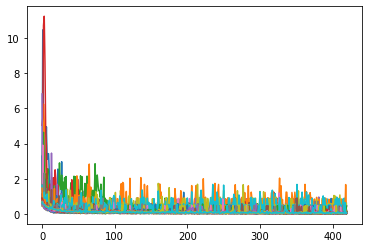

In [40]:
#### Graph embedding #####

## deepwalk
a_arr = [8, 16, 32, 64, 128, 256] ## num_walks
b_arr = [8, 16, 32, 64, 128, 256] ## walk_length

for i in range (len(a_arr)):
    
    for j in range(len(b_arr)):

        a_str = str(a_arr[i])
        b_str = str(b_arr[j])
        
        input_g_mtd_str = 'nw' + a_str + '_wl' + b_str ## struc2vec, deepwalk
        print(input_g_mtd_str)
        
        run_prog('graph', input_g_mtd_str)

In [41]:
# ##### Protein embedding #####

# p_emb_arr = ['AAC', 'DPC', 'CTD', 'QSOrder', 'APAAC', 'CT', 'NMBroto']

# for i in range(len(p_emb_arr)):
  
#   input_g_mtd_str = p_emb_arr[i]

#   run_prog('protein', input_g_mtd_str)

In [42]:
# input_g_mtd_arr = ['dw-n2v-grarep-sdne', 'dw-n2v-grarep-line-sdne', 's2v-grarep-line-sdne', 'dw-n2v-s2v-grarep-sdne'] ## graph_combi
# input_g_mtd_arr = ['dw_nw8_wl32', 'n2v_p2_q0.5', 's2v_nw32_wl64', 'LINE_epochs25'] ## graph
# input_g_mtd_arr = ['SDNE_a0_b10', 'GraRep_k2'] ## graph-sdne-grarep
# input_g_mtd_arr = ['SDNE_default'] 

In [43]:
# for i in range(len(input_g_mtd_arr)):
  
#   # print(input_emb_type_arr[i]) # input_emb_type_arr = ['graph-sdne-grarep', 'graph', 'graph']
  
#   print(input_g_mtd_arr[i])

#   run_prog('graph-sdne-grarep', input_g_mtd_arr[i]) ## graph, graph-sdne-grarep, graph_combi

#   print("************************************************** DONE " + str(i+1) + " **************************************************")


In [44]:
# eval_metrics = []

# ## 5-fold Cross Validation
# for i in range(0, 5):

#     print('Iteration(train): ', (i+1))
#     # acc = train(emb_type='hvppi', input_type='hvppi') ## Samples new data, overwrite hyperparams here
#     acc = train(emb_type='graph_combi', input_type='s2v-sdne') 
    
#     eval_metrics.append(acc)
#     print(eval_metrics)

# # save_mtd = 'node2vec_50p'
# # np.save(get_path + 'data/eval_matrices/' + save_mtd + '.npy', eval_metrics)

In [45]:
## 1 Iteration
# acc = train() ## Samples new data
# eval_metrics.append(acc)
# print(eval_metrics)

## Evaluation

In [46]:
## Append results here
# eval_arr = eval_metrics

In [47]:
# mean = np.array(eval_arr).mean(axis=0) # Take the mean of each column
# mean = np.round(mean, 4)
# print('Mean: ' + str(mean)[1:-1])

# max = np.array(eval_arr).max(axis=0)
# max = np.round(max, 4)
# print('Max: ' + str(max)[1:-1])

# min = np.array(eval_arr).min(axis=0)
# min = np.round(min, 4)
# print('Min: ' + str(min)[1:-1])

In [48]:
## CHANGE METHOD HERE
# mtd_name = 'combi_1'

In [49]:
# with open(get_path + 'GraphEmbCombi_results.txt', "a") as f:
#     f.write(mtd_name + ': ' + str(mean) + '\n')

In [50]:
############### DATASETS INPUT HERE ###############
# def create_fold():

#     # return train, val, test

#     # ### 0.99 threshold
#     # pos_org = pd.read_csv(data_path + 'edges/positive_edges_0.99.csv')
    
#     # # neg_org = pd.read_csv(data_path + 'edges/negative_edges_all.csv')
#     # neg_org = pd.read_csv(data_path + 'edges/negative_edges_12.5p.csv')
#     # neg_org = pd.read_csv(data_path + 'edges/negative_edges_25p.csv')

#     ## Struct2Graph
#     pos_org = pd.read_csv(data_path + 'edges/positive_edges_struct2graph.csv')
#     neg_org = pd.read_csv(data_path + 'edges/negative_edges_struct2graph.csv')
    
#     '''
#         Shuffle Data
#     '''
#     pos = shuffle(pos_org)
#     neg = shuffle(neg_org)

#     # Sample positive dataset (for _struct2graph)
#     pos = pos[:len(neg)]

#     ## Sample negative dataset
#     # neg = neg[:len(pos)]

#     # print(pos)
#     # print(len(pos))

#     ## Train : Val : Test = 67.5 : 12.5 : 20
#     # pos_test = pos.sample(frac = 0.2, replace = False) ## 20% of positive dataset
#     # pos_train_val = pos[~pos.index.isin(pos_test.index)]
#     # pos_val = pos_train_val.sample(frac = 0.125, replace = False) ## 12.5% of remaining 80% 
#     # pos_train = pos_train_val[~pos_train_val.index.isin(pos_val.index)]

#     # neg_test = neg.sample(frac = 0.2, replace = False) ## 20% of negative dataset
#     # neg_train_val = neg[~neg.index.isin(neg_test.index)]
#     # neg_val = neg_train_val.sample(frac = 0.125, replace = False) ## 12.5% of remaining 80% 
#     # neg_train = neg_train_val[~neg_train_val.index.isin(neg_val.index)]

#     ## Train : Val : Test = 8 : 1 : 1
#     pos_test = pos.sample(frac = 0.1, replace = False) ## 10% of positive dataset
#     pos_train_val = pos[~pos.index.isin(pos_test.index)]
#     pos_val = pos_train_val.sample(frac = 0.1, replace = False) ## 10% of remaining 80% 
#     pos_train = pos_train_val[~pos_train_val.index.isin(pos_val.index)]

#     neg_test = neg.sample(frac = 0.1, replace = False) 
#     neg_train_val = neg[~neg.index.isin(neg_test.index)]
#     neg_val = neg_train_val.sample(frac = 0.1, replace = False) 
#     neg_train = neg_train_val[~neg_train_val.index.isin(neg_val.index)]
    
#     train_df = pd.concat([pos_train, neg_train], ignore_index=True)
#     val_df = pd.concat([pos_val, neg_val], ignore_index=True)
#     test_df = pd.concat([pos_test, neg_test], ignore_index=True)


#     # print(len(train_df), len(val_df), len(test_df)) ## 4022, 574, 1148

#     ## Using random sampling of remaining pos and neg dataset as the test set
#     # test_size = 1148
#     # test_set = pd.read_csv()
#     # test_df = shuffle(test_set)
#     # test_df = test_df[:test_size] 

#     ## Held-out test set - used exclusively in the test dataset (Held-out)

#     print('--Sampled new data--')

#     return train_df, val_df, test_df